# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import sys
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


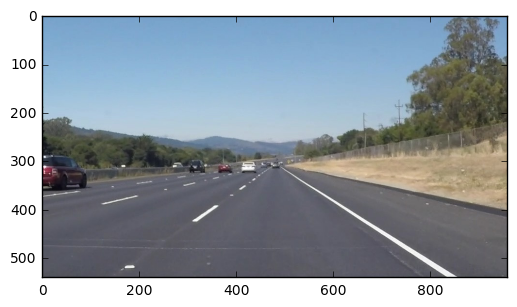

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
print(sys.version)

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
def vertices_trapaziod(image,percent_x_top,percent_y_top,percent_x_bottom=1.,percent_y_bottom=1.):
    """
    Takes image and percentages for x, y reduction

    Returns an np.array with a list np.int32 type tuples of x,y points
    for a trapazoid from the bottom of an image with the x lines parallel
    """
    imshape = image.shape

    return np.array([[(int(imshape[1]*(1-percent_x_bottom)),int(imshape[0]*percent_y_bottom)),(int(imshape[1]*percent_x_top), int(imshape[0]*percent_y_top)), (int(imshape[1]*(1-percent_x_top)), int(imshape[0]*(percent_y_top))), (int(imshape[1]*percent_x_bottom),int(imshape[0]*percent_y_bottom))]], dtype=np.int32)


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    r_slope=[]
    l_slope=[]
    left_lane = []
    right_lane = []
    r_weight = []
    l_weight = []
    y_min = int(image.shape[0]*1/1.67)
    y_max = image.shape[0]
    
   
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            slope = (y2-y1)/float(x2-x1)
        
            if slope < 0:
                l_slope.append(slope)
                left_lane.append(line)   
                l_weight.append((x2-x1)**2+(y2-y1)**2)
            elif slope >= 0 and np.isnan(slope)==False:
                r_slope.append(slope)
                right_lane.append(line)
                r_weight.append((x2-x1)**2+(y2-y1)**2)
            if y1 < y_min:
                y_min = y1
            elif y2< y_min:
                y_min = y2
                
          
    print(r_slope)        
    l_slope_mean = np.sum(np.array(l_slope)*np.array(l_weight))/np.sum(l_weight)
    r_slope_mean = np.sum(np.array(r_slope)*np.array(r_weight))/np.sum(r_weight)
    print(l_slope_mean,r_slope_mean)  
    l_xy_av = np.array(left_lane)
    l_mean = np.mean(l_xy_av,axis=0)
    
    r_xy_av = np.array(right_lane)
    r_mean = np.mean(r_xy_av,axis=0)
   
    l_y_intercept = l_mean[0][1] - (l_mean[0][0] * l_slope_mean)
    r_y_intercept = r_mean[0][1] - (r_mean[0][0] * r_slope_mean)
    
    #find associated x1 for y_global_min using (y_global_min = m_avg * x1 + b)
    #similarly find associated x2 for y_max = imshape[0] (this is the lowest y in the image)

    x_l_1 = int((y_min - l_y_intercept)/l_slope_mean) 
    x_l_2 = int((y_max - l_y_intercept)/l_slope_mean)
    x_r_1 = int((y_min - r_y_intercept)/r_slope_mean)
    x_r_2 = int((y_max - r_y_intercept)/r_slope_mean)
    
    cv2.line(img, (x_l_1, y_min), (x_l_2, y_max), color, thickness)
    cv2.line(img, (x_r_1, y_min), (x_r_2, y_max), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, int(threshold), np.array([]), minLineLength=int(min_line_len), maxLineGap=int(max_line_gap))
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
dir_list=os.listdir("test_images/")


run your solution on all test_images and make copies into the test_images directory).

[0.57664233576642332, 0.55211267605633807, 0.57692307692307687, 0.56000000000000005, 0.54285714285714282, 0.55102040816326525, 0.5714285714285714, 0.53333333333333333, 0.5641025641025641]
-0.806104545342 0.562600602645
[0.65134099616858232, 0.62422360248447206, 0.65405405405405403, 0.651685393258427, 0.65384615384615385, 0.0, 0.62637362637362637, 0.62962962962962965, 0.65217391304347827]
-0.700138479695 0.638206020368
[0.56521739130434778, 0.62790697674418605, 0.63636363636363635, 0.5]
-0.723398526909 0.596037873756
[0.62195121951219512, 0.57534246575342463, 0.5625, 0.55000000000000004, 0.61538461538461542, 0.59259259259259256, 0.55555555555555558, 0.54285714285714282, 0.57894736842105265, 0.5, 0.625, 0.53333333333333333, 0.62962962962962965, 0.56666666666666665, 0.63157894736842102]
-0.741732581954 0.595788633168
[0.64102564102564108, 0.56521739130434778, 0.6470588235294118, 0.66666666666666663, 0.59183673469387754, 0.5714285714285714, 0.61111111111111116, 0.56521739130434778, 0.71428

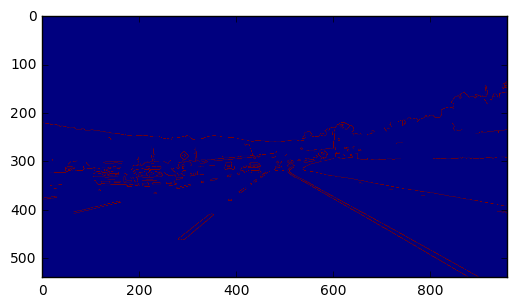

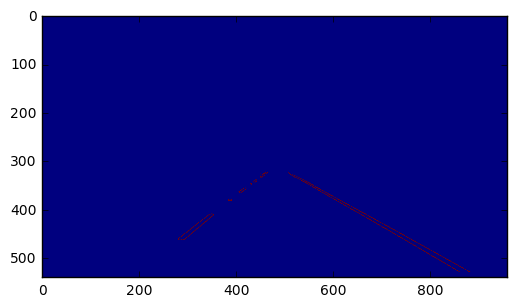

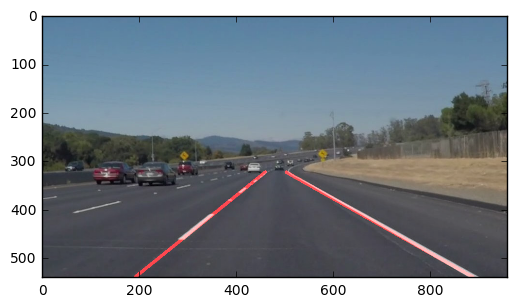

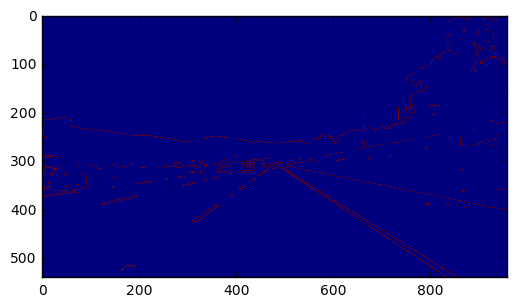

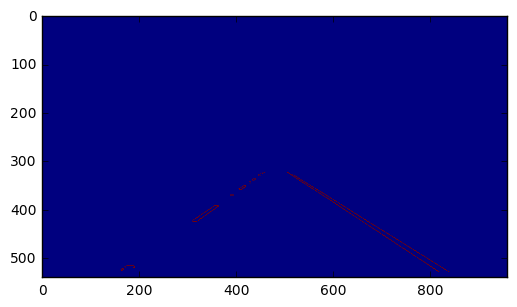

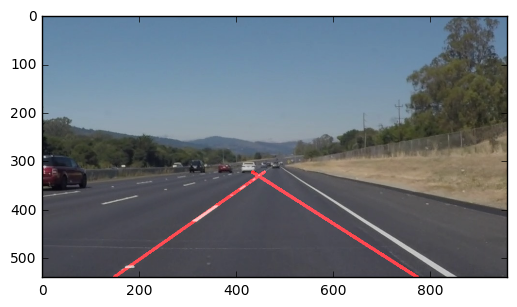

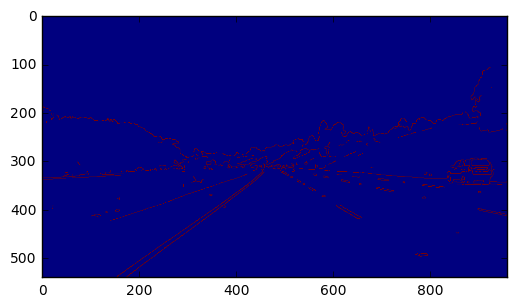

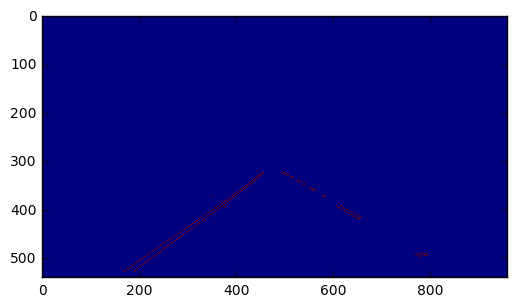

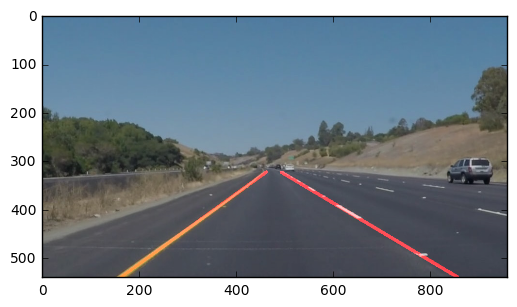

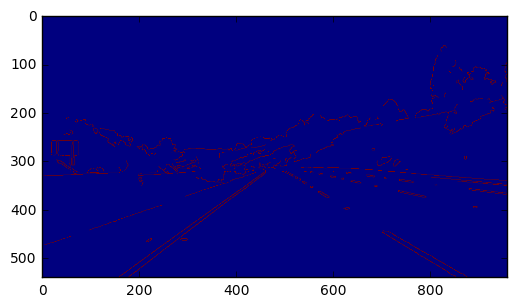

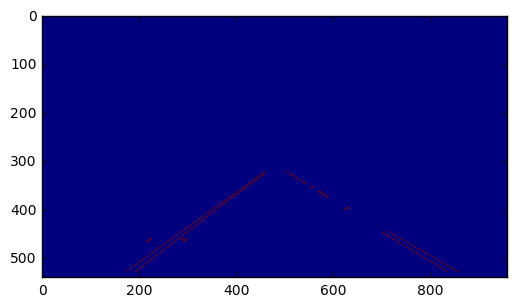

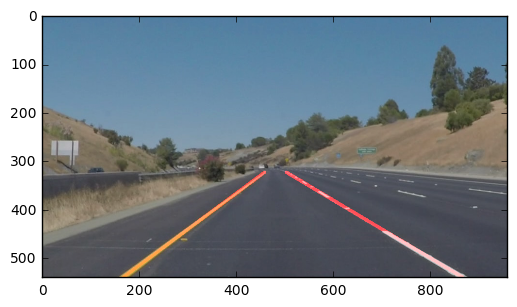

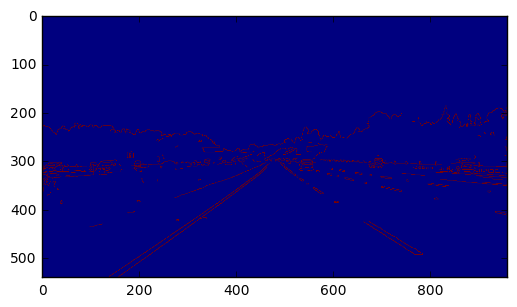

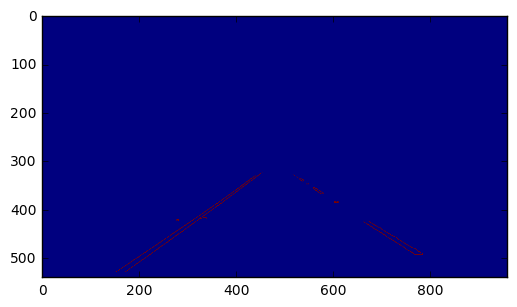

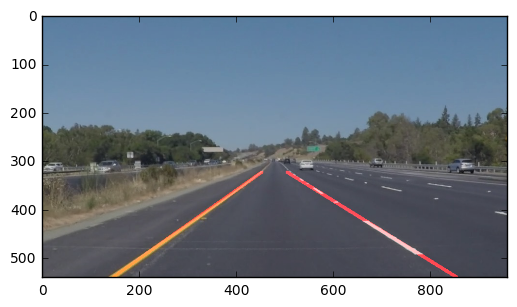

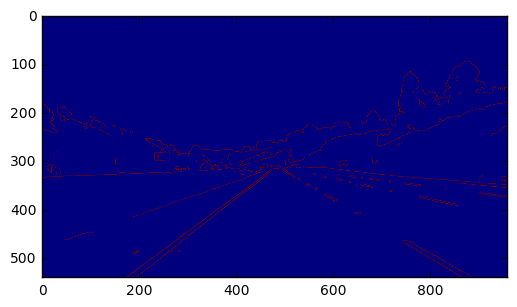

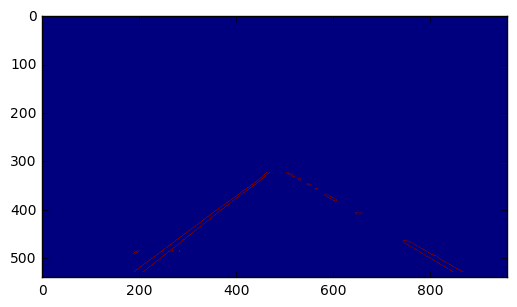

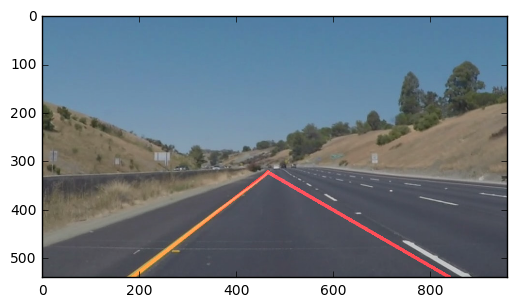

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
for image_path in dir_list:
    
    image = mpimg.imread("test_images/"+image_path)
    gray_image = grayscale(image.copy())
    blur_image=gaussian_blur(gray_image, 3)
    edges=canny(blur_image, 100, 150)
    plt.figure()
    plt.imshow(edges)
    masked_image=region_of_interest(edges, vertices_trapaziod(edges,7.6/16,1/1.67,1,0.98))
    plt.figure()
    plt.imshow(masked_image)
    line_image=hough_lines(masked_image, 1, np.pi/180, 8, 14,3 )
    plt.figure()
    plt.imshow(weighted_img(line_image, image, α=0.8, β=1., λ=0.))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
threshold_percent = float(15)/540
min_line_length_percent = float(40)/540
max_line_gap_percent = float(25)/540
def process_image(image):
    y_size=image.shape[0]
    gray_image = grayscale(image.copy())
    blur_image=gaussian_blur(gray_image, 5)
    edges=canny(blur_image, 70, 120)
    masked_image=region_of_interest(edges, vertices_trapaziod(edges,7.7/16,1/1.67,0.94,0.92))
    line_image=hough_lines(masked_image, 1, np.pi/180, threshold_percent*image.shape[0], min_line_length_percent*image.shape[0],max_line_gap_percent*image.shape[0])
    result = weighted_img(line_image, image, α=0.8, β=1., λ=0.)
    return result


Let's try the one with the solid white lane on the right first ...

In [21]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[0.6033519553072626, 0.6015625, 0.62564102564102564, 0.62650602409638556, 0.61702127659574468, 0.62658227848101267]
-0.741617477944 0.612315622729
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4





  0%|          | 0/222 [00:00<?, ?it/s]

[0.6033519553072626, 0.6015625, 0.62564102564102564, 0.62650602409638556, 0.61702127659574468, 0.62658227848101267]
-0.741617477944 0.612315622729





  0%|          | 1/222 [00:00<00:24,  9.20it/s]

[0.62672811059907829, 0.60311284046692604, 0.625, 0.63, 0.60655737704918034, 0.60103626943005184, 0.6271186440677966]
-0.737213196912 0.613706893533
[0.62704918032786883, 0.60077519379844957, 0.625, 0.62727272727272732]
-0.733464904636 0.616211260195





  1%|▏         | 3/222 [00:00<00:21, 10.05it/s]

[0.60077519379844957, 0.59999999999999998, 0.62436548223350252, 0.62765957446808507]
-0.726978834161 0.607033375967
[0.59845559845559848, 0.625, 0.61403508771929827, 0.61363636363636365, 0.59999999999999998]
-0.706167954916 0.608650071942
[0.59999999999999998, 0.62601626016260159, 0.59999999999999998, 0.60130718954248363, 0.625, 0.62393162393162394]
-0.708375134528 0.611800051444





  3%|▎         | 6/222 [00:00<00:18, 11.94it/s]

[0.59842519685039375, 0.62213740458015265, 0.59999999999999998, 0.61904761904761907]
-0.713007828185 0.608316980538
[0.59842519685039375, 0.62441314553990612, 0.62555066079295152, 0.59999999999999998, 0.59663865546218486]
-0.719345353886 0.6115542517





  4%|▎         | 8/222 [00:00<00:15, 13.50it/s]

[0.62548262548262545, 0.59999999999999998, 0.59999999999999998, 0.62637362637362637, 0.60162601626016265, 0.62745098039215685]
-0.706600302992 0.611478116674
[0.60076045627376429, 0.62903225806451613, 0.62318840579710144, 0.61904761904761907, 0.58267716535433067]
-0.706665161371 0.607504915968
[0.60103626943005184, 0.64655172413793105, 0.60273972602739723, 0.6467065868263473, 0.64000000000000001, 0.59090909090909094, 0.60330578512396693, 0.64835164835164838]
-0.712646663483 0.626677641322





  5%|▍         | 11/222 [00:00<00:14, 14.81it/s]

[0.64772727272727271, 0.62184873949579833, 0.62424242424242427, 0.63414634146341464, 0.63414634146341464, 0.66949152542372881]
-0.711002145077 0.637126113932
[0.62213740458015265, 0.64885496183206104, 0.65100671140939592, 0.65079365079365081, 0.625, 0.63414634146341464, 0.62424242424242427]
-0.712022539329 0.636238436243
[0.62857142857142856, 0.62403100775193798, 0.6706586826347305, 0.6706586826347305, 0.66896551724137931, 0.62256809338521402, 0.67391304347826086]
-0.709688316915 0.640684439559





  6%|▋         | 14/222 [00:00<00:12, 16.40it/s]

[0.6224899598393574, 0.66666666666666663, 0.67005076142131981, 0.62616822429906538, 0.67123287671232879, 0.67261904761904767]
-0.705993049679 0.64441097995
[0.62295081967213117, 0.67179487179487174, 0.625, 0.67052023121387283, 0.62608695652173918]
-0.673122742168 0.643739828868
[0.67080745341614911, 0.62295081967213117, 0.62436548223350252, 0.6705882352941176, 0.62727272727272732, 0.66153846153846152]
-0.712564945214 0.640432705553





  8%|▊         | 17/222 [00:00<00:11, 17.52it/s]

[0.62295081967213117, 0.66901408450704225, 0.6706586826347305, 0.61363636363636365]
-0.710732954929 0.64391998344
[0.62301587301587302, 0.65027322404371579, 0.65384615384615385, 0.6244897959183674, 0.65000000000000002, 0.65217391304347827]
-0.699979968288 0.634548231877
[0.65098039215686276, 0.62352941176470589, 0.62204724409448819, 0.65333333333333332, 0.64912280701754388]
-0.683264916222 0.636329788157





  9%|▉         | 20/222 [00:01<00:10, 18.52it/s]

[0.62256809338521402, 0.65217391304347827, 0.65151515151515149, 0.65000000000000002, 0.625]
-0.731471951051 0.636053605637
[0.64960629921259838, 0.62403100775193798, 0.65079365079365081, 0.65217391304347827, 0.63265306122448983]
-0.703165405186 0.639806532804
[0.62256809338521402, 0.65098039215686276, 0.64935064935064934, 0.65591397849462363, 0.62385321100917435]
-0.733868499182 0.638641033511





 10%|█         | 23/222 [00:01<00:10, 19.51it/s]

[0.62450592885375489, 0.67032967032967028, 0.66129032258064513, 0.62727272727272732, 0.68181818181818177, 0.65289256198347112, 0.63414634146341464]
-0.694416813946 0.641912021428
[0.6706586826347305, 0.62450592885375489, 0.66666666666666663, 0.68292682926829273, 0.66981132075471694, 0.62549800796812749, 0.66666666666666663]
-0.706408883929 0.639151163649
[0.624, 0.65158371040723984, 0.62450592885375489, 0.64963503649635035, 0.65476190476190477]
-0.693513912667 0.634485352881





 12%|█▏        | 26/222 [00:01<00:09, 19.81it/s]

[0.62450592885375489, 0.6506550218340611, 0.64948453608247425, 0.624]
-0.711127846411 0.633004052895
[0.62301587301587302, 0.62450592885375489, 0.65200000000000002, 0.65243902439024393, 0.64912280701754388]
-0.718259419729 0.636404353842
[0.65322580645161288, 0.62450592885375489, 0.62439024390243902, 0.65044247787610621, 0.64942528735632188, 0.6428571428571429]
-0.697673334819 0.640119086818





 13%|█▎        | 29/222 [00:01<00:09, 20.25it/s]

[0.62151394422310757, 0.65126050420168069, 0.62393162393162394, 0.65158371040723984, 0.6506024096385542, 0.624]
-0.742932828268 0.635778556994
[0.625, 0.66666666666666663, 0.62068965517241381, 0.63793103448275867, 0.63513513513513509, 0.62962962962962965, 0.62365591397849462, 0.61904761904761907, 0.63414634146341464]
-0.713731203061 0.628242554035
[0.65306122448979587, 0.6224899598393574, 0.6216216216216216, 0.6517857142857143, 0.62352941176470589, 0.6216216216216216]
-0.701814950992 0.638061760858





 14%|█▍        | 32/222 [00:01<00:09, 20.25it/s]

[0.62343096234309625, 0.6495726495726496, 0.6224899598393574, 0.625, 0.6428571428571429, 0.6428571428571429]
-0.707971031259 0.631256161732
[0.64953271028037385, 0.6244897959183674, 0.65306122448979587, 0.61904761904761907, 0.65044247787610621]
-0.74995519574 0.642746004234
[0.62450592885375489, 0.65198237885462551, 0.62430939226519333, 0.620253164556962, 0.64912280701754388, 0.64000000000000001]
-0.720560871099 0.634030044656





 16%|█▌        | 35/222 [00:01<00:09, 20.28it/s]

[0.62605042016806722, 0.65217391304347827, 0.625, 0.65116279069767447, 0.6428571428571429, 0.6228070175438597]
-0.710259754928 0.634141691768
[0.67241379310344829, 0.62389380530973448, 0.625, 0.66666666666666663, 0.65384615384615385]
-0.727056680222 0.638610688767
[0.62555066079295152, 0.67136150234741787, 0.62601626016260159, 0.67105263157894735, 0.66666666666666663, 0.67441860465116277]
-0.708865589257 0.644681411105





 17%|█▋        | 38/222 [00:01<00:09, 20.09it/s]

[0.62551440329218111, 0.67000000000000004, 0.62616822429906538, 0.66666666666666663, 0.62790697674418605, 0.68518518518518523, 0.65116279069767447]
-0.723183147085 0.640209042553
[0.67052023121387283, 0.625, 0.62790697674418605, 0.66863905325443784, 0.62643678160919536, 0.64444444444444449]
-0.717474078709 0.642021043465
[0.62436548223350252, 0.67099567099567103, 0.62672811059907829, 0.67142857142857137, 0.63095238095238093, 0.68518518518518523]
-0.738084697534 0.644641785142





 18%|█▊        | 41/222 [00:02<00:09, 19.98it/s]

[0.66666666666666663, 0.67149758454106279, 0.6271186440677966, 0.62441314553990612, 0.6333333333333333]
-0.739384556298 0.643885070979
[0.67094017094017089, 0.62564102564102564, 0.6333333333333333, 0.67234042553191486, 0.61538461538461542]
-0.721737652134 0.658822907521
[0.64534883720930236, 0.67179487179487174, 0.66666666666666663, 0.64646464646464652, 0.64948453608247425, 0.67372881355932202]
-0.759802641812 0.664238746881





 20%|█▉        | 44/222 [00:02<00:09, 18.25it/s]

[0.67281105990783407, 0.62430939226519333, 0.6696428571428571, 0.63414634146341464, 0.62637362637362637, 0.62755102040816324, 0.67521367521367526]
-0.769762897001 0.653959498928
[0.67226890756302526, 0.6470588235294118, 0.6428571428571429, 0.63461538461538458, 0.65000000000000002, 0.66666666666666663, 0.64444444444444449]
-0.747333805784 0.659071061182





 21%|██        | 46/222 [00:02<00:10, 17.15it/s]

[0.67094017094017089, 0.62727272727272732, 0.67261904761904767, 0.62790697674418605, 0.63513513513513509, 0.67234042553191486]
-0.722599601016 0.657432728312
[0.67256637168141598, 0.67256637168141598, 0.62790697674418605, 0.62420382165605093, 0.62295081967213117, 0.61538461538461542]
-0.713668412939 0.653014970881





 22%|██▏       | 48/222 [00:02<00:12, 14.14it/s]

[0.67364016736401677, 0.64571428571428569, 0.64077669902912626, 0.67420814479638014, 0.65909090909090906, 0.67368421052631577, 0.65853658536585369, 0.66666666666666663]
-0.718632990445 0.666111898332
[0.67364016736401677, 0.64457831325301207, 0.64150943396226412, 0.67420814479638014, 0.6607142857142857, 0.66666666666666663]
-0.713976567143 0.665877702012





 23%|██▎       | 50/222 [00:02<00:11, 14.52it/s]

[0.67364016736401677, 0.6428571428571429, 0.67431192660550454, 0.64335664335664333, 0.66101694915254239, 0.65909090909090906, 0.65853658536585369, 0.64000000000000001, 0.67441860465116277]
-0.715625135344 0.666060602036
[0.6711711711711712, 0.67381974248927035, 0.62773722627737227, 0.62686567164179108, 0.61224489795918369]
-0.708348271843 0.655862987646





 23%|██▎       | 52/222 [00:03<00:22,  7.62it/s]

[0.66666666666666663, 0.62777777777777777, 0.67142857142857137, 0.625, 0.625, 0.67400881057268724, 0.62564102564102564]
-0.685554198151 0.650877041654
[0.62702702702702706, 0.62814070351758799, 0.67099567099567103, 0.67010309278350511, 0.62857142857142856, 0.6271186440677966]
-0.681475208736 0.650653417201





 24%|██▍       | 54/222 [00:03<00:20,  8.25it/s]

[0.62650602409638556, 0.66666666666666663, 0.66923076923076918, 0.67298578199052128, 0.59999999999999998, 0.63157894736842102, 0.61702127659574468]
-0.691910329229 0.649948196177
[0.62352941176470589, 0.66666666666666663, 0.67073170731707321, 0.66949152542372881, 0.62553191489361704]
-0.728941635952 0.639219992844





 25%|██▌       | 56/222 [00:03<00:17,  9.43it/s]

[0.62450592885375489, 0.67204301075268813, 0.66887417218543044, 0.62385321100917435, 0.66666666666666663, 0.63157894736842102, 0.62403100775193798]
-0.671676059798 0.638950533867
[0.67142857142857137, 0.62452107279693492, 0.6706586826347305, 0.62589928057553956, 0.62773722627737227, 0.66666666666666663, 0.67164179104477617]
-0.689312785371 0.645337562561
[0.67142857142857137, 0.62569832402234637, 0.62601626016260159, 0.66101694915254239, 0.67005076142131981, 0.61363636363636365, 0.62650602409638556]
-0.701563819177 0.649856327509





 27%|██▋       | 59/222 [00:03<00:14, 11.37it/s]

[0.64393939393939392, 0.64550264550264547, 0.67149758454106279, 0.67381974248927035, 0.65957446808510634, 0.66666666666666663]
-0.691805939819 0.663141636085
[0.67381974248927035, 0.64622641509433965, 0.6460674157303371, 0.64779874213836475, 0.67475728155339809, 0.67777777777777781, 0.63793103448275867, 0.660377358490566]
-0.679788935316 0.660550470885





 27%|██▋       | 61/222 [00:03<00:13, 12.03it/s]

[0.65277777777777779, 0.64640883977900554, 0.69117647058823528, 0.64130434782608692, 0.64444444444444449, 0.64583333333333337, 0.6495726495726496, 0.6607142857142857, 0.65277777777777779, 0.64864864864864868]
-0.67319153049 0.650197444324
[0.67272727272727273, 0.62814070351758799, 0.63157894736842102, 0.66666666666666663, 0.62666666666666671, 0.67441860465116277, 0.61702127659574468]
-0.673861858285 0.647752116262
[0.6470588235294118, 0.65408805031446537, 0.6428571428571429, 0.65740740740740744, 0.65432098765432101, 0.66216216216216217, 0.65454545454545454, 0.65909090909090906, 0.65909090909090906]
-0.656706379924 0.651868470389





 29%|██▉       | 64/222 [00:04<00:11, 13.91it/s]

[0.67330677290836649, 0.64516129032258063, 0.64566929133858264, 0.67361111111111116, 0.67428571428571427, 0.66101694915254239, 0.660377358490566, 0.6607142857142857]
-0.666257854942 0.666095092808
[0.67200000000000004, 0.62871287128712872, 0.63095238095238093, 0.67469879518072284, 0.62804878048780488, 0.62318840579710144]
-0.700295502018 0.652424120844





 30%|██▉       | 66/222 [00:04<00:10, 15.19it/s]

[0.67338709677419351, 0.62745098039215685, 0.62886597938144329, 0.62337662337662336, 0.66666666666666663]
-0.662006395933 0.650691296664
[0.67338709677419351, 0.64532019704433496, 0.6449704142011834, 0.65957446808510634, 0.67346938775510201, 0.63934426229508201]
-0.673615500798 0.658347923784





 31%|███       | 68/222 [00:04<00:10, 15.07it/s]

[0.67200000000000004, 0.64601769911504425, 0.64583333333333337, 0.66129032258064513, 0.67355371900826444]
-0.680393688826 0.663944258978
[0.64782608695652177, 0.67200000000000004, 0.64912280701754388, 0.64367816091954022, 0.66000000000000003]
-0.676749362047 0.657959282818
[0.67611336032388669, 0.64779874213836475, 0.67611336032388669, 0.64658634538152615, 0.6428571428571429]
-0.680250934447 0.663220221162





 32%|███▏      | 71/222 [00:04<00:09, 16.49it/s]

[0.67338709677419351, 0.64331210191082799, 0.67489711934156382, 0.64423076923076927, 0.67375886524822692, 0.65909090909090906, 0.63636363636363635]
-0.680914740446 0.667454725262
[0.67622950819672134, 0.62962962962962965, 0.67579908675799083, 0.62987012987012991, 0.61904761904761907, 0.61702127659574468]
-0.683440688172 0.660732321756





 33%|███▎      | 73/222 [00:04<00:08, 17.27it/s]

[0.67469879518072284, 0.64583333333333337, 0.67634854771784236, 0.64444444444444449, 0.66666666666666663, 0.67346938775510201]
-0.673720323359 0.667579943102
[0.67741935483870963, 0.64628820960698685, 0.67532467532467533, 0.66666666666666663, 0.66666666666666663, 0.64963503649635035, 0.67567567567567566]
-0.662212328773 0.665757960291
[0.64935064935064934, 0.6776859504132231, 0.67741935483870963, 0.64919354838709675, 0.67469879518072284, 0.64814814814814814]
-0.676554870606 0.662349460984





 34%|███▍      | 76/222 [00:04<00:08, 16.75it/s]

[0.65000000000000002, 0.69565217391304346, 0.64919354838709675, 0.69512195121951215, 0.69902912621359226, 0.69565217391304346, 0.65048543689320393]
-0.67036831105 0.667237391245
[0.67924528301886788, 0.64919354838709675, 0.67586206896551726, 0.64935064935064934, 0.68041237113402064, 0.651685393258427]
-0.653238297403 0.65855956321





 35%|███▌      | 78/222 [00:04<00:09, 14.90it/s]

[0.69874476987447698, 0.65086206896551724, 0.65402843601895733, 0.72499999999999998, 0.69863013698630139, 0.69999999999999996]
-0.658597276257 0.675361519987
[0.64864864864864868, 0.69874476987447698, 0.6974358974358974, 0.65517241379310343, 0.62337662337662336, 0.6987951807228916, 0.63793103448275867]
-0.667771092761 0.678544697262





 36%|███▌      | 80/222 [00:05<00:10, 13.45it/s]

[0.65217391304347827, 0.69874476987447698, 0.65174129353233834, 0.6517857142857143]
-0.68534431657 0.668825306198
[0.70042194092827004, 0.64948453608247425, 0.65289256198347112, 0.69874476987447698, 0.65789473684210531, 0.70048309178743962]
-0.643735442476 0.687072189116





 37%|███▋      | 82/222 [00:05<00:13, 10.07it/s]

[0.7021276595744681, 0.65258215962441313, 0.70168067226890751, 0.66216216216216217, 0.63636363636363635, 0.69999999999999996, 0.63636363636363635, 0.66666666666666663]
-0.674878336498 0.685621772363
[0.67195767195767198, 0.70305676855895194, 0.70168067226890751, 0.67123287671232879, 0.67226890756302526, 0.66666666666666663]
-0.65712493738 0.689216225479





 38%|███▊      | 84/222 [00:05<00:15,  9.16it/s]

[0.70168067226890751, 0.67407407407407405, 0.66896551724137931, 0.70135746606334837, 0.67455621301775148, 0.67307692307692313]
-0.647758924879 0.690170850093
[0.7008928571428571, 0.66863905325443784, 0.67391304347826086, 0.6717557251908397, 0.70512820512820518]
-0.655868922585 0.686415745012





 39%|███▊      | 86/222 [00:05<00:12, 10.68it/s]

[0.70135746606334837, 0.65263157894736845, 0.65648854961832059, 0.69999999999999996, 0.65909090909090906, 0.65000000000000002]
-0.64710391915 0.675627350688
[0.70157068062827221, 0.6737967914438503, 0.70222222222222219, 0.66917293233082709, 0.67032967032967028, 0.67647058823529416, 0.71111111111111114]
-0.65728955054 0.689237913056





 40%|███▉      | 88/222 [00:06<00:15,  8.70it/s]

[0.70370370370370372, 0.66666666666666663, 0.67441860465116277, 0.70526315789473681, 0.67391304347826086, 0.70454545454545459, 0.67132867132867136]
-0.658709603673 0.687879527503
[0.70253164556962022, 0.67625899280575541, 0.66666666666666663, 0.70048309178743962, 0.71014492753623193, 0.6875, 0.65671641791044777, 0.68852459016393441]
-0.660382568928 0.693070714976





 41%|████      | 90/222 [00:06<00:13,  9.75it/s]

[0.67475728155339809, 0.70588235294117652, 0.70297029702970293, 0.69047619047619047, 0.69999999999999996, 0.7068965517241379, 0.68181818181818177, 0.625]
-0.665195254759 0.690205549729
[0.72108843537414968, 0.67213114754098358, 0.7010309278350515, 0.72272727272727277, 0.72072072072072069, 0.6953125, 0.72477064220183485]
-0.679319266982 0.712307853288
[0.67500000000000004, 0.72444444444444445, 0.72185430463576161, 0.67391304347826086, 0.72527472527472525, 0.66666666666666663]
-0.637475596903 0.705580511285





 42%|████▏     | 93/222 [00:06<00:11, 11.72it/s]

[0.70588235294117652, 0.6705882352941176, 0.7007299270072993, 0.74193548387096775, 0.69798657718120805, 0.68518518518518523, 0.70503597122302153, 0.69999999999999996, 0.71084337349397586]
-0.648810149378 0.701956867863
[0.70161290322580649, 0.69512195121951215, 0.70491803278688525, 0.71052631578947367, 0.69230769230769229, 0.6875, 0.70769230769230773, 0.68888888888888888]
-0.652292248971 0.7008878954





 43%|████▎     | 95/222 [00:06<00:12, 10.38it/s]

[0.72380952380952379, 0.6811594202898551, 0.72432432432432436, 0.71999999999999997, 0.6742424242424242, 0.67346938775510201, 0.67592592592592593]
-0.666702699152 0.706427474914
[0.72350230414746541, 0.67804878048780493, 0.68421052631578949, 0.66666666666666663, 0.72352941176470587]
-0.662021511917 0.70544796296





 44%|████▎     | 97/222 [00:06<00:11, 11.12it/s]

[0.72477064220183485, 0.67796610169491522, 0.7247191011235955, 0.67543859649122806, 0.72413793103448276, 0.67724867724867721]
-0.665655496314 0.701879002122
[0.67788461538461542, 0.72477064220183485, 0.6741573033707865, 0.67469879518072284, 0.72592592592592597]
-0.676730794652 0.703076692126





 45%|████▍     | 99/222 [00:06<00:09, 12.54it/s]

[0.72558139534883725, 0.67539267015706805, 0.67832167832167833, 0.72625698324022347, 0.72727272727272729, 0.67647058823529416]
-0.670906418569 0.708008533436
[0.6795580110497238, 0.72248803827751196, 0.67692307692307696, 0.72685185185185186, 0.72463768115942029]
-0.670507856382 0.706909496651





 45%|████▌     | 101/222 [00:07<00:09, 12.68it/s]

[0.72164948453608246, 0.67741935483870963, 0.71844660194174759, 0.7232142857142857, 0.72307692307692306]
-0.656711699303 0.703441102063
[0.67487684729064035, 0.71900826446280997, 0.72077922077922074, 0.67685589519650657, 0.71999999999999997, 0.72352941176470587, 0.72413793103448276]
-0.687213222891 0.69752098792





 46%|████▋     | 103/222 [00:07<00:09, 12.23it/s]

[0.67475728155339809, 0.72077922077922074, 0.7142857142857143, 0.71818181818181814, 0.72173913043478266, 0.66666666666666663]
-0.652772385165 0.695842891058
[0.703125, 0.67685589519650657, 0.7016574585635359, 0.70370370370370372, 0.68888888888888888, 0.65573770491803274, 0.67924528301886788]
-0.665237324328 0.685449826646





 47%|████▋     | 105/222 [00:07<00:08, 13.40it/s]

[0.67400881057268724, 0.70394736842105265, 0.70121951219512191, 0.70588235294117652, 0.67479674796747968]
-0.662605282934 0.68725020136
[0.67555555555555558, 0.72108843537414968, 0.72121212121212119, 0.72340425531914898, 0.67441860465116277, 0.67500000000000004]
-0.690510188965 0.693328607518





 48%|████▊     | 107/222 [00:07<00:08, 13.81it/s]

[0.67256637168141598, 0.70370370370370372, 0.70238095238095233, 0.70297029702970293, 0.69999999999999996, 0.67692307692307696, 0.6785714285714286]
-0.668545494344 0.688371871047
[0.67256637168141598, 0.72108843537414968, 0.7192982456140351]
-0.677612121008 0.692411412795





 49%|████▉     | 109/222 [00:07<00:09, 12.21it/s]

[0.67256637168141598, 0.70138888888888884, 0.70129870129870131, 0.67256637168141598, 0.70175438596491224, 0.70044052863436124]
-0.667396684737 0.686708354814
[0.67256637168141598, 0.70129870129870131, 0.69999999999999996, 0.67052023121387283, 0.70175438596491224, 0.70050761421319796]
-0.659991026884 0.68853326172





 50%|█████     | 111/222 [00:07<00:09, 12.20it/s]

[0.67179487179487174, 0.70078740157480313, 0.69955156950672648, 0.67307692307692313, 0.68852459016393441, 0.65671641791044777, 0.66000000000000003, 0.68627450980392157, 0.6875]
-0.658177025079 0.687462971984
[0.69911504424778759, 0.67000000000000004, 0.67129629629629628, 0.70149253731343286, 0.66666666666666663]
-0.667715055275 0.683551088852





 51%|█████     | 113/222 [00:07<00:07, 13.63it/s]

[0.67027027027027031, 0.69819819819819817, 0.66863905325443784, 0.69902912621359226, 0.66666666666666663]
-0.679788813891 0.686555111205
[0.67096774193548392, 0.69724770642201839, 0.66901408450704225, 0.69948186528497414, 0.68888888888888888, 0.66129032258064513, 0.68518518518518523, 0.68852459016393441]
-0.654985752942 0.687944295046





 52%|█████▏    | 115/222 [00:08<00:07, 13.66it/s]

[0.69756097560975605, 0.67333333333333334, 0.66233766233766234, 0.65909090909090906, 0.6964285714285714, 0.63636363636363635, 0.68292682926829273, 0.65853658536585369]
-0.666662420347 0.687665498096
[0.64948453608247425, 0.69633507853403143, 0.64827586206896548, 0.6953125, 0.69841269841269837, 0.64912280701754388]
-0.692030793981 0.671127464666





 53%|█████▎    | 117/222 [00:08<00:13,  7.66it/s]

[0.6495726495726496, 0.69696969696969702, 0.6964285714285714, 0.64942528735632188, 0.68918918918918914, 0.65000000000000002, 0.70833333333333337]
-0.676556994637 0.66788604839
[0.67500000000000004, 0.64529914529914534, 0.68181818181818177, 0.6742424242424242, 0.67889908256880738, 0.63114754098360659, 0.660377358490566]
-0.660852850689 0.659442776142





 54%|█████▎    | 119/222 [00:08<00:13,  7.37it/s]

[0.67364016736401677, 0.64835164835164838, 0.67289719626168221, 0.64628820960698685, 0.64492753623188404, 0.65909090909090906]
-0.664925292738 0.658987868376
[0.67364016736401677, 0.62831858407079644, 0.62831858407079644, 0.67539267015706805, 0.625, 0.61403508771929827]
-0.689266154172 0.65317360397





 55%|█████▍    | 121/222 [00:09<00:11,  8.80it/s]

[0.6737967914438503, 0.6449704142011834, 0.66216216216216217, 0.64534883720930236, 0.63492063492063489, 0.64615384615384619, 0.68181818181818177, 0.66666666666666663, 0.6619718309859155]
-0.667374266487 0.656195476071
[0.62777777777777777, 0.67307692307692313, 0.62857142857142856, 0.67441860465116277, 0.66666666666666663]
-0.674664840785 0.655438781216





 55%|█████▌    | 123/222 [00:09<00:11,  8.95it/s]

[0.62605042016806722, 0.67333333333333334, 0.6262626262626263, 0.67241379310344829, 0.65909090909090906, 0.62790697674418605, 0.67231638418079098]
-0.663619056992 0.650474103766
[0.65384615384615385, 0.62809917355371903, 0.65094339622641506, 0.62430939226519333, 0.65384615384615385, 0.62616822429906538, 0.65079365079365081, 0.64885496183206104]
-0.690393233915 0.637672520307





 56%|█████▋    | 125/222 [00:09<00:10,  9.69it/s]

[0.625, 0.65365853658536588, 0.65625, 0.65068493150684936, 0.6244343891402715]
-0.68080743641 0.636948594547
[0.65100671140939592, 0.65182186234817818, 0.62195121951219512, 0.62601626016260159, 0.65289256198347112]
-0.694842571874 0.636593385259





 57%|█████▋    | 127/222 [00:09<00:08, 11.44it/s]

[0.65182186234817818, 0.62195121951219512, 0.625, 0.65027322404371579, 0.65573770491803274]
-0.717751799981 0.636131483393
[0.65163934426229508, 0.6224899598393574, 0.65116279069767447, 0.61832061068702293, 0.62385321100917435]
-0.702929492321 0.63795917232





 58%|█████▊    | 129/222 [00:09<00:08, 11.02it/s]

[0.65106382978723409, 0.62393162393162394, 0.64800000000000002, 0.63461538461538458, 0.62195121951219512]
-0.716974467505 0.636444173165
[0.6506024096385542, 0.62430939226519333, 0.6224899598393574, 0.64976958525345618, 0.65000000000000002, 0.6216216216216216]
-0.69265254096 0.638203819726





 59%|█████▉    | 131/222 [00:09<00:07, 11.55it/s]

[0.6224899598393574, 0.65198237885462551, 0.64822134387351782, 0.62325581395348839, 0.65040650406504064]
-0.703047829984 0.637828834119
[0.625, 0.6506024096385542, 0.64974619289340096, 0.64963503649635035, 0.6227544910179641, 0.625]
-0.718671959192 0.637139416484





 60%|█████▉    | 133/222 [00:10<00:06, 12.80it/s]

[0.6244897959183674, 0.65271966527196656, 0.62295081967213117, 0.63829787234042556, 0.63829787234042556, 0.65240641711229952]
-0.701732063218 0.636511868917
[0.65254237288135597, 0.625, 0.62424242424242427, 0.65000000000000002, 0.64971751412429379, 0.6097560975609756, 0.6271186440677966]
-0.721001692093 0.637343946667





 61%|██████    | 135/222 [00:10<00:09,  9.66it/s]

[0.65126050420168069, 0.62343096234309625, 0.65137614678899081, 0.61971830985915488, 0.62416107382550334, 0.65384615384615385]
-0.691640163461 0.637805374858
[0.64978902953586493, 0.62222222222222223, 0.61904761904761907, 0.651685393258427, 0.65277777777777779, 0.625, 0.61904761904761907]
-0.658531763037 0.637398532784





 62%|██████▏   | 137/222 [00:10<00:07, 11.28it/s]

[0.64853556485355646, 0.62303664921465973, 0.61538461538461542, 0.64864864864864868, 0.62318840579710144, 0.61224489795918369]
-0.689173039654 0.638444207522
[0.65020576131687247, 0.62318840579710144, 0.62605042016806722, 0.64935064935064934, 0.65137614678899081, 0.61818181818181817]
-0.703865337147 0.63924226462





 63%|██████▎   | 139/222 [00:10<00:06, 12.81it/s]

[0.62396694214876036, 0.65040650406504064, 0.6470588235294118, 0.64000000000000001, 0.63414634146341464]
-0.71615679388 0.638550810762
[0.62195121951219512, 0.65116279069767447, 0.64800000000000002, 0.6244343891402715, 0.64935064935064934, 0.65000000000000002, 0.62318840579710144]
-0.704473774279 0.636970797209





 64%|██████▎   | 141/222 [00:10<00:05, 14.30it/s]

[0.64903846153846156, 0.62348178137651822, 0.64880952380952384, 0.625, 0.6428571428571429]
-0.703413700608 0.633908669459
[0.64953271028037385, 0.6224899598393574, 0.65432098765432101, 0.62447257383966248, 0.64000000000000001]
-0.721624863004 0.631889379589





 64%|██████▍   | 143/222 [00:10<00:05, 14.43it/s]

[0.62551440329218111, 0.65071770334928225, 0.64935064935064934, 0.62424242424242427, 0.64919354838709675, 0.625]
-0.730864457968 0.638707818557
[0.64800000000000002, 0.62295081967213117, 0.65022421524663676, 0.62264150943396224, 0.62222222222222223]
-0.716888826804 0.637734175816





 65%|██████▌   | 145/222 [00:10<00:05, 13.24it/s]

[0.60563380281690138, 0.65020576131687247, 0.65048543689320393, 0.63636363636363635, 0.61538461538461542, 0.59259259259259256, 0.60227272727272729]
-0.710030826146 0.639235629937
[0.64754098360655743, 0.62184873949579833, 0.65126050420168069, 0.62365591397849462, 0.63461538461538458]
-0.726766124628 0.639626530853





 66%|██████▌   | 147/222 [00:11<00:05, 14.39it/s]

[0.60526315789473684, 0.64853556485355646, 0.6029411764705882, 0.61403508771929827, 0.60256410256410253, 0.6428571428571429]
-0.72126294918 0.624941298703
[0.64680851063829792, 0.60499999999999998, 0.59999999999999998, 0.64000000000000001, 0.61290322580645162, 0.64583333333333337]
-0.731181471938 0.626959111679





 67%|██████▋   | 149/222 [00:11<00:04, 15.17it/s]

[0.60209424083769636, 0.64593301435406703, 0.60869565217391308, 0.63953488372093026, 0.6470588235294118, 0.5957446808510638]
-0.694070009645 0.630906997177
[0.64766839378238339, 0.62328767123287676, 0.64583333333333337, 0.62105263157894741, 0.61538461538461542, 0.6097560975609756, 0.63414634146341464, 0.62337662337662336]
-0.71067065605 0.63139184788





 68%|██████▊   | 151/222 [00:11<00:05, 12.37it/s]

[0.62211981566820274, 0.64583333333333337, 0.62087912087912089, 0.64912280701754388, 0.61627906976744184]
-0.73324002648 0.635893468774
[0.62231759656652363, 0.6470588235294118, 0.61702127659574468, 0.62146892655367236, 0.64968152866242035]
-0.720004982094 0.633869663157





 69%|██████▉   | 153/222 [00:11<00:06, 11.22it/s]

[0.6495726495726496, 0.62114537444933926, 0.64655172413793105, 0.62085308056872035]
-0.710205814576 0.635537222719
[0.64782608695652177, 0.62173913043478257, 0.64814814814814814, 0.63265306122448983, 0.60504201680672265]
-0.719763810302 0.636155356048





 70%|██████▉   | 155/222 [00:11<00:05, 11.34it/s]

[0.62135922330097082, 0.64601769911504425, 0.61538461538461542, 0.62135922330097082, 0.59999999999999998]
-0.740846047103 0.628644170948
[0.64573991031390132, 0.60209424083769636, 0.60355029585798814, 0.6470588235294118, 0.60360360360360366, 0.60240963855421692]
-0.730691456734 0.625890741719





 71%|███████   | 157/222 [00:12<00:06, 10.42it/s]

[0.59999999999999998, 0.64772727272727271, 0.60305343511450382, 0.64417177914110424, 0.59999999999999998]
-0.744260377497 0.619176581848
[0.57894736842105265, 0.60084033613445376, 0.64534883720930236, 0.65957446808510634, 0.5957446808510638, 0.63414634146341464, 0.59999999999999998]
-0.719717133624 0.613961431436
[0.59915611814345993, 0.62447257383966248, 0.62903225806451613, 0.60096153846153844, 0.60240963855421692, 0.625, 0.59090909090909094]
-0.771662590061 0.61083184064





 72%|███████▏  | 160/222 [00:12<00:05, 12.25it/s]

[0.59585492227979275, 0.6228070175438597, 0.59740259740259738, 0.625, 0.60784313725490191, 0.58333333333333337]
-0.7401705638 0.607782034903
[0.62244897959183676, 0.57831325301204817, 0.5847457627118644, 0.58064516129032262, 0.609375, 0.59999999999999998, 0.62325581395348839]
-0.713822696246 0.608391825662
[0.62234042553191493, 0.57707509881422925, 0.6166666666666667, 0.57763975155279501, 0.60869565217391308, 0.62416107382550334, 0.57711442786069655]
-0.777966844557 0.593616976276





 73%|███████▎  | 163/222 [00:12<00:04, 13.84it/s]

[0.57768924302788849, 0.60085836909871249, 0.60396039603960394, 0.57731958762886593, 0.60150375939849621, 0.57738095238095233, 0.59999999999999998]
-0.773520437184 0.588661316937
[0.57661290322580649, 0.60076045627376429, 0.57587548638132291, 0.59999999999999998]
-0.78058608844 0.587436755762





 74%|███████▍  | 165/222 [00:12<00:03, 14.71it/s]

[0.60076045627376429, 0.57471264367816088, 0.57560975609756093, 0.60493827160493829, 0.60122699386503065, 0.59999999999999998]
-0.795826340924 0.58804811453
[0.60074626865671643, 0.5757575757575758, 0.58490566037735847, 0.61290322580645162, 0.58823529411764708]
-0.773931455276 0.589135543478





 75%|███████▌  | 167/222 [00:12<00:03, 14.40it/s]

[0.60227272727272729, 0.5757575757575758, 0.57499999999999996, 0.60076045627376429, 0.57711442786069655]
-0.78918599794 0.588366266196
[0.60299625468164797, 0.57518796992481203, 0.60236220472440949]
-0.79617706629 0.593421188528





 76%|███████▌  | 169/222 [00:12<00:03, 14.02it/s]

[0.60227272727272729, 0.5757575757575758, 0.57707509881422925, 0.60236220472440949, 0.5757575757575758]
-0.782674110578 0.5867087955
[0.5757575757575758, 0.60299625468164797, 0.60465116279069764, 0.60169491525423724]
-0.774257170047 0.59353959475





 77%|███████▋  | 171/222 [00:12<00:03, 15.09it/s]

[0.5757575757575758, 0.60392156862745094, 0.57768924302788849, 0.59999999999999998, 0.6026785714285714, 0.57608695652173914]
-0.780360219899 0.588881570308
[0.60305343511450382, 0.57633587786259544, 0.60273972602739723, 0.57894736842105265]
-0.754791612066 0.589713922519





 78%|███████▊  | 173/222 [00:13<00:03, 12.95it/s]

[0.60240963855421692, 0.57831325301204817, 0.60287081339712922, 0.57751937984496127]
-0.788150277448 0.589177352223
[0.57831325301204817, 0.60185185185185186, 0.60784313725490191, 0.5714285714285714, 0.59322033898305082, 0.57723577235772361]
-0.773557541246 0.586493274396





 79%|███████▉  | 175/222 [00:13<00:03, 14.47it/s]

[0.55970149253731338, 0.60096153846153844, 0.59433962264150941, 0.60317460317460314, 0.59420289855072461, 0.5901639344262295, 0.59523809523809523]
-0.780633481083 0.591586297124
[0.57657657657657657, 0.60204081632653061, 0.5892857142857143, 0.60526315789473684, 0.59999999999999998, 0.5761316872427984, 0.60185185185185186]
-0.786939534787 0.587570032125





 80%|███████▉  | 177/222 [00:13<00:03, 13.94it/s]

[0.57831325301204817, 0.60434782608695647, 0.57870370370370372, 0.60326086956521741, 0.5957446808510638]
-0.834063512433 0.589982299158
[0.57731958762886593, 0.61956521739130432, 0.57999999999999996, 0.61864406779661019, 0.61864406779661019, 0.62135922330097082, 0.57727272727272727]
-0.787577551011 0.59220070649





 81%|████████  | 179/222 [00:13<00:03, 13.13it/s]

[0.57894736842105265, 0.57868020304568524, 0.61805555555555558, 0.61538461538461542, 0.61616161616161613, 0.58490566037735847, 0.62195121951219512]
-0.791751027952 0.594972553147
[0.57740585774058573, 0.61931818181818177, 0.61842105263157898, 0.61805555555555558, 0.58571428571428574, 0.57738095238095233]
-0.789666715616 0.594127966705





 82%|████████▏ | 181/222 [00:13<00:03, 11.80it/s]

[0.57723577235772361, 0.60273972602739723, 0.59848484848484851, 0.5752212389380531, 0.60185185185185186, 0.58024691358024694, 0.57731958762886593, 0.59999999999999998]
-0.806496479936 0.587216278366
[0.62, 0.57777777777777772, 0.57731958762886593, 0.62, 0.62048192771084343, 0.61403508771929827, 0.57831325301204817, 0.58119658119658124]
-0.795666603429 0.601039922071





 82%|████████▏ | 183/222 [00:13<00:02, 13.10it/s]

[0.62085308056872035, 0.58091286307053946, 0.62096774193548387, 0.57792207792207795, 0.61818181818181817]
-0.795265106519 0.599310445346
[0.59493670886075944, 0.62173913043478257, 0.61194029850746268, 0.6166666666666667, 0.59292035398230092, 0.60416666666666663, 0.61764705882352944, 0.6071428571428571]
-0.803146565531 0.611997475888





 83%|████████▎ | 185/222 [00:14<00:03, 12.01it/s]

[0.62222222222222223, 0.58064516129032262, 0.57948717948717954, 0.61627906976744184, 0.57894736842105265, 0.61904761904761907, 0.63461538461538458]
-0.790044714075 0.596914149815
[0.57959183673469383, 0.60309278350515461, 0.60087719298245612, 0.57731958762886593, 0.59090909090909094, 0.59782608695652173, 0.5714285714285714]
-0.792971575655 0.590072480614





 84%|████████▍ | 187/222 [00:14<00:03, 10.49it/s]

[0.60109289617486339, 0.5761316872427984, 0.60119047619047616, 0.57731958762886593, 0.60079051383399207]
-0.785617858782 0.590495639694
[0.57758620689655171, 0.59756097560975607, 0.59999999999999998, 0.57619047619047614, 0.59999999999999998]
-0.796138771483 0.589103402433





 85%|████████▌ | 189/222 [00:14<00:03, 10.17it/s]

[0.59825327510917026, 0.59685863874345546, 0.57352941176470584, 0.5714285714285714]
-0.798920597805 0.588659865408
[0.55769230769230771, 0.59638554216867468, 0.59817351598173518, 0.59782608695652173, 0.55555555555555558, 0.54347826086956519]
-0.821874827521 0.579015733156





 86%|████████▌ | 191/222 [00:14<00:03,  8.18it/s]

[0.59693877551020413, 0.57219251336898391, 0.59763313609467461, 0.59154929577464788, 0.56521739130434778]
-0.801639680781 0.587909791815
[0.57345971563981046, 0.59740259740259738, 0.57345971563981046, 0.59895833333333337, 0.57377049180327866]
-0.813926002171 0.58571668458





 87%|████████▋ | 193/222 [00:14<00:03,  9.36it/s]

[0.57456140350877194, 0.59999999999999998, 0.59917355371900827, 0.58490566037735847, 0.58730158730158732, 0.56818181818181823, 0.57539682539682535]
-0.768405506803 0.586518603367
[0.57551020408163267, 0.59999999999999998, 0.56923076923076921, 0.58730158730158732, 0.60784313725490191, 0.58620689655172409]
-0.813887273619 0.58694168222
[0.57512953367875652, 0.59909909909909909, 0.56666666666666665, 0.59090909090909094, 0.46969696969696972, 0.59090909090909094, 0.59322033898305082, 0.58139534883720934, 0.58730158730158732]
-0.789688646785 0.583513676859





 88%|████████▊ | 196/222 [00:15<00:02, 11.20it/s]

[0.57792207792207795, 0.57471264367816088, 0.57587548638132291, 0.58115183246073299, 0.58666666666666667, 0.58750000000000002, 0.5714285714285714, 0.578125]
-0.794390377687 0.5776993912
[0.59920634920634919, 0.57446808510638303, 0.57291666666666663, 0.59883720930232553, 0.59459459459459463, 0.57594936708860756]
-0.79125113071 0.587746460287
[0.59708737864077666, 0.57429718875502012, 0.59375, 0.5757575757575758, 0.57017543859649122, 0.59999999999999998, 0.59919028340080971]
-0.782892364787 0.58830346523





 90%|████████▉ | 199/222 [00:15<00:01, 12.76it/s]

[0.59917355371900827, 0.5752212389380531, 0.57264957264957261, 0.5957446808510638, 0.5741935483870968, 0.59477124183006536, 0.5714285714285714, 0.59999999999999998]
-0.724363966364 0.586117734154
[0.59728506787330315, 0.55778894472361806, 0.59649122807017541, 0.59523809523809523, 0.56190476190476191, 0.58490566037735847, 0.54385964912280704]
-0.758909460739 0.582082520641





 91%|█████████ | 201/222 [00:15<00:01, 14.22it/s]

[0.59693877551020413, 0.57276995305164324, 0.59740259740259738, 0.5714285714285714, 0.56923076923076921, 0.59183673469387754, 0.58333333333333337]
-0.812146030342 0.58606172242
[0.57339449541284404, 0.59677419354838712, 0.59825327510917026, 0.57232704402515722, 0.58730158730158732, 0.58333333333333337, 0.6071428571428571]
-0.796853178992 0.586934232237





 91%|█████████▏| 203/222 [00:15<00:01, 15.55it/s]

[0.59788359788359791, 0.57219251336898391, 0.59615384615384615, 0.5714285714285714, 0.58490566037735847, 0.56818181818181823, 0.57377049180327866, 0.58904109589041098]
-0.774876712413 0.584929850797
[0.59808612440191389, 0.55555555555555558, 0.58974358974358976, 0.55769230769230771, 0.6071428571428571]
-0.786095964998 0.577336687857





 92%|█████████▏| 205/222 [00:15<00:01, 13.02it/s]

[0.55607476635514019, 0.57692307692307687, 0.5803571428571429, 0.55474452554744524, 0.56666666666666665]
-0.766937495287 0.566014912542
[0.55555555555555558, 0.57847533632286996, 0.58163265306122447, 0.55625000000000002, 0.57894736842105265]
-0.756782073987 0.566637459323





 93%|█████████▎| 207/222 [00:15<00:01, 13.71it/s]

[0.55335968379446643, 0.59183673469387754, 0.59558823529411764, 0.59509202453987731, 0.55414012738853502, 0.55913978494623651]
-0.777593945887 0.569013606772
[0.55200000000000005, 0.5757575757575758]
-0.752252285277 0.564645706364





 94%|█████████▍| 209/222 [00:15<00:00, 13.84it/s]

[0.5757575757575758, 0.55078125, 0.55263157894736847, 0.57758620689655171, 0.57831325301204817]
-0.758179049723 0.568183518043
[0.57471264367816088, 0.55118110236220474, 0.57620817843866168, 0.55299539170506917, 0.54545454545454541]
-0.773861686896 0.56495014904





 95%|█████████▌| 211/222 [00:16<00:00, 13.72it/s]

[0.55252918287937747, 0.57454545454545458, 0.54545454545454541, 0.57777777777777772, 0.55303030303030298]
-0.77653411647 0.560893919023
[0.57499999999999996, 0.57664233576642332, 0.55303030303030298, 0.55390334572490707]
-0.780319971803 0.565177469034





 96%|█████████▌| 213/222 [00:16<00:00, 14.53it/s]

[0.55109489051094895, 0.57723577235772361, 0.57499999999999996, 0.58227848101265822, 0.56000000000000005]
-0.78112616345 0.567707390621
[0.57664233576642332, 0.55474452554744524, 0.55390334572490707, 0.58333333333333337, 0.58139534883720934]
-0.789754416739 0.562605713557





 97%|█████████▋| 215/222 [00:16<00:00, 13.88it/s]

[0.5535714285714286, 0.55474452554744524, 0.57608695652173914, 0.56198347107438018]
-0.772031742156 0.561543340609
[0.5535714285714286, 0.5524861878453039, 0.57586206896551728, 0.57818181818181813, 0.54716981132075471]
-0.770457042703 0.567144693289





 98%|█████████▊| 217/222 [00:16<00:00, 15.20it/s]

[0.5535714285714286, 0.57586206896551728, 0.57761732851985559, 0.55474452554744524, 0.5539906103286385]
-0.765039841348 0.564319544679
[0.5787234042553191, 0.55471698113207546, 0.57746478873239437, 0.55514705882352944, 0.55384615384615388]
-0.774474410143 0.564762012376





 99%|█████████▊| 219/222 [00:16<00:00, 13.66it/s]

[0.57857142857142863, 0.5567765567765568, 0.5544554455445545, 0.57988165680473369, 0.57692307692307687]
-0.74981138333 0.567382919158
[0.55555555555555558, 0.57738095238095233, 0.57746478873239437, 0.55514705882352944, 0.57692307692307687, 0.55421686746987953]
-0.771431486338 0.564535998063





100%|█████████▉| 221/222 [00:16<00:00, 11.13it/s]




[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 18.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [23]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[0.64814814814814814, 0.7010309278350515, 0.70408163265306123, 0.64864864864864868, 0.66666666666666663, 0.64814814814814814, 0.7592592592592593]
-0.611868604689 0.675164979132
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4





  0%|          | 0/682 [00:00<?, ?it/s]

[0.64814814814814814, 0.7010309278350515, 0.70408163265306123, 0.64864864864864868, 0.66666666666666663, 0.64814814814814814, 0.7592592592592593]
-0.611868604689 0.675164979132





  0%|          | 1/682 [00:00<01:35,  7.17it/s]

[0.69999999999999996, 0.65116279069767447, 0.70129870129870131, 0.64772727272727271, 0.69230769230769229, 0.68888888888888888, 0.65909090909090906]
-0.612318462355 0.674731681324
[0.66666666666666663, 0.69811320754716977, 0.71153846153846156, 0.60377358490566035, 0.66666666666666663, 0.66666666666666663, 0.64150943396226412]
-0.611388582324 0.665694119199





  0%|          | 3/682 [00:00<01:21,  8.33it/s]

[0.69117647058823528, 0.69999999999999996, 0.65116279069767447]
-0.637055305287 0.687263685195
[0.75438596491228072, 0.69354838709677424, 0.65625, 0.64556962025316456]
-0.636826154234 0.680499831293





  1%|          | 5/682 [00:00<01:07, 10.03it/s]

[0.61538461538461542, 0.64583333333333337, 0.647887323943662, 0.63793103448275867]
-0.63955041489 0.631896325111
[0.64772727272727271, 0.67741935483870963, 0.625, 0.69512195121951215, 0.65000000000000002]
-0.636771950786 0.658118235586
[0.64835164835164838, 0.66990291262135926, 0.67469879518072284, 0.66666666666666663]
-0.638603405466 0.664656182998





  1%|          | 8/682 [00:00<00:56, 11.87it/s]

[0.62790697674418605]
-0.652033044957 0.627906976744
[0.62264150943396224, 0.69387755102040816, 0.625, 0.61363636363636365, 0.67391304347826086, 0.62264150943396224]
-0.668274594955 0.641164802405





  1%|▏         | 10/682 [00:00<00:50, 13.25it/s]

[0.66101694915254239, 0.625, 0.59999999999999998, 0.64516129032258063, 0.62790697674418605, 0.64406779661016944]
-0.663816481096 0.637475784162
[0.61538461538461542, 0.69863013698630139, 0.60273972602739723, 0.703125, 0.69863013698630139, 0.69999999999999996]
-0.664685522776 0.670271338984
[0.61904761904761907, 0.67692307692307696, 0.64516129032258063, 0.64864864864864868, 0.65625, 0.6428571428571429, 0.65853658536585369, 0.66666666666666663]
-0.663866188212 0.649701144024





  2%|▏         | 13/682 [00:00<00:44, 14.87it/s]

[0.62135922330097082, 0.64893617021276595, 0.6262626262626263, 0.70454545454545459, 0.64893617021276595, 0.54347826086956519, 0.65217391304347827]
-0.673585466636 0.636477327609
[0.67142857142857137, 0.62337662337662336, 0.66666666666666663, 0.61538461538461542, 0.676056338028169, 0.6428571428571429, 0.5714285714285714, 0.5957446808510638]
-0.676009059183 0.635700292244





  2%|▏         | 15/682 [00:00<00:41, 16.11it/s]

[0.62222222222222223, 0.65853658536585369, 0.55000000000000004, 0.64912280701754388, 0.65000000000000002, 0.60869565217391308, 0.59999999999999998]
-0.686198588973 0.614914139075
[0.647887323943662, 0.62903225806451613, 0.63157894736842102, 0.61538461538461542]
-0.686893363347 0.631960044661
[0.62666666666666671, 0.6619718309859155, 0.63265306122448983, 0.69841269841269837]
-0.688294295345 0.655402612512





  3%|▎         | 18/682 [00:01<00:38, 17.26it/s]

[0.64556962025316456, 0.59782608695652173, 0.59523809523809523]
-0.686054708122 0.611123422673
[0.64772727272727271, 0.61956521739130432, 0.625]
-0.686337819283 0.631878608652





  3%|▎         | 20/682 [00:01<00:38, 17.14it/s]

[0.59090909090909094, 0.58139534883720934, 0.62790697674418605]
-0.686981110451 0.600283249546
[0.59615384615384615, 0.67441860465116277, 0.68888888888888888, 0.57407407407407407]
-0.69008231224 0.626554493878





  3%|▎         | 22/682 [00:01<00:38, 17.21it/s]

[0.6964285714285714, 0.62903225806451613, 0.62903225806451613, 0.62068965517241381, 0.64583333333333337]
-0.687119310014 0.643181349203
[0.65714285714285714, 0.61904761904761907, 0.59740259740259738, 0.59090909090909094, 0.6470588235294118, 0.65151515151515149, 0.59523809523809523]
-0.687379411771 0.628914569563





  4%|▎         | 24/682 [00:01<00:38, 17.22it/s]

[0.62105263157894741, 0.651685393258427, 0.65116279069767447, 0.59793814432989689, 0.59999999999999998, 0.67272727272727273, 0.65000000000000002]
-0.686817290729 0.632238721884
[0.64646464646464652, 0.59649122807017541, 0.64583333333333337, 0.59999999999999998, 0.64423076923076927, 0.57446808510638303, 0.5901639344262295]
-0.688839219895 0.620434905462
[0.60227272727272729, 0.67567567567567566, 0.59782608695652173, 0.67567567567567566, 0.64000000000000001]
-0.690692197794 0.632447285089





  4%|▍         | 27/682 [00:01<00:35, 18.20it/s]

[0.60655737704918034, 0.6428571428571429, 0.58139534883720934, 0.59375, 0.65384615384615385, 0.6470588235294118]
-0.705808244268 0.620894531293
[0.59523809523809523, 0.5957446808510638, 0.6428571428571429]
-0.709837235051 0.610505459867





  4%|▍         | 29/682 [00:01<00:35, 18.37it/s]

[0.64516129032258063, 0.57692307692307687, 0.57692307692307687]
-0.707057219098 0.606285140925
[0.62264150943396224, 0.5535714285714286]
-0.718712341359 0.587246872624





  5%|▍         | 31/682 [00:01<00:37, 17.38it/s]

[0.64935064935064934, 0.59999999999999998, 0.6607142857142857]
-0.713304206746 0.636910839428
[0.66666666666666663, 0.58139534883720934, 0.5714285714285714]
-0.725682494418 0.636310611585





  5%|▍         | 33/682 [00:01<00:36, 17.80it/s]

[0.57999999999999996, 0.66666666666666663, 0.58333333333333337]
-0.724636924021 0.608201126078
[0.61111111111111116, 0.61818181818181817, 0.6071428571428571, 0.63636363636363635]
-0.729819243952 0.618275991106





  5%|▌         | 35/682 [00:01<00:35, 18.23it/s]

[0.63492063492063489, 0.57746478873239437, 0.62121212121212122, 0.57534246575342463]
-0.743576404053 0.59984866886
[0.57954545454545459, 0.64197530864197527, 0.6428571428571429, 0.5714285714285714, 0.58695652173913049, 0.63636363636363635]
-0.724311851257 0.613618697112





  5%|▌         | 37/682 [00:02<00:36, 17.54it/s]

[0.59459459459459463, 0.59999999999999998, 0.59999999999999998, 0.60493827160493829]
-0.739149295878 0.599049579442
[0.59633027522935778, 0.62244897959183676, 0.59595959595959591, 0.61904761904761907, 0.59999999999999998]
-0.740697149222 0.607928958079





  6%|▌         | 39/682 [00:02<00:37, 17.32it/s]

[0.57471264367816088, 0.620253164556962, 0.5730337078651685, 0.62337662337662336, 0.625]
-0.735991639949 0.598521406549
[0.56603773584905659, 0.61702127659574468, 0.57692307692307687, 0.60869565217391308]
-0.747057455509 0.59004727561





  6%|▌         | 41/682 [00:02<00:37, 17.05it/s]

[0.61702127659574468]
-0.731340427308 0.617021276596
[0.57692307692307687, 0.67346938775510201, 0.61538461538461542, 0.57894736842105265]
-0.732047911912 0.609186442141





  6%|▋         | 43/682 [00:02<00:36, 17.46it/s]

[0.5714285714285714, 0.578125, 0.61702127659574468]
-0.740474509853 0.584175576719
[0.59523809523809523, 0.6404494382022472]
-0.738771440709 0.619604142759





  7%|▋         | 45/682 [00:02<00:35, 18.13it/s]

[0.61363636363636365, 0.5957446808510638, 0.58695652173913049]
-0.753153591261 0.598411859723
[0.5892857142857143, 0.59615384615384615, 0.59259259259259256, 0.58490566037735847]
-0.741616010085 0.590675970734





  7%|▋         | 47/682 [00:02<00:40, 15.71it/s]

[0.59375, 0.6166666666666667, 0.58139534883720934, 0.6166666666666667]
-0.744470536698 0.604733758153
[0.62337662337662336, 0.60465116279069764, 0.62666666666666671, 0.6216216216216216, 0.54761904761904767, 0.6097560975609756, 0.59999999999999998, 0.59999999999999998]
-0.744011502946 0.612392455277





  7%|▋         | 49/682 [00:02<00:41, 15.13it/s]

[0.59999999999999998, 0.61956521739130432, 0.59793814432989689, 0.61458333333333337, 0.59999999999999998]
-0.739931731398 0.606153097866
[0.57936507936507942, 0.62393162393162394, 0.62608695652173918, 0.57480314960629919, 0.58139534883720934]
-0.732276893208 0.598923271544





  7%|▋         | 51/682 [00:02<00:40, 15.69it/s]

[0.62105263157894741, 0.59595959595959591, 0.62105263157894741, 0.60204081632653061, 0.63265306122448983]
-0.732437801262 0.611132194298
[0.62121212121212122, 0.59420289855072461, 0.59420289855072461, 0.5636363636363636, 0.64150943396226412, 0.64516129032258063, 0.59999999999999998]
-0.731162401972 0.609244614297





  8%|▊         | 53/682 [00:03<00:52, 11.95it/s]

[0.609375, 0.6271186440677966, 0.5892857142857143, 0.65909090909090906]
-0.723764581439 0.61734572077
[0.57534246575342463, 0.59999999999999998, 0.62264150943396224]
-0.724234339243 0.593979620135





  8%|▊         | 55/682 [00:03<00:57, 10.89it/s]

[0.55555555555555558, 0.6428571428571429]
-0.72597102985 0.585277527819
[0.64102564102564108, 0.59523809523809523]
-0.731901362528 0.616905145571





  8%|▊         | 57/682 [00:03<00:57, 10.82it/s]

[0.5714285714285714, 0.54761904761904767, 0.66666666666666663]
-0.72761249659 0.610608630111
[0.5714285714285714, 0.65909090909090906, 0.65853658536585369, 0.63829787234042556]
-0.724138232039 0.629025059697





  9%|▊         | 59/682 [00:03<00:51, 11.99it/s]

[0.59999999999999998, 0.62264150943396224, 0.60377358490566035, 0.63265306122448983, 0.59183673469387754]
-0.730168508864 0.610083746568
[0.625, 0.5714285714285714, 0.56451612903225812, 0.61290322580645162, 0.52500000000000002, 0.54761904761904767, 0.59999999999999998]
-0.711652627422 0.585268750872





  9%|▉         | 61/682 [00:03<00:55, 11.18it/s]

[0.59756097560975607, 0.62820512820512819, 0.59999999999999998, 0.63157894736842102, 0.59999999999999998, 0.625, 0.52500000000000002, 0.62337662337662336]
-0.7102987769 0.609201020812
[0.59999999999999998, 0.60396039603960394, 0.61855670103092786, 0.59999999999999998, 0.6428571428571429, 0.62857142857142856]
-0.708568359659 0.609037222259





  9%|▉         | 63/682 [00:04<00:51, 11.93it/s]

[0.625, 0.59633027522935778, 0.59459459459459463, 0.63829787234042556, 0.62135922330097082, 0.625]
-0.716720063664 0.612495601635
[0.5957446808510638, 0.620253164556962, 0.57471264367816088, 0.58490566037735847, 0.67346938775510201, 0.62337662337662336]
-0.713938275143 0.608055368181





 10%|▉         | 65/682 [00:04<00:47, 13.11it/s]

[0.59183673469387754, 0.63829787234042556, 0.65000000000000002, 0.6607142857142857, 0.56818181818181823, 0.5957446808510638, 0.64583333333333337, 0.6470588235294118, 0.57999999999999996]
-0.717385681617 0.622157580375
[0.57894736842105265, 0.64150943396226412, 0.63636363636363635]
-0.708665082579 0.60984318864





 10%|▉         | 67/682 [00:04<01:19,  7.73it/s]

[0.65151515151515149, 0.65217391304347827, 0.59999999999999998, 0.65217391304347827]
-0.713770653049 0.637472412695
[0.62962962962962965, 0.60240963855421692, 0.625]
-0.704978394068 0.617200218941





 10%|█         | 69/682 [00:04<01:12,  8.42it/s]

[0.57446808510638303, 0.63934426229508201, 0.67241379310344829]
-0.706764580147 0.611880476184
[0.59090909090909094, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.6097560975609756]
-0.720517763529 0.599890975575





 10%|█         | 71/682 [00:05<01:07,  8.99it/s]

[0.63829787234042556, 0.57692307692307687, 0.68085106382978722, 0.58695652173913049, 0.59615384615384615, 0.62790697674418605]
-0.715825872118 0.616708504794
[0.59999999999999998, 0.61403508771929827, 0.60344827586206895, 0.68181818181818177, 0.64444444444444449, 0.66666666666666663]
-0.697549088105 0.62802759505





 11%|█         | 73/682 [00:05<00:57, 10.57it/s]

[0.61643835616438358, 0.64615384615384619, 0.60563380281690138, 0.66666666666666663, 0.64179104477611937, 0.59090909090909094, 0.61538461538461542, 0.65384615384615385]
-0.709477665162 0.626562030301
[0.59999999999999998, 0.61627906976744184, 0.59782608695652173, 0.59722222222222221, 0.625, 0.59999999999999998, 0.62318840579710144]
-0.717058205782 0.606084163008





 11%|█         | 75/682 [00:05<00:56, 10.70it/s]

[0.5982142857142857, 0.65277777777777779, 0.67032967032967028, 0.66666666666666663, 0.66666666666666663, 0.59523809523809523, 0.59090909090909094, 0.67213114754098358, 0.69999999999999996]
-0.708198403342 0.643483120844
[0.63829787234042556, 0.64000000000000001, 0.59595959595959591, 0.66666666666666663, 0.67346938775510201, 0.59183673469387754, 0.59595959595959591, 0.6428571428571429]
-0.708594900852 0.622503842005





 11%|█▏        | 77/682 [00:05<00:50, 12.03it/s]

[0.59722222222222221, 0.68000000000000005, 0.65384615384615385, 0.59999999999999998, 0.61764705882352944, 0.64516129032258063, 0.66666666666666663]
-0.714334781944 0.632001530002
[0.61290322580645162, 0.65000000000000002, 0.66666666666666663, 0.64406779661016944, 0.62318840579710144]
-0.717084021083 0.635740273634
[0.70149253731343286, 0.62318840579710144, 0.640625, 0.64615384615384619, 0.625]
-0.711851891606 0.650367012761





 12%|█▏        | 80/682 [00:05<00:49, 12.15it/s]

[0.69999999999999996, 0.69736842105263153, 0.64864864864864868, 0.69333333333333336, 0.60465116279069764, 0.65333333333333332]
-0.714511607239 0.671954458146
[0.67441860465116277, 0.64634146341463417, 0.70129870129870131]
-0.711180283281 0.673392283951





 12%|█▏        | 82/682 [00:05<00:45, 13.24it/s]

[0.66990291262135926, 0.64130434782608692, 0.6705882352941176, 0.67272727272727273]
-0.71218798413 0.662268994965
[0.62222222222222223, 0.66666666666666663, 0.63829787234042556, 0.57446808510638303, 0.625, 0.64444444444444449]
-0.718508347501 0.627688107234





 12%|█▏        | 84/682 [00:06<00:47, 12.47it/s]

[0.61111111111111116, 0.69999999999999996, 0.70731707317073167, 0.63636363636363635]
-0.699912463948 0.658074687152
[0.6029411764705882, 0.72340425531914898, 0.59677419354838712, 0.65384615384615385, 0.63636363636363635]
-0.69192852913 0.633720288521





 13%|█▎        | 86/682 [00:06<01:09,  8.62it/s]

[0.66233766233766234, 0.620253164556962, 0.67241379310344829, 0.61842105263157898, 0.66666666666666663, 0.6470588235294118, 0.64516129032258063, 0.63265306122448983]
-0.689257272482 0.642928026229
[0.61616161616161613, 0.64948453608247425, 0.64912280701754388, 0.67164179104477617, 0.65263157894736845, 0.61956521739130432, 0.62222222222222223, 0.61904761904761907, 0.67307692307692313]
-0.685945139225 0.638193354916





 13%|█▎        | 88/682 [00:06<01:03,  9.41it/s]

[0.6166666666666667, 0.66666666666666663, 0.62184873949579833, 0.66666666666666663, 0.65909090909090906, 0.66000000000000003]
-0.686566185483 0.641474604524
[0.64893617021276595, 0.59999999999999998, 0.60377358490566035, 0.60273972602739723, 0.66666666666666663, 0.64835164835164838, 0.66666666666666663]
-0.688435852539 0.630416014012





 13%|█▎        | 90/682 [00:06<00:54, 10.83it/s]

[0.67164179104477617, 0.59154929577464788, 0.66153846153846152, 0.660377358490566, 0.65151515151515149, 0.6470588235294118, 0.67213114754098358, 0.66666666666666663]
-0.688593057326 0.651185760504
[0.62121212121212122, 0.65277777777777779, 0.64814814814814814, 0.62264150943396224, 0.43902439024390244]
-0.690844706743 0.620581310154





 13%|█▎        | 92/682 [00:06<00:56, 10.51it/s]

[0.6705882352941176, 0.63888888888888884, 0.64935064935064934, 0.65432098765432101]
-0.690988459085 0.654766096282
[0.6470588235294118, 0.67021276595744683, 0.6470588235294118, 0.67901234567901236, 0.66666666666666663]
-0.688753517509 0.66224099589





 14%|█▍        | 94/682 [00:07<00:48, 12.10it/s]

[0.62385321100917435, 0.67307692307692313, 0.671875, 0.62962962962962965]
-0.689260298257 0.645030272399
[0.62184873949579833, 0.67543859649122806, 0.66990291262135926, 0.59999999999999998]
-0.684003133673 0.651125495414





 14%|█▍        | 96/682 [00:07<00:43, 13.45it/s]

[0.67213114754098358, 0.62962962962962965, 0.60526315789473684, 0.62264150943396224, 0.67241379310344829]
-0.686990342743 0.638006774104
[0.6470588235294118, 0.62, 0.70370370370370372, 0.65909090909090906, 0.67741935483870963, 0.69565217391304346, 0.60869565217391308, 0.70370370370370372, 0.68627450980392157, 0.67500000000000004]
-0.696669243879 0.670663439782





 14%|█▍        | 98/682 [00:07<00:46, 12.60it/s]

[0.63636363636363635, 0.61403508771929827, 0.52500000000000002, 0.6428571428571429, 0.58823529411764708, 0.61111111111111116, 0.660377358490566]
-0.688163147686 0.618741082507
[0.6097560975609756, 0.609375, 0.64179104477611937, 0.58823529411764708, 0.64516129032258063, 0.61764705882352944, 0.66101694915254239, 0.61538461538461542, 0.61904761904761907]
-0.687907299352 0.623476472033





 15%|█▍        | 100/682 [00:07<00:52, 11.10it/s]

[0.6216216216216216, 0.67088607594936711, 0.5955056179775281, 0.59523809523809523, 0.65957446808510634, 0.59999999999999998, 0.6428571428571429, 0.66666666666666663, 0.61363636363636365, 0.64634146341463417]
-0.687037251714 0.629018023777
[0.64761904761904765, 0.61818181818181817, 0.64485981308411211, 0.62264150943396224, 0.69767441860465118, 0.6428571428571429, 0.63829787234042556, 0.62222222222222223, 0.61904761904761907]
-0.68533597455 0.635137043013





 15%|█▍        | 102/682 [00:07<00:50, 11.45it/s]

[0.61016949152542377, 0.59999999999999998, 0.6470588235294118, 0.59999999999999998, 0.64000000000000001, 0.65432098765432101, 0.59756097560975607, 0.60784313725490191, 0.64000000000000001]
-0.686195980212 0.621359271043
[0.6271186440677966, 0.59420289855072461, 0.65000000000000002, 0.61818181818181817, 0.609375, 0.60784313725490191, 0.63793103448275867, 0.6166666666666667]
-0.69449601948 0.619485486024





 15%|█▌        | 104/682 [00:07<00:52, 11.02it/s]

[0.62295081967213117, 0.69354838709677424, 0.6097560975609756, 0.66666666666666663, 0.62264150943396224, 0.59677419354838712]
-0.690248357139 0.638242034947
[0.65384615384615385, 0.63013698630136983, 0.60240963855421692]
-0.689250516438 0.628004538013





 16%|█▌        | 106/682 [00:08<01:20,  7.17it/s]

[0.67441860465116277, 0.63888888888888884, 0.70666666666666667, 0.62820512820512819, 0.65000000000000002]
-0.691050014369 0.661836165946
[0.62244897959183676, 0.64556962025316456, 0.60396039603960394, 0.68518518518518523]
-0.688965228471 0.627795472025





 16%|█▌        | 108/682 [00:08<01:07,  8.45it/s]

[0.57291666666666663, 0.72527472527472525, 0.71794871794871795, 0.57777777777777772, 0.580952380952381, 0.72499999999999998]
-0.690527338501 0.643776172997
[0.66666666666666663, 0.56521739130434778, 0.63414634146341464, 0.72499999999999998, 0.69230769230769229, 0.63414634146341464, 0.67346938775510201, 0.61363636363636365]
-0.690343631223 0.653708215702





 16%|█▌        | 110/682 [00:09<01:38,  5.79it/s]

[0.58490566037735847, 0.64000000000000001, 0.5714285714285714, 0.66666666666666663, 0.6333333333333333, 0.67924528301886788, 0.69999999999999996, 0.65000000000000002]
-0.689975814641 0.641476139456
[0.61403508771929827, 0.66666666666666663, 0.60655737704918034, 0.60256410256410253, 0.6428571428571429, 0.66666666666666663]
-0.697421078599 0.631190799645





 16%|█▋        | 112/682 [00:09<01:26,  6.61it/s]

[0.64383561643835618, 0.647887323943662, 0.61842105263157898, 0.59756097560975607, 0.66666666666666663, 0.61764705882352944, 0.60606060606060608]
-0.689486717391 0.628003657132





 17%|█▋        | 113/682 [00:09<02:07,  4.45it/s]

[0.64444444444444449, 0.61538461538461542, 0.625, 0.66666666666666663, 0.69999999999999996, 0.66666666666666663, 0.67816091954022983, 0.59259259259259256]
-0.684831359585 0.649403567609
[0.61904761904761907, 0.64646464646464652, 0.62, 0.56862745098039214, 0.76190476190476186, 0.58823529411764708, 0.65573770491803274, 0.66101694915254239]
-0.696637960908 0.633580465019





 17%|█▋        | 115/682 [00:09<01:39,  5.70it/s]

[0.61818181818181817, 0.5977011494252874, 0.66000000000000003, 0.63157894736842102, 0.59999999999999998, 0.62790697674418605, 0.64150943396226412, 0.625, 0.59259259259259256, 0.65151515151515149]
-0.708028713118 0.621610908018
[0.625, 0.59999999999999998, 0.65957446808510634, 0.66666666666666663, 0.65217391304347827, 0.5901639344262295, 0.60784313725490191]
-0.710880940346 0.629431004901





 17%|█▋        | 117/682 [00:10<01:18,  7.16it/s]

[0.66666666666666663, 0.61333333333333329, 0.62903225806451613, 0.67567567567567566, 0.625, 0.62686567164179108]
-0.695884362451 0.64205787557
[0.62195121951219512, 0.6428571428571429, 0.60784313725490191, 0.62295081967213117]
-0.705123059796 0.625942229841





 17%|█▋        | 119/682 [00:10<01:14,  7.55it/s]

[0.66666666666666663, 0.62637362637362637, 0.67021276595744683, 0.625]
-0.700140908569 0.648432759351
[0.59999999999999998, 0.60360360360360366, 0.62]
-0.696160919656 0.603534091447





 18%|█▊        | 121/682 [00:10<01:09,  8.06it/s]

[0.66666666666666663, 0.625, 0.63414634146341464, 0.63414634146341464, 0.60465116279069764, 0.62790697674418605, 0.62222222222222223]
-0.71447796966 0.631790537355
[0.67924528301886788, 0.63829787234042556, 0.5625, 0.67346938775510201, 0.63265306122448983, 0.64000000000000001, 0.61363636363636365]
-0.714671275401 0.637535260052





 18%|█▊        | 123/682 [00:10<00:58,  9.49it/s]

[0.6271186440677966, 0.6166666666666667, 0.660377358490566, 0.6166666666666667, 0.6428571428571429, 0.65454545454545454]
-0.718925751524 0.635044597913
[0.6470588235294118, 0.6029411764705882, 0.61333333333333329, 0.67796610169491522, 0.62318840579710144, 0.61971830985915488, 0.59701492537313428, 0.66666666666666663, 0.63461538461538458]
-0.715747943833 0.627674068428





 18%|█▊        | 125/682 [00:11<01:24,  6.60it/s]

[0.61538461538461542, 0.62222222222222223, 0.62365591397849462, 0.62222222222222223, 0.55555555555555558, 0.62318840579710144, 0.61904761904761907, 0.62222222222222223, 0.60465116279069764]
-0.712777660257 0.617721854098
[0.65909090909090906, 0.62385321100917435, 0.625, 0.57627118644067798, 0.625, 0.62264150943396224, 0.62616822429906538, 0.61538461538461542, 0.65217391304347827]
-0.714187735763 0.623622764522





 19%|█▊        | 127/682 [00:11<01:09,  8.03it/s]

[0.59340659340659341, 0.6506024096385542, 0.64197530864197527, 0.59999999999999998, 0.59090909090909094, 0.59999999999999998, 0.61538461538461542, 0.625]
-0.70510199399 0.61802896281
[0.64912280701754388, 0.60344827586206895, 0.59999999999999998, 0.59999999999999998, 0.6376811594202898, 0.65116279069767447, 0.64912280701754388]
-0.705001034109 0.623993298117





 19%|█▉        | 129/682 [00:11<00:58,  9.39it/s]

[0.61290322580645162, 0.64935064935064934, 0.64406779661016944, 0.660377358490566, 0.64000000000000001]
-0.703112486892 0.641233950136
[0.65384615384615385, 0.59302325581395354, 0.6071428571428571]
-0.696538083077 0.618654325646





 19%|█▉        | 131/682 [00:11<01:02,  8.82it/s]

[0.5957446808510638, 0.65517241379310343, 0.66666666666666663, 0.61971830985915488, 0.65957446808510634, 0.65116279069767447]
-0.715322416206 0.635485470416
[0.64646464646464652, 0.62244897959183676, 0.61428571428571432, 0.64646464646464652]
-0.700487429925 0.635242444276





 20%|█▉        | 133/682 [00:11<00:57,  9.53it/s]

[0.6470588235294118, 0.62, 0.5957446808510638]
-0.707357801549 0.637744710462
[0.61363636363636365, 0.65000000000000002, 0.7009345794392523, 0.63934426229508201, 0.6097560975609756, 0.67500000000000004, 0.63829787234042556, 0.61363636363636365]
-0.697046411337 0.663552420245





 20%|█▉        | 135/682 [00:12<01:32,  5.90it/s]

[0.66666666666666663, 0.59615384615384615, 0.671875, 0.60784313725490191, 0.57627118644067798, 0.5714285714285714, 0.68627450980392157, 0.69811320754716977]
-0.707478702698 0.62930047026
[0.61538461538461542, 0.64864864864864868, 0.69491525423728817, 0.65000000000000002, 0.67241379310344829, 0.60273972602739723, 0.65573770491803274, 0.57352941176470584]
-0.716802502128 0.636242599898





 20%|██        | 137/682 [00:12<01:34,  5.78it/s]

[0.61764705882352944, 0.56818181818181823, 0.60526315789473684, 0.60377358490566035, 0.62666666666666671, 0.59999999999999998, 0.67142857142857137, 0.58181818181818179, 0.59999999999999998, 0.64516129032258063, 0.6470588235294118]
-0.693106689662 0.618600454373
[0.64835164835164838, 0.60396039603960394, 0.59139784946236562, 0.58620689655172409, 0.66666666666666663, 0.59615384615384615, 0.61538461538461542, 0.57692307692307687]
-0.706775293929 0.61329686657





 20%|██        | 139/682 [00:12<01:13,  7.34it/s]

[0.64516129032258063, 0.59999999999999998, 0.64583333333333337, 0.66666666666666663, 0.66666666666666663, 0.59701492537313428, 0.60784313725490191, 0.6607142857142857]
-0.701333169687 0.63180936232
[0.60256410256410253, 0.61842105263157898, 0.625, 0.62903225806451613, 0.59375, 0.73913043478260865, 0.58333333333333337]
-0.70467980288 0.618137475454





 21%|██        | 141/682 [00:12<01:00,  8.98it/s]

[0.5957446808510638, 0.63414634146341464, 0.65000000000000002, 0.62318840579710144, 0.65277777777777779, 0.60869565217391308]
-0.711534055972 0.634812820785
[0.64367816091954022, 0.59756097560975607, 0.62337662337662336, 0.59595959595959591]
-0.714424153472 0.614127795595





 21%|██        | 143/682 [00:13<01:03,  8.55it/s]

[0.6470588235294118, 0.62820512820512819, 0.62195121951219512]
-0.714845526413 0.633013848038
[0.57936507936507942, 0.69999999999999996, 0.62790697674418605, 0.61702127659574468, 0.66666666666666663]
-0.707979189009 0.625955347088





 21%|██▏       | 145/682 [00:13<01:00,  8.80it/s]

[0.59829059829059827, 0.64347826086956517, 0.59183673469387754, 0.5957446808510638]
-0.696095547505 0.613406614756
[0.64516129032258063, 0.59523809523809523, 0.65000000000000002, 0.61538461538461542, 0.65000000000000002, 0.64864864864864868, 0.65853658536585369]
-0.704610437274 0.641669275735





 22%|██▏       | 147/682 [00:13<00:51, 10.43it/s]

[0.61818181818181817, 0.65217391304347827, 0.5714285714285714, 0.59615384615384615, 0.61904761904761907, 0.58823529411764708, 0.61403508771929827, 0.64516129032258063]
-0.712381348739 0.607366452716
[0.65217391304347827, 0.61702127659574468, 0.625, 0.59154929577464788, 0.6607142857142857, 0.57446808510638303, 0.63414634146341464, 0.61363636363636365]
-0.696359390645 0.612955598366





 22%|██▏       | 149/682 [00:13<00:43, 12.17it/s]

[0.58904109589041098, 0.64179104477611937, 0.65217391304347827, 0.61904761904761907, 0.57499999999999996, 0.620253164556962, 0.62121212121212122]
-0.687362056995 0.620824108977
[0.64406779661016944, 0.625, 0.59999999999999998, 0.62068965517241381, 0.5955056179775281, 0.53086419753086422, 0.60215053763440862, 0.625, 0.59999999999999998]
-0.695506754789 0.602669161509





 22%|██▏       | 151/682 [00:14<01:16,  6.94it/s]

[0.59649122807017541, 0.64150943396226412, 0.64406779661016944, 0.56976744186046513, 0.69491525423728817, 0.66666666666666663, 0.5982142857142857, 0.63829787234042556, 0.58620689655172409, 0.5714285714285714]
-0.69681605299 0.61352120752
[0.67924528301886788, 0.5957446808510638, 0.59782608695652173, 0.56818181818181823, 0.57352941176470584, 0.68085106382978722, 0.65000000000000002]
-0.693188026107 0.602748774646





 22%|██▏       | 153/682 [00:14<01:37,  5.43it/s]

[0.59375, 0.5957446808510638, 0.63793103448275867, 0.58024691358024694, 0.57534246575342463, 0.63414634146341464, 0.56989247311827962, 0.59090909090909094, 0.57954545454545459]
-0.689429940282 0.588499651998
[0.55555555555555558, 0.58620689655172409, 0.65517241379310343, 0.54411764705882348, 0.6029411764705882]
-0.699378729809 0.578535248425





 23%|██▎       | 155/682 [00:14<01:20,  6.55it/s]

[0.55172413793103448, 0.56862745098039214, 0.64835164835164838, 0.64772727272727271, 0.56140350877192979]
-0.690991887025 0.599440526118
[0.5546875, 0.64356435643564358, 0.55696202531645567, 0.54838709677419351, 0.57377049180327866]
-0.705196007174 0.57995186406





 23%|██▎       | 157/682 [00:15<01:22,  6.34it/s]

[0.59541984732824427, 0.59223300970873782, 0.59677419354838712, 0.57291666666666663, 0.59999999999999998, 0.59154929577464788]
-0.680796062424 0.590543809147





 23%|██▎       | 158/682 [00:15<01:27,  6.02it/s]

[0.64341085271317833, 0.55172413793103448, 0.60784313725490191, 0.55681818181818177, 0.57894736842105265, 0.52380952380952384, 0.55421686746987953, 0.55000000000000004]
-0.688162745197 0.589503606185
[0.59999999999999998, 0.57954545454545459, 0.55208333333333337, 0.55319148936170215, 0.5714285714285714, 0.532258064516129, 0.52941176470588236]
-0.688270212231 0.561441508036





 23%|██▎       | 160/682 [00:15<01:11,  7.27it/s]

[0.55932203389830504, 0.62745098039215685, 0.53125, 0.55555555555555558, 0.61445783132530118, 0.64516129032258063, 0.53398058252427183, 0.62264150943396224]
-0.704834115171 0.573403977307
[0.59090909090909094, 0.6179775280898876, 0.59375, 0.62222222222222223, 0.59999999999999998, 0.6029411764705882, 0.58241758241758246, 0.60317460317460314]
-0.700900131646 0.603204316321





 24%|██▍       | 162/682 [00:15<01:00,  8.57it/s]

[0.62337662337662336, 0.59493670886075944, 0.59999999999999998, 0.57272727272727275, 0.57534246575342463, 0.59375, 0.62222222222222223, 0.546875, 0.59999999999999998]
-0.692842962819 0.589033425952
[0.60396039603960394, 0.5714285714285714, 0.57534246575342463, 0.55555555555555558, 0.57843137254901966, 0.5901639344262295, 0.6216216216216216, 0.55555555555555558, 0.57377049180327866, 0.61643835616438358]
-0.716416824329 0.582502471088





 24%|██▍       | 164/682 [00:15<00:59,  8.70it/s]

[0.62105263157894741, 0.5714285714285714, 0.53608247422680411, 0.6097560975609756, 0.5368421052631579, 0.58333333333333337, 0.55384615384615388]
-0.718324331773 0.568489696584
[0.5714285714285714, 0.57333333333333336, 0.57692307692307687, 0.61971830985915488, 0.61971830985915488, 0.57534246575342463, 0.57647058823529407, 0.57333333333333336]
-0.714758524055 0.585891508129





 24%|██▍       | 166/682 [00:16<01:00,  8.54it/s]

[0.59999999999999998, 0.57954545454545459, 0.57692307692307687, 0.54000000000000004, 0.56666666666666665, 0.59523809523809523, 0.58024691358024694, 0.55555555555555558, 0.5714285714285714]
-0.713296903021 0.574574334804





 24%|██▍       | 167/682 [00:16<01:15,  6.86it/s]

[0.57471264367816088, 0.5714285714285714, 0.5730337078651685, 0.58695652173913049, 0.61842105263157898]
-0.712114671625 0.581194671803
[0.59090909090909094, 0.57446808510638303, 0.62222222222222223, 0.56190476190476191, 0.55789473684210522]
-0.728558800213 0.578340569166





 25%|██▍       | 169/682 [00:16<01:16,  6.75it/s]

[0.55384615384615388, 0.57462686567164178, 0.57843137254901966, 0.63636363636363635]
-0.724991985739 0.570820625929
[0.59322033898305082, 0.5957446808510638, 0.66176470588235292, 0.58461538461538465, 0.61702127659574468, 0.53448275862068961, 0.55102040816326525]
-0.732693750461 0.596529178692





 25%|██▌       | 171/682 [00:16<01:02,  8.14it/s]

[0.59523809523809523, 0.53488372093023251, 0.5714285714285714, 0.56896551724137934, 0.59999999999999998, 0.54430379746835444, 0.54666666666666663, 0.57894736842105265]
-0.725035999133 0.561074445047
[0.58823529411764708, 0.54736842105263162, 0.54716981132075471, 0.50943396226415094, 0.55102040816326525, 0.52747252747252749, 0.53125, 0.59523809523809523]
-0.74075233412 0.543683066099





 25%|██▌       | 173/682 [00:17<01:00,  8.39it/s]

[0.5714285714285714, 0.55319148936170215, 0.58064516129032262, 0.50549450549450547, 0.59999999999999998, 0.5535714285714286, 0.550561797752809, 0.5]
-0.743588094067 0.54979057155
[0.58904109589041098, 0.5494505494505495, 0.57894736842105265, 0.54545454545454541, 0.52702702702702697, 0.5714285714285714, 0.53061224489795922, 0.59722222222222221, 0.55555555555555558, 0.55555555555555558]
-0.755103476125 0.561226275007





 26%|██▌       | 175/682 [00:17<00:56,  8.94it/s]

[0.55102040816326525, 0.61904761904761907, 0.5535714285714286, 0.54545454545454541, 0.53271028037383172, 0.52272727272727271, 0.55319148936170215, 0.52830188679245282, 0.54166666666666663, 0.6097560975609756]
-0.759853855217 0.553071692927
[0.59999999999999998, 0.57627118644067798, 0.5268817204301075, 0.55555555555555558, 0.53846153846153844, 0.57264957264957261, 0.59999999999999998, 0.5901639344262295]
-0.750052592479 0.576199670264





 26%|██▌       | 177/682 [00:17<01:16,  6.59it/s]

[0.61627906976744184, 0.54929577464788737, 0.55670103092783507, 0.53448275862068961, 0.53658536585365857, 0.52475247524752477, 0.61764705882352944]
-0.770792387959 0.56385688158





 26%|██▌       | 178/682 [00:18<01:44,  4.83it/s]

[0.56818181818181823, 0.53125, 0.5892857142857143, 0.53333333333333333, 0.55000000000000004, 0.60465116279069764, 0.54736842105263162, 0.52830188679245282, 0.5714285714285714]
-0.770033668564 0.553304202649
[0.55263157894736847, 0.53398058252427183, 0.5368421052631579, 0.54782608695652169]
-0.764183427497 0.543872062032





 26%|██▋       | 180/682 [00:18<01:21,  6.17it/s]

[0.55371900826446285, 0.55000000000000004, 0.52991452991452992, 0.53061224489795922, 0.53623188405797106]
-0.76368166348 0.541821534053
[0.55303030303030298, 0.52586206896551724, 0.55038759689922478, 0.5304347826086957, 0.53333333333333333]
-0.774917233791 0.541225039066





 27%|██▋       | 182/682 [00:18<01:08,  7.29it/s]

[0.55769230769230771, 0.51162790697674421, 0.57627118644067798, 0.55696202531645567, 0.55319148936170215, 0.53030303030303028]
-0.758421106193 0.542599100921
[0.52173913043478259, 0.5757575757575758, 0.55813953488372092, 0.55952380952380953, 0.53623188405797106, 0.52272727272727271, 0.5490196078431373]
-0.770602618132 0.550819218175





 27%|██▋       | 184/682 [00:18<01:09,  7.12it/s]

[0.5490196078431373, 0.55405405405405406, 0.56000000000000005, 0.52577319587628868, 0.51851851851851849, 0.53125, 0.55172413793103448]
-0.772799502728 0.537693482994
[0.59649122807017541, 0.5423728813559322, 0.515625, 0.55000000000000004, 0.52222222222222225, 0.55172413793103448, 0.55000000000000004, 0.55681818181818177]
-0.768703373728 0.546394145342





 27%|██▋       | 186/682 [00:18<00:57,  8.65it/s]

[0.50724637681159424, 0.59090909090909094, 0.52631578947368418, 0.5714285714285714, 0.5955056179775281, 0.5892857142857143, 0.4576271186440678, 0.53731343283582089, 0.58181818181818179, 0.55714285714285716, 0.61904761904761907]
-0.758032192031 0.557613934384
[0.57647058823529407, 0.5268817204301075, 0.57954545454545459, 0.53260869565217395, 0.56756756756756754, 0.53623188405797106, 0.53246753246753242, 0.550561797752809]
-0.767996616434 0.550426402355





 28%|██▊       | 188/682 [00:19<01:03,  7.74it/s]

[0.52542372881355937, 0.5714285714285714, 0.5535714285714286, 0.53333333333333333, 0.52459016393442626, 0.5714285714285714, 0.51063829787234039, 0.53658536585365857, 0.51923076923076927, 0.55263157894736847]
-0.778176088603 0.53947366586
[0.57999999999999996, 0.54545454545454541, 0.53333333333333333, 0.5267857142857143, 0.50495049504950495, 0.54545454545454541, 0.53658536585365857, 0.57317073170731703]
-0.782928181567 0.541365849079





 28%|██▊       | 190/682 [00:19<00:54,  9.07it/s]

[0.59375, 0.54666666666666663, 0.54736842105263162, 0.55339805825242716, 0.55263157894736847, 0.57499999999999996, 0.620253164556962, 0.59999999999999998, 0.54385964912280704, 0.56923076923076921]
-0.774936354536 0.568157776972
[0.5544554455445545, 0.53097345132743368, 0.55000000000000004, 0.56451612903225812, 0.57894736842105265, 0.52380952380952384, 0.57999999999999996]
-0.776175079765 0.553885070261





 28%|██▊       | 192/682 [00:19<00:45, 10.82it/s]

[0.57281553398058249, 0.5535714285714286, 0.54545454545454541, 0.55084745762711862, 0.55045871559633031]
-0.770306862967 0.554486518508
[0.52800000000000002, 0.59615384615384615, 0.54794520547945202, 0.54700854700854706, 0.5957446808510638, 0.66129032258064513]
-0.775739249463 0.563575141573





 28%|██▊       | 194/682 [00:19<00:51,  9.47it/s]

[0.5, 0.59999999999999998, 0.5089285714285714, 0.54347826086956519, 0.44, 0.58108108108108103, 0.57746478873239437]
-0.770230586016 0.548962981071
[0.56944444444444442, 0.55000000000000004, 0.59523809523809523, 0.58536585365853655, 0.56896551724137934, 0.57499999999999996]
-0.783277903676 0.583690080603





 29%|██▊       | 196/682 [00:19<00:50,  9.60it/s]

[0.55555555555555558, 0.47872340425531917, 0.54347826086956519, 0.57407407407407407, 0.52873563218390807, 0.5625, 0.54545454545454541, 0.58139534883720934]
-0.782695466381 0.529815637153
[0.5357142857142857, 0.57407407407407407, 0.54838709677419351, 0.52631578947368418, 0.53846153846153844, 0.54736842105263162, 0.53012048192771088, 0.55263157894736847]
-0.767702284273 0.542257359397





 29%|██▉       | 198/682 [00:19<00:42, 11.28it/s]

[0.5714285714285714, 0.52941176470588236, 0.48623853211009177, 0.5161290322580645, 0.58139534883720934, 0.56451612903225812, 0.55384615384615388, 0.569620253164557, 0.56989247311827962]
-0.778864452935 0.545560631073
[0.55000000000000004, 0.59793814432989689, 0.56521739130434778, 0.58333333333333337, 0.60784313725490191, 0.61538461538461542, 0.57894736842105265, 0.54320987654320985, 0.58108108108108103, 0.56862745098039214]
-0.763199276123 0.577689672795





 29%|██▉       | 200/682 [00:20<00:39, 12.16it/s]

[0.57291666666666663, 0.5544554455445545, 0.54545454545454541, 0.52272727272727271, 0.55737704918032782, 0.55238095238095242, 0.58333333333333337, 0.60655737704918034, 0.58823529411764708]
-0.777505824662 0.560708771911
[0.59302325581395354, 0.550561797752809, 0.54867256637168138, 0.569620253164557, 0.54878048780487809, 0.53191489361702127, 0.6071428571428571, 0.5957446808510638]
-0.763742669253 0.563989932125





 30%|██▉       | 202/682 [00:20<01:25,  5.60it/s]

[0.57647058823529407, 0.59322033898305082, 0.55434782608695654, 0.54000000000000004, 0.55434782608695654, 0.57831325301204817, 0.57831325301204817, 0.56818181818181823, 0.54651162790697672, 0.5714285714285714, 0.57446808510638303]
-0.764858267915 0.566899719183
[0.59459459459459463, 0.59183673469387754, 0.61224489795918369, 0.55696202531645567, 0.57446808510638303, 0.55555555555555558, 0.61111111111111116, 0.57499999999999996, 0.57407407407407407, 0.56000000000000005]
-0.770505033462 0.575453034162





 30%|██▉       | 204/682 [00:21<01:09,  6.84it/s]

[0.5535714285714286, 0.54867256637168138, 0.55555555555555558, 0.59183673469387754, 0.55208333333333337]
-0.748600658189 0.554393528813
[0.59649122807017541, 0.51200000000000001, 0.5730337078651685, 0.56862745098039214, 0.59722222222222221]
-0.752872318342 0.562142474681





 30%|███       | 206/682 [00:21<00:58,  8.18it/s]

[0.55038759689922478, 0.57377049180327866, 0.56198347107438018, 0.5752212389380531, 0.58241758241758246]
-0.751466459839 0.566862709898
[0.59090909090909094, 0.56666666666666665, 0.62376237623762376, 0.55970149253731338, 0.55000000000000004]
-0.73895532752 0.57809719959





 30%|███       | 208/682 [00:21<00:58,  8.17it/s]

[0.5714285714285714, 0.59756097560975607, 0.56818181818181823, 0.56896551724137934, 0.55000000000000004, 0.64367816091954022, 0.61702127659574468]
-0.733375066114 0.598710847768
[0.53191489361702127, 0.55102040816326525, 0.56862745098039214, 0.56818181818181823, 0.5730337078651685, 0.59090909090909094, 0.59259259259259256, 0.61818181818181817, 0.64444444444444449, 0.57746478873239437]
-0.74026463236 0.572136547965





 31%|███       | 210/682 [00:21<00:47,  9.90it/s]

[0.55932203389830504, 0.60439560439560436, 0.61016949152542377, 0.57627118644067798, 0.59375, 0.57894736842105265, 0.54385964912280704, 0.57291666666666663, 0.55263157894736847, 0.5625]
-0.740088884946 0.578094013373
[0.59405940594059403, 0.59375, 0.57746478873239437, 0.50458715596330272, 0.59701492537313428, 0.58823529411764708, 0.57971014492753625, 0.55319148936170215, 0.59740259740259738, 0.55714285714285716]
-0.742595113925 0.567260004875





 31%|███       | 212/682 [00:21<00:40, 11.55it/s]

[0.59523809523809523, 0.5444444444444444, 0.59999999999999998, 0.55555555555555558, 0.57499999999999996, 0.55421686746987953, 0.51219512195121952, 0.54545454545454541, 0.58227848101265822]
-0.741672950725 0.565228396218
[0.57272727272727275, 0.625, 0.5053763440860215, 0.5752212389380531, 0.61333333333333329, 0.63888888888888884, 0.55555555555555558, 0.54545454545454541, 0.56603773584905659]
-0.746076486981 0.580518672794





 31%|███▏      | 214/682 [00:21<00:41, 11.18it/s]

[0.5714285714285714, 0.59523809523809523, 0.62068965517241381, 0.6166666666666667, 0.55434782608695654, 0.55319148936170215, 0.5714285714285714, 0.53535353535353536, 0.61363636363636365]
-0.74261504628 0.573996609845
[0.5955056179775281, 0.5714285714285714, 0.5714285714285714, 0.609375, 0.6166666666666667, 0.58163265306122447, 0.58730158730158732, 0.58108108108108103, 0.58490566037735847]
-0.745208690218 0.586228782942





 32%|███▏      | 216/682 [00:21<00:37, 12.47it/s]

[0.57281553398058249, 0.57692307692307687, 0.59595959595959591, 0.59139784946236562, 0.59615384615384615]
-0.737599659084 0.586404145261
[0.59615384615384615, 0.57272727272727275, 0.5535714285714286, 0.59459459459459463, 0.52542372881355937, 0.60185185185185186]
-0.744210913163 0.580416152547





 32%|███▏      | 218/682 [00:22<00:38, 11.92it/s]

[0.5714285714285714, 0.59649122807017541, 0.58196721311475408, 0.59482758620689657, 0.59459459459459463]
-0.728769875862 0.586674643996
[0.62204724409448819, 0.59183673469387754, 0.62295081967213117, 0.61111111111111116, 0.62962962962962965, 0.4375]
-0.728574017572 0.608796740163





 32%|███▏      | 220/682 [00:22<00:38, 12.07it/s]

[0.58227848101265822, 0.57894736842105265, 0.59459459459459463, 0.59459459459459463, 0.58823529411764708, 0.57746478873239437, 0.57746478873239437]
-0.72584673837 0.581837132612
[0.54347826086956519, 0.60465116279069764, 0.5494505494505495, 0.57534246575342463, 0.5714285714285714, 0.59722222222222221, 0.56818181818181823]
-0.729677036456 0.570743990501





 33%|███▎      | 222/682 [00:22<00:39, 11.64it/s]

[0.58823529411764708, 0.5494505494505495, 0.58490566037735847, 0.56818181818181823, 0.56842105263157894, 0.6097560975609756, 0.57446808510638303, 0.55421686746987953]
-0.729522688458 0.566764132061
[0.58163265306122447, 0.5544554455445545, 0.55714285714285716, 0.5892857142857143, 0.58064516129032262, 0.57731958762886593, 0.59999999999999998, 0.42857142857142855]
-0.726173332066 0.568613057561





 33%|███▎      | 224/682 [00:22<00:35, 13.07it/s]

[0.6216216216216216, 0.569620253164557, 0.60416666666666663, 0.57281553398058249, 0.5714285714285714, 0.59322033898305082, 0.58139534883720934, 0.57407407407407407]
-0.731357584733 0.585908548166
[0.62637362637362637, 0.62365591397849462, 0.59375, 0.58904109589041098, 0.58024691358024694, 0.59183673469387754, 0.55737704918032782, 0.61971830985915488, 0.59259259259259256]
-0.740665122182 0.601264975158





 33%|███▎      | 226/682 [00:22<00:33, 13.51it/s]

[0.62244897959183676, 0.57798165137614677, 0.56976744186046513, 0.57894736842105265, 0.61904761904761907, 0.56097560975609762, 0.57971014492753625]
-0.739560054138 0.588261791844
[0.5714285714285714, 0.62962962962962965, 0.6216216216216216, 0.63636363636363635, 0.57317073170731703, 0.57333333333333336, 0.55555555555555558]
-0.726531840674 0.592015100084





 33%|███▎      | 228/682 [00:22<00:33, 13.40it/s]

[0.63414634146341464, 0.57999999999999996, 0.54545454545454541, 0.58024691358024694, 0.56862745098039214, 0.63636363636363635, 0.61224489795918369, 0.58333333333333337]
-0.725627585945 0.578021248544
[0.5535714285714286, 0.59090909090909094, 0.6376811594202898, 0.51666666666666672]
-0.719483564037 0.574180032146





 34%|███▎      | 230/682 [00:22<00:31, 14.28it/s]

[0.59523809523809523, 0.57731958762886593, 0.59999999999999998, 0.56862745098039214, 0.59677419354838712, 0.57777777777777772]
-0.714500519426 0.588355667361
[0.64646464646464652, 0.54961832061068705, 0.55118110236220474, 0.61728395061728392, 0.53333333333333333]
-0.715557783562 0.576628772442





 34%|███▍      | 232/682 [00:23<00:33, 13.31it/s]

[0.55555555555555558, 0.59482758620689657, 0.625, 0.6097560975609756, 0.69736842105263153, 0.55223880597014929]
-0.717124399833 0.593911660524
[0.61818181818181817, 0.59999999999999998, 0.6097560975609756, 0.62790697674418605, 0.61333333333333329, 0.58139534883720934, 0.55294117647058827, 0.59523809523809523]
-0.715054322849 0.593971356569





 34%|███▍      | 234/682 [00:23<00:36, 12.14it/s]

[0.59183673469387754, 0.55384615384615388, 0.55294117647058827, 0.59459459459459463, 0.56666666666666665, 0.61224489795918369, 0.60784313725490191]
-0.716471384541 0.577020678869
[0.6428571428571429, 0.58333333333333337, 0.57471264367816088, 0.61538461538461542, 0.56896551724137934, 0.59999999999999998, 0.64444444444444449, 0.65853658536585369]
-0.715374775851 0.602032595069





 35%|███▍      | 236/682 [00:23<00:34, 12.96it/s]

[0.62318840579710144, 0.59154929577464788, 0.5714285714285714, 0.59999999999999998, 0.60784313725490191, 0.61971830985915488, 0.5161290322580645, 0.59090909090909094]
-0.717807802014 0.592631169566
[0.5757575757575758, 0.6428571428571429, 0.61290322580645162, 0.56603773584905659, 0.56944444444444442, 0.5714285714285714, 0.65217391304347827, 0.58333333333333337, 0.58139534883720934, 0.5757575757575758]
-0.717536105881 0.596859918226





 35%|███▍      | 238/682 [00:23<00:47,  9.38it/s]

[0.62616822429906538, 0.56578947368421051, 0.59813084112149528, 0.58064516129032262, 0.59482758620689657, 0.5714285714285714, 0.61363636363636365, 0.55932203389830504]
-0.717869201059 0.595464846318
[0.62352941176470589, 0.578125, 0.5490196078431373, 0.578125, 0.53409090909090906, 0.62962962962962965, 0.57627118644067798, 0.55319148936170215, 0.5957446808510638, 0.58139534883720934]
-0.711456739691 0.584696439271





 35%|███▌      | 240/682 [00:24<00:49,  8.91it/s]

[0.62068965517241381, 0.55384615384615388, 0.57647058823529407, 0.62121212121212122, 0.52439024390243905, 0.61403508771929827, 0.5757575757575758, 0.61538461538461542]
-0.710058198489 0.582317715853
[0.56818181818181823, 0.5714285714285714, 0.56842105263157894, 0.5679012345679012, 0.57647058823529407]
-0.709078361174 0.570433005396





 35%|███▌      | 242/682 [00:24<00:42, 10.47it/s]

[0.52830188679245282, 0.59595959595959591, 0.53846153846153844, 0.52380952380952384]
-0.716184666405 0.553477140555
[0.62, 0.5714285714285714, 0.55963302752293576, 0.54878048780487809, 0.56521739130434778]
-0.706970736173 0.576507937159





 36%|███▌      | 244/682 [00:24<00:39, 11.20it/s]

[0.53086419753086422, 0.60169491525423724, 0.46666666666666667, 0.58490566037735847, 0.52830188679245282, 0.53153153153153154]
-0.707010352969 0.553931303544
[0.57480314960629919, 0.58064516129032262, 0.57894736842105265, 0.55714285714285716, 0.58490566037735847, 0.57999999999999996]
-0.705902999701 0.575225115525





 36%|███▌      | 246/682 [00:24<00:35, 12.14it/s]

[0.62121212121212122, 0.61111111111111116, 0.58139534883720934, 0.5968992248062015, 0.41176470588235292, 0.6964285714285714]
-0.69772638434 0.605495697669
[0.61904761904761907, 0.60256410256410253, 0.64754098360655743, 0.56862745098039214, 0.57999999999999996, 0.48571428571428571, 0.59740259740259738, 0.55102040816326525]
-0.713131172788 0.600553456936





 36%|███▋      | 248/682 [00:24<00:33, 12.80it/s]

[0.61538461538461542, 0.55932203389830504, 0.4861111111111111, 0.53968253968253965, 0.6029411764705882, 0.59523809523809523]
-0.700463168922 0.566532766195
[0.54794520547945202, 0.65517241379310343, 0.59701492537313428, 0.56923076923076921, 0.55405405405405406, 0.59701492537313428, 0.55434782608695654, 0.60606060606060608]
-0.692442000601 0.579477834648





 37%|███▋      | 250/682 [00:24<00:34, 12.41it/s]

[0.61702127659574468, 0.59756097560975607, 0.59259259259259256, 0.59677419354838712, 0.59340659340659341, 0.61290322580645162, 0.61224489795918369, 0.59756097560975607, 0.51282051282051277]
-0.697696001201 0.592299837451
[0.61616161616161613, 0.64179104477611937, 0.59615384615384615, 0.59223300970873782, 0.60526315789473684, 0.4375, 0.55454545454545456, 0.43333333333333335, 0.62650602409638556]
-0.716109235775 0.585799780551





 37%|███▋      | 252/682 [00:24<00:33, 12.74it/s]

[0.57499999999999996, 0.5982142857142857, 0.59999999999999998, 0.51190476190476186, 0.5714285714285714, 0.56164383561643838, 0.44897959183673469, 0.59090909090909094, 0.56944444444444442]
-0.72687015551 0.572965628852
[0.62068965517241381, 0.57291666666666663, 0.61333333333333329, 0.57446808510638303, 0.58536585365853655, 0.51020408163265307, 0.7441860465116279, 0.55434782608695654, 0.53703703703703709, 0.625, 0.59999999999999998]
-0.736982382443 0.591659776642





 37%|███▋      | 254/682 [00:25<00:32, 13.11it/s]

[0.65000000000000002, 0.57894736842105265, 0.57352941176470584, 0.63461538461538458, 0.57317073170731703, 0.57352941176470584, 0.63934426229508201, 0.5730337078651685, 0.64583333333333337]
-0.730526494795 0.594132607336
[0.57999999999999996, 0.59999999999999998, 0.58536585365853655, 0.6029411764705882, 0.57692307692307687, 0.60344827586206895, 0.31707317073170732]
-0.731099671491 0.578385798041





 38%|███▊      | 256/682 [00:25<00:29, 14.37it/s]

[0.44262295081967212, 0.61904761904761907, 0.57281553398058249, 0.57425742574257421, 0.45161290322580644, 0.65000000000000002]
-0.731389773346 0.577513803129
[0.53333333333333333, 0.69696969696969702, 0.55462184873949583, 0.44444444444444442, 0.5714285714285714]
-0.731935514227 0.563556082892





 38%|███▊      | 258/682 [00:25<00:41, 10.14it/s]

[0.61946902654867253, 0.59803921568627449, 0.48192771084337349, 0.5957446808510638, 0.54347826086956519]
-0.728383507947 0.583782742767
[0.62015503875968991, 0.59649122807017541, 0.52564102564102566, 0.6166666666666667, 0.52941176470588236, 0.43902439024390244]
-0.715331322125 0.583484758599





 38%|███▊      | 260/682 [00:25<00:36, 11.50it/s]

[0.61904761904761907, 0.56818181818181823, 0.5714285714285714, 0.55555555555555558, 0.5357142857142857, 0.51086956521739135, 0.6470588235294118, 0.44615384615384618]
-0.725551882948 0.54986747624
[0.61224489795918369, 0.57692307692307687, 0.46835443037974683, 0.48979591836734693, 0.57446808510638303, 0.53061224489795922, 0.52747252747252749]
-0.725706336606 0.529151034995





 38%|███▊      | 262/682 [00:25<00:33, 12.60it/s]

[0.55555555555555558, 0.5625, 0.625, 0.51315789473684215, 0.60344827586206895, 0.46913580246913578]
-0.721220831321 0.544017640455
[0.57692307692307687, 0.62857142857142856, 0.55434782608695654, 0.57894736842105265, 0.52564102564102566, 0.62318840579710144, 0.50588235294117645, 0.53164556962025311]
-0.715582620767 0.561878014901





 39%|███▊      | 264/682 [00:25<00:36, 11.41it/s]

[0.5757575757575758, 0.569620253164557, 0.59523809523809523, 0.5636363636363636, 0.6029411764705882, 0.48888888888888887, 0.58333333333333337, 0.54347826086956519, 0.56521739130434778, 0.66666666666666663, 0.58139534883720934]
-0.719244632254 0.580677108977
[0.59259259259259256, 0.62376237623762376, 0.48837209302325579, 0.52702702702702697, 0.4935064935064935, 0.59210526315789469, 0.61224489795918369]
-0.715500833271 0.567171487151





 39%|███▉      | 266/682 [00:26<00:36, 11.49it/s]

[0.5714285714285714, 0.63013698630136983, 0.57954545454545459, 0.53125, 0.50495049504950495, 0.62820512820512819, 0.49333333333333335]
-0.711925675231 0.558807686339
[0.56896551724137934, 0.61971830985915488, 0.63265306122448983, 0.48999999999999999, 0.59183673469387754, 0.54545454545454541, 0.64444444444444449, 0.43636363636363634]
-0.713736037407 0.551195588646





 39%|███▉      | 268/682 [00:26<00:58,  7.09it/s]

[0.51260504201680668, 0.57009345794392519, 0.56666666666666665, 0.55223880597014929]
-0.71956565444 0.543782409893
[0.59459459459459463, 0.51181102362204722, 0.53153153153153154, 0.53191489361702127]
-0.712107470811 0.541733611622





 40%|███▉      | 270/682 [00:27<01:15,  5.46it/s]

[0.51200000000000001, 0.59259259259259256, 0.61627906976744184, 0.57317073170731703, 0.53061224489795922]
-0.710967452832 0.551146031871
[0.52727272727272723, 0.64835164835164838, 0.54929577464788737, 0.57627118644067798, 0.62962962962962965]
-0.718153068278 0.574352402801





 40%|███▉      | 272/682 [00:27<00:59,  6.87it/s]

[0.59459459459459463, 0.57499999999999996, 0.58139534883720934, 0.453125, 0.59999999999999998, 0.59677419354838712, 0.5714285714285714]
-0.712214062232 0.567752358126
[0.54716981132075471, 0.5957446808510638, 0.51063829787234039, 0.51020408163265307, 0.5714285714285714, 0.51578947368421058, 0.55319148936170215, 0.5357142857142857]
-0.712034278327 0.527349137746





 40%|████      | 274/682 [00:27<00:48,  8.46it/s]

[0.546875, 0.59649122807017541, 0.52475247524752477, 0.5494505494505495, 0.60344827586206895, 0.55670103092783507, 0.53658536585365857]
-0.714776709608 0.552901237213
[0.54666666666666663, 0.59154929577464788, 0.59999999999999998, 0.54807692307692313, 0.54838709677419351, 0.55263157894736847, 0.5494505494505495, 0.55813953488372092, 0.56896551724137934]
-0.714166563182 0.559321307431





 40%|████      | 276/682 [00:27<00:41,  9.85it/s]

[0.58181818181818179, 0.52325581395348841, 0.54736842105263162, 0.55045871559633031, 0.55555555555555558, 0.6029411764705882, 0.55000000000000004, 0.57692307692307687, 0.55172413793103448, 0.58333333333333337]
-0.71405243655 0.557841720857
[0.59292035398230092, 0.60465116279069764, 0.57264957264957261, 0.550561797752809, 0.53488372093023251, 0.53409090909090906, 0.56896551724137934, 0.57831325301204817, 0.59090909090909094]
-0.715465130826 0.570306412046





 41%|████      | 278/682 [00:27<00:38, 10.62it/s]

[0.5977011494252874, 0.59210526315789469, 0.60227272727272729, 0.5625, 0.59322033898305082, 0.59459459459459463, 0.57692307692307687, 0.58695652173913049, 0.6428571428571429, 0.60869565217391308, 0.5757575757575758]
-0.721141999144 0.591968725687
[0.56097560975609762, 0.59375, 0.62068965517241381, 0.5092592592592593, 0.5757575757575758, 0.6166666666666667, 0.60317460317460314, 0.61403508771929827, 0.50943396226415094]
-0.707884817612 0.561353295697





 41%|████      | 280/682 [00:28<01:01,  6.58it/s]

[0.5130434782608696, 0.59615384615384615, 0.59999999999999998, 0.57333333333333336, 0.55737704918032782, 0.54411764705882348]
-0.702609629661 0.56444223651
[0.55084745762711862, 0.52631578947368418, 0.0, 0.55833333333333335, 0.57692307692307687, 0.54054054054054057]
-0.708529277543 0.52287339457
[0.57377049180327866, 0.54887218045112784, 0.0, 0.0, 0.5803571428571429, 0.55384615384615388, 0.58181818181818179]
-0.706867855277 0.508627403051





 41%|████▏     | 283/682 [00:28<00:48,  8.18it/s]

[0.50574712643678166, 0.59999999999999998, 0.0, 0.0, 0.57333333333333336, 0.59854014598540151, 0.57281553398058249, 0.57377049180327866, 0.59420289855072461]
-0.726044923409 0.519679398831
[0.57317073170731703, 0.0, 0.56923076923076921, 0.58536585365853655, 0.54651162790697672, 0.0, 0.62295081967213117, 0.59999999999999998]
-0.723195030996 0.425604443075





 42%|████▏     | 285/682 [00:28<00:42,  9.42it/s]

[0.56000000000000005, 0.61111111111111116, 0.620253164556962, 0.5730337078651685, 0.59090909090909094, 0.59701492537313428, 0.5730337078651685, 0.55813953488372092]
-0.700767609973 0.58705340834
[0.59420289855072461, 0.59999999999999998, 0.56321839080459768, 0.5636363636363636, 0.0, 0.57627118644067798, 0.55102040816326525, 0.0, 0.56976744186046513]
-0.710343335513 0.463886835753





 42%|████▏     | 287/682 [00:28<00:37, 10.43it/s]

[0.61538461538461542, 0.58208955223880599, 0.5714285714285714, 0.62295081967213117, 0.012345679012345678, 0.50877192982456143, 0.019417475728155338, 0.59223300970873782, 0.59793814432989689, 0.647887323943662, 0.57281553398058249, 0.5714285714285714]
-0.715839614726 0.493717585859
[0.58333333333333337, 0.59259259259259256, 0.5679012345679012, 0.01834862385321101, 0.03125, 0.5714285714285714, 0.57499999999999996, 0.024390243902439025, 0.57446808510638303, 0.58730158730158732, 0.59756097560975607, 0.5892857142857143]
-0.715251352553 0.439626009818





 42%|████▏     | 289/682 [00:28<00:39,  9.90it/s]

[0.59999999999999998, 0.57954545454545459, 0.55555555555555558, 0.57377049180327866, 0.55454545454545456, 0.56140350877192979, 0.58536585365853655, 0.0, 0.60784313725490191, 0.57647058823529407, 0.55813953488372092, 0.57647058823529407]
-0.654746019832 0.561081171655
[0.56989247311827962, 0.5977011494252874, 0.55208333333333337, 0.55208333333333337, 0.01098901098901099, 0.55789473684210522, 0.53488372093023251, 0.54347826086956519, 0.0, 0.55813953488372092, 0.55434782608695654, 0.59183673469387754]
-0.71363200851 0.494225519496





 43%|████▎     | 291/682 [00:29<00:53,  7.33it/s]

[0.57425742574257421, 0.59999999999999998, 0.55714285714285716, 0.55102040816326525, 0.56999999999999995, 0.57377049180327866, 0.57999999999999996, 0.54545454545454541]
-0.725356978237 0.567457482454
[0.61842105263157898, 0.59615384615384615, 0.57999999999999996, 0.57692307692307687, 0.580952380952381, 0.5757575757575758]
-0.719395377729 0.589298776918





 43%|████▎     | 293/682 [00:29<00:43,  9.00it/s]

[0.55462184873949583, 0.5757575757575758, 0.54782608695652169, 0.64367816091954022, 0.56097560975609762]
-0.715207555335 0.572501731927
[0.5546875, 0.57258064516129037, 0.61363636363636365, 0.64485981308411211, 0.62222222222222223]
-0.72061891862 0.591671287432





 43%|████▎     | 295/682 [00:29<00:45,  8.48it/s]

[0.6216216216216216, 0.59999999999999998, 0.61538461538461542, 0.59848484848484851, 0.61946902654867253]
-0.730460368289 0.608632136972
[0.62184873949579833, 0.59420289855072461, 0.60139860139860135, 0.61818181818181817, 0.59259259259259256, 0.56097560975609762]
-0.713945704087 0.606088738932





 44%|████▎     | 297/682 [00:29<00:37, 10.23it/s]

[0.59090909090909094, 0.55319148936170215, 0.53260869565217395, 0.6470588235294118, 0.61818181818181817, 0.6097560975609756, 0.56976744186046513, 0.6271186440677966, 0.61363636363636365]
-0.711410022943 0.59079513385
[0.61445783132530118, 0.64615384615384619, 0.59090909090909094, 0.62, 0.58823529411764708, 0.53246753246753242, 0.62222222222222223, 0.58064516129032262, 0.61363636363636365]
-0.710750558469 0.596713699701





 44%|████▍     | 299/682 [00:30<00:37, 10.24it/s]

[0.62222222222222223, 0.59999999999999998, 0.64516129032258063, 0.58730158730158732, 0.620253164556962, 0.61818181818181817, 0.61904761904761907, 0.63414634146341464, 0.62765957446808507]
-0.724436771298 0.622664659418
[0.61842105263157898, 0.59493670886075944, 0.59999999999999998, 0.64646464646464652, 0.5535714285714286, 0.57692307692307687, 0.58536585365853655, 0.60396039603960394, 0.5730337078651685, 0.6428571428571429]
-0.724565121835 0.596151922441





 44%|████▍     | 301/682 [00:30<00:42,  8.95it/s]

[0.57281553398058249, 0.61702127659574468, 0.62318840579710144, 0.64473684210526316, 0.61956521739130432, 0.58108108108108103, 0.5625, 0.59090909090909094, 0.61728395061728392, 0.58208955223880599]
-0.738247582581 0.604277942988
[0.57547169811320753, 0.61702127659574468, 0.580952380952381, 0.62790697674418605, 0.61728395061728392, 0.62, 0.62352941176470589, 0.61842105263157898, 0.62686567164179108]
-0.739496941934 0.605030635533





 44%|████▍     | 303/682 [00:30<00:36, 10.42it/s]

[0.58024691358024694, 0.61971830985915488, 0.57731958762886593, 0.57954545454545459, 0.5957446808510638, 0.58024691358024694, 0.59154929577464788, 0.6470588235294118]
-0.747465825076 0.593061030812
[0.5955056179775281, 0.58695652173913049, 0.6470588235294118, 0.6097560975609756, 0.57692307692307687, 0.59493670886075944, 0.5714285714285714, 0.58241758241758246]
-0.735261452863 0.595388630368





 45%|████▍     | 305/682 [00:30<00:36, 10.27it/s]

[0.55652173913043479, 0.67088607594936711, 0.59090909090909094, 0.60185185185185186, 0.55045871559633031]
-0.744683774994 0.586155034725
[0.61333333333333329, 0.61818181818181817, 0.62, 0.60204081632653061, 0.60526315789473684]
-0.724801027055 0.612691140983





 45%|████▌     | 307/682 [00:30<00:36, 10.29it/s]

[0.61946902654867253, 0.59482758620689657, 0.61538461538461542, 0.61728395061728392, 0.61111111111111116]
-0.743093907172 0.609647609922
[0.62121212121212122, 0.58823529411764708, 0.5547945205479452, 0.62790697674418605, 0.63934426229508201]
-0.725284520211 0.5958478937





 45%|████▌     | 309/682 [00:31<00:33, 11.16it/s]

[0.6097560975609756, 0.54166666666666663, 0.58024691358024694, 0.56818181818181823, 0.56140350877192979, 0.55952380952380953]
-0.719442633009 0.568629036124
[0.620253164556962, 0.68085106382978722, 0.59322033898305082, 0.60655737704918034, 0.52727272727272723, 0.65217391304347827, 0.5730337078651685, 0.62, 0.59649122807017541]
-0.716438836998 0.601791796534





 46%|████▌     | 311/682 [00:31<00:33, 10.94it/s]

[0.64912280701754388, 0.59999999999999998, 0.58461538461538465, 0.55555555555555558, 0.59782608695652173, 0.59090909090909094, 0.57692307692307687, 0.59782608695652173]
-0.71292404569 0.594518874485
[0.625, 0.54347826086956519, 0.59649122807017541, 0.569620253164557, 0.57291666666666663, 0.5714285714285714, 0.62745098039215685, 0.51315789473684215, 0.625, 0.57894736842105265]
-0.729046351833 0.580839616208





 46%|████▌     | 313/682 [00:31<00:30, 12.18it/s]

[0.64367816091954022, 0.58823529411764708, 0.64835164835164838, 0.57017543859649122, 0.5714285714285714, 0.55737704918032782, 0.57534246575342463, 0.56097560975609762, 0.57777777777777772, 0.55737704918032782, 0.58333333333333337]
-0.72962961472 0.593849885117
[0.59633027522935778, 0.65000000000000002, 0.53260869565217395, 0.6404494382022472, 0.56716417910447758, 0.59999999999999998, 0.59036144578313254]
-0.724524625043 0.601076525413





 46%|████▌     | 315/682 [00:31<00:27, 13.55it/s]

[0.61538461538461542, 0.57471264367816088, 0.59090909090909094, 0.57777777777777772, 0.57894736842105265, 0.58695652173913049, 0.62666666666666671, 0.57831325301204817, 0.55000000000000004]
-0.715362325462 0.584004112681
[0.52941176470588236, 0.60416666666666663, 0.52777777777777779, 0.59615384615384615, 0.55813953488372092, 0.55000000000000004, 0.58163265306122447]
-0.732236488763 0.552911935659





 46%|████▋     | 317/682 [00:31<00:28, 12.85it/s]

[0.59803921568627449, 0.57943925233644855, 0.59615384615384615, 0.58333333333333337, 0.61616161616161613]
-0.723274666758 0.595828666387
[0.57264957264957261, 0.59633027522935778, 0.59633027522935778, 0.57627118644067798]
-0.725810651346 0.584689035415





 47%|████▋     | 319/682 [00:31<00:25, 13.98it/s]

[0.5934959349593496, 0.5714285714285714, 0.546875, 0.54000000000000004, 0.532258064516129]
-0.72659747578 0.565735425792
[0.57352941176470584, 0.55128205128205132, 0.5490196078431373, 0.58064516129032262, 0.57746478873239437, 0.59999999999999998]
-0.740404445468 0.573010129431





 47%|████▋     | 321/682 [00:31<00:24, 14.82it/s]

[0.54347826086956519, 0.59523809523809523, 0.625, 0.5714285714285714, 0.5679012345679012, 0.59999999999999998, 0.625, 0.66666666666666663]
-0.721336597642 0.596622957501
[0.58227848101265822, 0.55555555555555558, 0.58974358974358976, 0.59183673469387754, 0.58490566037735847, 0.59523809523809523, 0.59090909090909094, 0.57317073170731703]
-0.716536116665 0.583622317063





 47%|████▋     | 323/682 [00:32<00:43,  8.32it/s]

[0.625, 0.5714285714285714, 0.63265306122448983, 0.64383561643835618, 0.59677419354838712, 0.58064516129032262, 0.5714285714285714]
-0.719507342539 0.60686877998
[0.57894736842105265, 0.61855670103092786, 0.59459459459459463, 0.59999999999999998, 0.60439560439560436, 0.55263157894736847, 0.59999999999999998, 0.59459459459459463]
-0.710583295965 0.59551800973





 48%|████▊     | 325/682 [00:32<00:40,  8.77it/s]

[0.57291666666666663, 0.57291666666666663, 0.59420289855072461, 0.64406779661016944, 0.62068965517241381, 0.625, 0.61842105263157898, 0.62637362637362637, 0.63636363636363635, 0.59649122807017541, 0.47916666666666669]
-0.709167514448 0.602778939701
[0.61842105263157898, 0.59999999999999998, 0.5752212389380531, 0.61111111111111116, 0.59999999999999998, 0.59999999999999998, 0.63934426229508201, 0.6071428571428571, 0.62686567164179108, 0.46153846153846156]
-0.70917285882 0.596928466125
[0.57471264367816088, 0.62337662337662336, 0.620253164556962, 0.6179775280898876, 0.59493670886075944, 0.5730337078651685, 0.59999999999999998, 0.59999999999999998, 0.56862745098039214]
-0.712322489418 0.598361797658





 48%|████▊     | 328/682 [00:32<00:34, 10.13it/s]

[0.5714285714285714, 0.5714285714285714, 0.59595959595959591, 0.59259259259259256, 0.57608695652173914, 0.59999999999999998, 0.61363636363636365]
-0.709321576957 0.584347035958
[0.57425742574257421, 0.62, 0.61616161616161613, 0.62222222222222223, 0.625, 0.61016949152542377]
-0.713099382939 0.607849948627





 48%|████▊     | 330/682 [00:32<00:33, 10.66it/s]

[0.57657657657657657, 0.59433962264150941, 0.62222222222222223, 0.67142857142857137, 0.5803571428571429]
-0.713148158143 0.596059072956
[0.59259259259259256, 0.59322033898305082, 0.59663865546218486, 0.59793814432989689, 0.59756097560975607, 0.5955056179775281]
-0.716973379436 0.595304898319





 49%|████▊     | 332/682 [00:33<00:39,  8.88it/s]

[0.59633027522935778, 0.61832061068702293, 0.59793814432989689, 0.63265306122448983, 0.64912280701754388]
-0.687314599765 0.61132020884
[0.625, 0.57692307692307687, 0.58024691358024694, 0.54347826086956519, 0.60256410256410253, 0.59722222222222221, 0.58823529411764708]
-0.696468500375 0.587728002854





 49%|████▉     | 334/682 [00:33<00:38,  9.07it/s]

[0.62195121951219512, 0.58823529411764708, 0.64615384615384619, 0.5957446808510638, 0.6071428571428571, 0.5662650602409639, 0.60869565217391308, 0.57999999999999996, 0.42592592592592593]
-0.683742062397 0.59100392837
[0.58333333333333337, 0.61363636363636365, 0.6428571428571429, 0.66666666666666663, 0.59322033898305082, 0.59420289855072461, 0.57627118644067798, 0.60465116279069764, 0.59523809523809523, 0.40425531914893614]
-0.68775409805 0.597142381481





 49%|████▉     | 336/682 [00:33<00:34, 10.13it/s]

[0.61428571428571432, 0.57534246575342463, 0.61538461538461542, 0.58139534883720934, 0.50684931506849318, 0.63934426229508201, 0.61971830985915488, 0.60204081632653061, 0.62666666666666671]
-0.684754394526 0.600098290246
[0.61764705882352944, 0.59999999999999998, 0.5977011494252874, 0.5955056179775281, 0.59090909090909094, 0.59999999999999998, 0.43137254901960786, 0.5955056179775281, 0.59793814432989689, 0.62365591397849462]
-0.686825079844 0.59756600087





 50%|████▉     | 338/682 [00:33<00:29, 11.75it/s]

[0.63207547169811318, 0.58139534883720934, 0.5901639344262295, 0.58119658119658124, 0.57692307692307687, 0.58333333333333337, 0.59090909090909094, 0.62857142857142856, 0.580952380952381]
-0.688165639513 0.597591014913
[0.62195121951219512, 0.58064516129032262, 0.59999999999999998, 0.5730337078651685, 0.57446808510638303, 0.55813953488372092, 0.60869565217391308]
-0.682759479016 0.587476201457





 50%|████▉     | 340/682 [00:34<00:43,  7.88it/s]

[0.61818181818181817, 0.5901639344262295, 0.43859649122807015, 0.64150943396226412, 0.57446808510638303, 0.59793814432989689, 0.59722222222222221, 0.6404494382022472]
-0.683383018472 0.594509751875
[0.62, 0.59493670886075944, 0.64473684210526316, 0.0, 0.40476190476190477, 0.55555555555555558, 0.59259259259259256]
-0.688744540996 0.574833492367





 50%|█████     | 342/682 [00:34<00:36,  9.38it/s]

[0.62135922330097082, 0.5977011494252874, 0.61224489795918369, 0.61855670103092786, 0.59999999999999998, 0.44444444444444442]
-0.688679073124 0.596948401918
[0.67045454545454541, 0.53749999999999998, 0.65000000000000002, 0.44067796610169491, 0.57024793388429751, 0.57407407407407407]
-0.6897816563 0.594217284309





 50%|█████     | 344/682 [00:34<00:30, 10.95it/s]

[0.57777777777777772, 0.66990291262135926, 0.64601769911504425, 0.546875, 0.61445783132530118, 0.64615384615384619]
-0.683326928945 0.61906382484
[0.59375, 0.57499999999999996, 0.61842105263157898, 0.6262626262626263, 0.63829787234042556, 0.41666666666666669]
-0.687458376229 0.601165709512





 51%|█████     | 346/682 [00:34<00:29, 11.22it/s]

[0.57471264367816088, 0.59999999999999998, 0.59999999999999998, 0.47945205479452052, 0.57777777777777772, 0.61818181818181817, 0.59999999999999998, 0.57954545454545459, 0.56521739130434778]
-0.68588749645 0.569118076874
[0.58823529411764708, 0.62068965517241381, 0.64000000000000001, 0.550561797752809, 0.55000000000000004, 0.64583333333333337, 0.57692307692307687, 0.63461538461538458, 0.59999999999999998, 0.58620689655172409, 0.37777777777777777]
-0.682930027405 0.584883448446





 51%|█████     | 348/682 [00:34<00:31, 10.61it/s]

[0.64000000000000001, 0.59459459459459463, 0.61194029850746268, 0.57746478873239437, 0.62222222222222223, 0.60784313725490191, 0.47499999999999998, 0.4823529411764706, 0.5625, 0.59722222222222221]
-0.680827920171 0.585159588418
[0.61333333333333329, 0.64556962025316456, 0.59999999999999998, 0.59999999999999998, 0.48863636363636365, 0.64473684210526316, 0.65853658536585369, 0.59090909090909094, 0.67123287671232879, 0.68181818181818177]
-0.687957699612 0.610110728474





 51%|█████▏    | 350/682 [00:34<00:28, 11.69it/s]

[0.65000000000000002, 0.5901639344262295, 0.59999999999999998, 0.64634146341463417, 0.66101694915254239, 0.59756097560975607, 0.48837209302325579, 0.60810810810810811, 0.61194029850746268, 0.59813084112149528, 0.60493827160493829, 0.671875]
-0.684702314064 0.608354887075
[0.625, 0.60215053763440862, 0.63793103448275867, 0.67241379310344829, 0.59375, 0.51111111111111107, 0.640625, 0.60273972602739723, 0.59999999999999998, 0.67213114754098358]
-0.687061522059 0.615763613974





 52%|█████▏    | 352/682 [00:35<00:48,  6.73it/s]

[0.62295081967213117, 0.59701492537313428, 0.6029411764705882, 0.5957446808510638, 0.59375, 0.45588235294117646, 0.625, 0.59183673469387754, 0.60465116279069764]
-0.68526224136 0.584980803365
[0.55555555555555558, 0.59803921568627449, 0.59722222222222221, 0.45833333333333331, 0.59999999999999998, 0.59259259259259256]
-0.685142206243 0.5735128603





 52%|█████▏    | 354/682 [00:35<00:40,  8.10it/s]

[0.64634146341463417, 0.59999999999999998, 0.58823529411764708, 0.59302325581395354, 0.43396226415094341, 0.59999999999999998]
-0.687451926105 0.594711795939
[0.57798165137614677, 0.6216216216216216, 0.44615384615384618, 0.62, 0.62105263157894741, 0.59154929577464788]
-0.691834722585 0.592034922951





 52%|█████▏    | 356/682 [00:35<00:33,  9.75it/s]

[0.6228070175438597, 0.59999999999999998, 0.61538461538461542, 0.625, 0.59999999999999998, 0.5]
-0.682133350425 0.595190198569
[0.53658536585365857, 0.57499999999999996, 0.44444444444444442, 0.69444444444444442, 0.55263157894736847, 0.5625, 0.56000000000000005, 0.62264150943396224, 0.59999999999999998]
-0.697819644794 0.577718461511





 52%|█████▏    | 358/682 [00:35<00:37,  8.71it/s]

[0.54000000000000004, 0.59090909090909094, 0.50515463917525771, 0.58139534883720934, 0.59523809523809523, 0.57999999999999996, 0.59493670886075944, 0.59090909090909094]
-0.69203480845 0.564556480822
[0.62745098039215685, 0.59259259259259256, 0.50980392156862742, 0.59999999999999998, 0.57608695652173914, 0.569620253164557, 0.61818181818181817, 0.53260869565217395, 0.62264150943396224]
-0.684878572645 0.565643726348





 53%|█████▎    | 360/682 [00:36<00:34,  9.25it/s]

[0.58730158730158732, 0.55102040816326525, 0.57608695652173914, 0.62068965517241381, 0.61904761904761907, 0.62295081967213117, 0.5494505494505495, 0.625, 0.44680851063829785]
-0.691718527053 0.57735539893
[0.62337662337662336, 0.60240963855421692, 0.48863636363636365, 0.57777777777777772, 0.59210526315789469, 0.59615384615384615, 0.59999999999999998, 0.5957446808510638, 0.67567567567567566, 0.59999999999999998, 0.48863636363636365]
-0.685329604729 0.581107589865





 53%|█████▎    | 362/682 [00:36<00:34,  9.25it/s]

[0.60377358490566035, 0.64948453608247425, 0.59999999999999998, 0.51351351351351349, 0.64516129032258063, 0.53164556962025311, 0.57831325301204817, 0.64150943396226412, 0.59999999999999998]
-0.707578347942 0.601094337953
[0.6097560975609756, 0.59999999999999998, 0.5892857142857143, 0.61333333333333329, 0.60273972602739723, 0.64367816091954022, 0.651685393258427, 0.57499999999999996, 0.43333333333333335, 0.0]
-0.69822040529 0.589815337344





 53%|█████▎    | 364/682 [00:36<00:28, 10.98it/s]

[0.60465116279069764, 0.65079365079365081, 0.59722222222222221, 0.61643835616438358, 0.65625, 0.50980392156862742, 0.68888888888888888, 0.49152542372881358]
-0.707812250028 0.586568036788
[0.5089285714285714, 0.61538461538461542, 0.6097560975609756, 0.59375, 0.57281553398058249, 0.0, 0.59493670886075944]
-0.701138001123 0.551097997468





 54%|█████▎    | 366/682 [00:36<00:26, 12.10it/s]

[0.52991452991452992, 0.66666666666666663, 0.65000000000000002, 0.54867256637168138, 0.52892561983471076]
-0.711861285335 0.561963498774
[0.60169491525423724, 0.57894736842105265, 0.57499999999999996, 0.0, 0.46913580246913578]
-0.704979515301 0.539809001401





 54%|█████▍    | 368/682 [00:36<00:26, 11.85it/s]

[0.5714285714285714, 0.56603773584905659, 0.57547169811320753, 0.6015625, 0.59999999999999998, 0.050847457627118647, 0.64000000000000001]
-0.688978229401 0.560195026672
[0.52500000000000002, 0.51162790697674421, 0.60784313725490191, 0.61643835616438358, 0.52500000000000002, 0.51162790697674421]
-0.684617222975 0.549752621882





 54%|█████▍    | 370/682 [00:37<00:29, 10.72it/s]

[0.61643835616438358, 0.57777777777777772, 0.6071428571428571, 0.60465116279069764, 0.025316455696202531, 0.56818181818181823, 0.52747252747252749, 0.56097560975609762, 0.58695652173913049, 0.61111111111111116, 0.5714285714285714, 0.60465116279069764]
-0.644114183353 0.514289183438
[0.57407407407407407, 0.61538461538461542, 0.53061224489795922, 0.56862745098039214, 0.56043956043956045, 0.57471264367816088, 0.55294117647058827, 0.57446808510638303]
-0.738253880453 0.561021020971





 55%|█████▍    | 372/682 [00:37<00:27, 11.31it/s]

[0.56060606060606055, 0.61290322580645162, 0.55555555555555558, 0.48749999999999999, 0.60227272727272729, 0.59139784946236562, 0.59322033898305082, 0.5757575757575758]
-0.727597875993 0.573123871384
[0.57831325301204817, 0.62337662337662336, 0.5641025641025641, 0.55714285714285716, 0.5714285714285714, 0.5, 0.5714285714285714, 0.6216216216216216, 0.59999999999999998, 0.59649122807017541, 0.53061224489795922]
-0.733473332249 0.580609607119





 55%|█████▍    | 374/682 [00:37<00:48,  6.41it/s]

[0.625, 0.569620253164557, 0.57831325301204817, 0.59523809523809523, 0.61702127659574468, 0.59999999999999998, 0.62244897959183676, 0.59459459459459463, 0.61702127659574468]
-0.723268741439 0.605250477514
[0.62105263157894741, 0.60396039603960394, 0.5268817204301075, 0.55172413793103448, 0.59259259259259256, 0.52702702702702697, 0.55769230769230771, 0.56862745098039214]
-0.712536785422 0.57297731304





 55%|█████▌    | 376/682 [00:37<00:38,  7.93it/s]

[0.625, 0.5714285714285714, 0.59740259740259738, 0.57746478873239437, 0.5714285714285714, 0.62686567164179108, 0.56000000000000005, 0.59090909090909094, 0.59340659340659341, 0.54166666666666663]
-0.709962244355 0.588501379539
[0.58333333333333337, 0.5625, 0.53333333333333333, 0.620253164556962, 0.6428571428571429, 0.61702127659574468, 0.6097560975609756, 0.59523809523809523]
-0.7135536392 0.583455580235





 55%|█████▌    | 378/682 [00:38<00:45,  6.68it/s]

[0.59223300970873782, 0.57547169811320753, 0.59782608695652173, 0.0, 0.58695652173913049, 0.0, 0.47272727272727272]
-0.713306904543 0.538462756068
[0.57391304347826089, 0.55737704918032782, 0.57758620689655171, 0.60227272727272729]
-0.71451425415 0.574562722284





 56%|█████▌    | 380/682 [00:38<00:39,  7.59it/s]

[0.59259259259259256, 0.625, 0.59139784946236562, 0.60176991150442483, 0.59999999999999998, 0.5730337078651685]
-0.710367396766 0.601658095815
[0.5547945205479452, 0.5535714285714286, 0.64566929133858264, 0.62264150943396224, 0.55555555555555558, 0.55555555555555558, 0.57627118644067798]
-0.704128328582 0.582523151344





 56%|█████▌    | 382/682 [00:38<00:37,  8.06it/s]

[0.550561797752809, 0.56521739130434778, 0.57499999999999996, 0.58490566037735847, 0.63380281690140849]
-0.701422303856 0.580337302925





 56%|█████▌    | 383/682 [00:38<00:34,  8.56it/s]

[0.59615384615384615, 0.57471264367816088, 0.62, 0.57777777777777772, 0.55421686746987953, 0.58490566037735847, 0.61363636363636365]
-0.701456208504 0.579916082478
[0.6166666666666667, 0.59677419354838712, 0.53000000000000003, 0.57777777777777772, 0.59340659340659341, 0.625, 0.59999999999999998, 0.60493827160493829]
-0.701117267223 0.584318189322





 56%|█████▋    | 385/682 [00:38<00:29, 10.01it/s]

[0.57692307692307687, 0.63888888888888884, 0.59740259740259738, 0.65853658536585369, 0.57746478873239437, 0.57692307692307687, 0.57731958762886593, 0.59459459459459463, 0.64516129032258063]
-0.703902424252 0.593755531011
[0.65000000000000002, 0.59375, 0.59999999999999998, 0.53012048192771088, 0.66000000000000003, 0.63888888888888884, 0.66666666666666663, 0.66176470588235292, 0.53012048192771088]
-0.703390439258 0.606748818846





 57%|█████▋    | 387/682 [00:39<00:38,  7.72it/s]

[0.6262626262626263, 0.59999999999999998, 0.57894736842105265, 0.57647058823529407, 0.6262626262626263, 0.57971014492753625, 0.58536585365853655, 0.59493670886075944, 0.56000000000000005]
-0.698837662693 0.597463754061
[0.64556962025316456, 0.58333333333333337, 0.65853658536585369, 0.5730337078651685, 0.67346938775510201, 0.5955056179775281, 0.64516129032258063, 0.64406779661016944, 0.5892857142857143, 0.60759493670886078, 0.58536585365853655, 0.57692307692307687]
-0.703384661055 0.610804387709





 57%|█████▋    | 389/682 [00:39<00:30,  9.46it/s]

[0.66666666666666663, 0.5714285714285714, 0.64444444444444449, 0.66666666666666663, 0.55000000000000004, 0.57894736842105265, 0.5714285714285714, 0.5714285714285714, 0.55913978494623651]
-0.700680588755 0.589115556773
[0.59405940594059403, 0.61855670103092786, 0.59375, 0.61702127659574468, 0.59803921568627449, 0.61842105263157898]
-0.69061763039 0.603923685195





 57%|█████▋    | 391/682 [00:39<00:29,  9.93it/s]

[0.67010309278350511, 0.59302325581395354, 0.625, 0.67391304347826086, 0.62264150943396224]
-0.694135379149 0.6327068704
[0.6198347107438017, 0.625, 0.62068965517241381, 0.61904761904761907, 0.62222222222222223]
-0.683211940681 0.621329867991





 58%|█████▊    | 393/682 [00:39<00:31,  9.05it/s]

[0.62698412698412698, 0.64800000000000002, 0.63829787234042556, 0.62264150943396224, 0.60204081632653061, 0.64516129032258063]
-0.693293858113 0.630719680811
[0.65217391304347827, 0.65625, 0.61290322580645162, 0.66923076923076918, 0.60526315789473684, 0.5714285714285714, 0.58139534883720934, 0.60377358490566035]
-0.691534313782 0.640531930839





 58%|█████▊    | 395/682 [00:39<00:26, 10.71it/s]

[0.64615384615384619, 0.67441860465116277, 0.62337662337662336, 0.60416666666666663, 0.62, 0.65000000000000002, 0.60240963855421692, 0.60759493670886078, 0.72093023255813948]
-0.689558259357 0.630617286701
[0.67105263157894735, 0.6428571428571429, 0.59999999999999998, 0.62222222222222223, 0.61764705882352944, 0.59322033898305082, 0.66000000000000003, 0.60465116279069764, 0.63043478260869568]
-0.687761354799 0.625898914348





 58%|█████▊    | 397/682 [00:40<00:24, 11.74it/s]

[0.61971830985915488, 0.6470588235294118, 0.59405940594059403, 0.61458333333333337, 0.63888888888888884, 0.69354838709677424, 0.55555555555555558, 0.67346938775510201, 0.71153846153846156]
-0.688531286726 0.626346746384
[0.63934426229508201, 0.66666666666666663, 0.65753424657534243, 0.61904761904761907, 0.65116279069767447, 0.63265306122448983, 0.60465116279069764, 0.58181818181818179, 0.66666666666666663, 0.64615384615384619]
-0.685584420926 0.632495743143





 59%|█████▊    | 399/682 [00:40<00:33,  8.46it/s]

[0.65306122448979587, 0.62, 0.60256410256410253, 0.65333333333333332, 0.61728395061728392, 0.61016949152542377, 0.59459459459459463, 0.61764705882352944, 0.59999999999999998]
-0.683719813135 0.622145337374
[0.61445783132530118, 0.66216216216216217, 0.57608695652173914, 0.61627906976744184, 0.62337662337662336, 0.67123287671232879, 0.5977011494252874, 0.6506024096385542, 0.58064516129032262]
-0.675362768081 0.617526738159





 59%|█████▉    | 401/682 [00:40<00:28,  9.90it/s]

[0.61702127659574468, 0.64583333333333337, 0.62105263157894741, 0.60215053763440862, 0.62222222222222223, 0.61538461538461542, 0.65116279069767447, 0.56896551724137934]
-0.689950588208 0.615074195433
[0.625, 0.62376237623762376, 0.62376237623762376, 0.6262626262626263, 0.61855670103092786, 0.62295081967213117]
-0.68649200923 0.623461793563





 59%|█████▉    | 403/682 [00:40<00:27, 10.17it/s]

[0.57264957264957261, 0.69318181818181823, 0.62903225806451613, 0.5714285714285714, 0.580952380952381, 0.57999999999999996]
-0.67373927091 0.601709465738
[0.6198347107438017, 0.671875, 0.6160714285714286, 0.59999999999999998]
-0.672954426691 0.618005645253





 59%|█████▉    | 405/682 [00:41<00:41,  6.69it/s]

[0.65217391304347827, 0.64601769911504425, 0.64000000000000001, 0.64102564102564108, 0.65217391304347827, 0.67391304347826086, 0.6470588235294118]
-0.678847675489 0.648867974152
[0.62666666666666671, 0.59999999999999998, 0.59999999999999998, 0.64912280701754388, 0.67142857142857137, 0.70512820512820518]
-0.672732894646 0.629691618371





 60%|█████▉    | 407/682 [00:41<00:33,  8.28it/s]

[0.61702127659574468, 0.65909090909090906, 0.59999999999999998, 0.60493827160493829, 0.65853658536585369, 0.625, 0.59615384615384615, 0.61403508771929827, 0.5730337078651685]
-0.680687303586 0.605039840699
[0.61818181818181817, 0.660377358490566, 0.67346938775510201, 0.6179775280898876, 0.62264150943396224, 0.60919540229885061, 0.625, 0.62195121951219512, 0.625]
-0.691249692563 0.625073606931





 60%|█████▉    | 409/682 [00:41<00:27, 10.05it/s]

[0.671875, 0.62318840579710144, 0.62105263157894741, 0.64835164835164838, 0.625, 0.61956521739130432, 0.57954545454545459, 0.64000000000000001]
-0.690129868578 0.626062583156
[0.62352941176470589, 0.65000000000000002, 0.65000000000000002, 0.64000000000000001, 0.60273972602739723, 0.5957446808510638, 0.59803921568627449, 0.625, 0.6428571428571429]
-0.6904134781 0.62308183222





 60%|██████    | 411/682 [00:41<00:26, 10.31it/s]

[0.61818181818181817, 0.68000000000000005, 0.6767676767676768, 0.55421686746987953, 0.59999999999999998, 0.59722222222222221, 0.61702127659574468]
-0.688842185077 0.629839364052
[0.61333333333333329, 0.63953488372093026, 0.66666666666666663, 0.6404494382022472, 0.61904761904761907, 0.67105263157894735, 0.61764705882352944, 0.63829787234042556, 0.61728395061728392]
-0.685912971121 0.636664900023





 61%|██████    | 413/682 [00:41<00:26, 10.13it/s]

[0.64912280701754388, 0.59701492537313428, 0.60416666666666663, 0.61363636363636365, 0.59493670886075944, 0.625, 0.60240963855421692, 0.66666666666666663, 0.61627906976744184]
-0.691948037952 0.615066083542
[0.62105263157894741, 0.59999999999999998, 0.61855670103092786, 0.66101694915254239, 0.6166666666666667, 0.67441860465116277]
-0.685880247891 0.622216982987





 61%|██████    | 415/682 [00:42<00:29,  9.20it/s]

[0.62765957446808507, 0.64772727272727271, 0.63235294117647056, 0.64130434782608692, 0.62352941176470589]
-0.684004321683 0.634856536233
[0.57377049180327866, 0.64835164835164838, 0.67010309278350511, 0.5977011494252874, 0.72413793103448276]
-0.693301543002 0.626716896109





 61%|██████    | 417/682 [00:42<00:26, 10.19it/s]

[0.57462686567164178, 0.67924528301886788, 0.55555555555555558, 0.56451612903225812]
-0.688247731107 0.580872065866
[0.64615384615384619, 0.67460317460317465, 0.6097560975609756, 0.66129032258064513, 0.66942148760330578, 0.6428571428571429]
-0.692855101511 0.663485580015





 61%|██████▏   | 419/682 [00:42<00:23, 11.11it/s]

[0.625, 0.58823529411764708, 0.63636363636363635, 0.65116279069767447, 0.57499999999999996, 0.61702127659574468, 0.64179104477611937, 0.60526315789473684]
-0.685991461681 0.612376809313
[0.64473684210526316, 0.61818181818181817, 0.60344827586206895, 0.61538461538461542, 0.62195121951219512, 0.6428571428571429, 0.59999999999999998, 0.6097560975609756, 0.62337662337662336]
-0.68759159659 0.622258757314





 62%|██████▏   | 421/682 [00:42<00:20, 12.82it/s]

[0.6216216216216216, 0.63636363636363635, 0.59154929577464788, 0.5955056179775281, 0.59782608695652173, 0.58571428571428574, 0.61971830985915488, 0.64444444444444449, 0.62295081967213117]
-0.690963579237 0.608479876893
[0.64556962025316456, 0.61904761904761907, 0.60227272727272729, 0.64634146341463417, 0.61855670103092786, 0.61855670103092786, 0.60465116279069764, 0.6333333333333333]
-0.686681908829 0.622780727728





 62%|██████▏   | 423/682 [00:42<00:23, 11.05it/s]

[0.60360360360360366, 0.64761904761904765, 0.55844155844155841, 0.5957446808510638, 0.64912280701754388, 0.67241379310344829, 0.59999999999999998, 0.57377049180327866, 0.59090909090909094, 0.70149253731343286]
-0.689191416208 0.622174876434
[0.61904761904761907, 0.67105263157894735, 0.65853658536585369, 0.625, 0.61739130434782608, 0.67213114754098358, 0.63829787234042556, 0.62616822429906538, 0.61428571428571432, 0.69444444444444442]
-0.697613896211 0.636549927549





 62%|██████▏   | 425/682 [00:43<00:28,  8.97it/s]

[0.59459459459459463, 0.64179104477611937, 0.64556962025316456, 0.60256410256410253, 0.59999999999999998, 0.52000000000000002, 0.59259259259259256]
-0.685562766393 0.608684133363
[0.60396039603960394, 0.65853658536585369, 0.67307692307692313, 0.60273972602739723, 0.67441860465116277]
-0.691282586156 0.623279692589





 63%|██████▎   | 427/682 [00:43<00:24, 10.30it/s]

[0.580952380952381, 0.64444444444444449, 0.63043478260869568, 0.58163265306122447, 0.60227272727272729]
-0.687762247242 0.602026499411
[0.60576923076923073, 0.6428571428571429, 0.6470588235294118, 0.6741573033707865, 0.67441860465116277]
-0.686979769915 0.645932199715





 63%|██████▎   | 429/682 [00:43<00:22, 11.50it/s]

[0.72972972972972971, 0.60194174757281549, 0.60416666666666663, 0.60344827586206895]
-0.688051769274 0.622916442386
[0.66942148760330578, 0.624, 0.62318840579710144, 0.62903225806451613, 0.67500000000000004]
-0.688571365632 0.643188388116





 63%|██████▎   | 431/682 [00:44<00:45,  5.49it/s]

[0.63829787234042556, 0.59740259740259738, 0.609375, 0.65853658536585369, 0.61224489795918369, 0.6216216216216216, 0.63265306122448983, 0.609375, 0.60416666666666663]
-0.690459003621 0.615925385562
[0.64912280701754388, 0.63235294117647056, 0.60416666666666663, 0.61728395061728392, 0.625, 0.66666666666666663, 0.61764705882352944, 0.72222222222222221, 0.63793103448275867]
-0.690791750171 0.636898917818





 63%|██████▎   | 433/682 [00:44<00:44,  5.57it/s]

[0.734375, 0.60655737704918034, 0.60273972602739723, 0.60563380281690138, 0.64935064935064934, 0.72222222222222221, 0.5955056179775281, 0.61290322580645162, 0.68333333333333335, 0.60344827586206895]
-0.689880811535 0.636910986389
[0.65000000000000002, 0.69512195121951215, 0.64473684210526316, 0.67469879518072284, 0.62820512820512819, 0.59375, 0.70731707317073167]
-0.691121104531 0.64856854571





 64%|██████▍   | 435/682 [00:44<00:35,  7.03it/s]

[0.67289719626168221, 0.62352941176470589, 0.59615384615384615, 0.62352941176470589, 0.65909090909090906, 0.67619047619047623, 0.61016949152542377, 0.61764705882352944]
-0.68919521765 0.639053981284
[0.67123287671232879, 0.65909090909090906, 0.59999999999999998, 0.64179104477611937, 0.58536585365853655, 0.62295081967213117, 0.67741935483870963, 0.65384615384615385, 0.60416666666666663, 0.70512820512820518, 0.62666666666666671]
-0.695186584567 0.643799357882





 64%|██████▍   | 437/682 [00:44<00:28,  8.68it/s]

[0.67073170731707321, 0.62318840579710144, 0.67469879518072284, 0.62318840579710144, 0.59999999999999998, 0.625, 0.56716417910447758, 0.625, 0.62666666666666671]
-0.690277505328 0.632411853744
[0.65573770491803274, 0.59999999999999998, 0.65384615384615385, 0.65217391304347827, 0.59375, 0.65957446808510634, 0.67164179104477617]
-0.691352303714 0.64251043798





 64%|██████▍   | 439/682 [00:44<00:27,  8.99it/s]

[0.64634146341463417, 0.5977011494252874, 0.6428571428571429, 0.65217391304347827, 0.66666666666666663, 0.55555555555555558]
-0.689277128249 0.626518689273
[0.6404494382022472, 0.62352941176470589, 0.620253164556962, 0.67142857142857137, 0.63414634146341464]
-0.692658697951 0.636915212444





 65%|██████▍   | 441/682 [00:45<00:24,  9.93it/s]

[0.65306122448979587, 0.59999999999999998, 0.6428571428571429, 0.65000000000000002, 0.60439560439560436, 0.59999999999999998]
-0.691843398738 0.624577930132
[0.57936507936507942, 0.6966292134831461, 0.69999999999999996, 0.59999999999999998]
-0.690351146938 0.630882239165





 65%|██████▍   | 443/682 [00:45<00:20, 11.44it/s]

[0.57553956834532372, 0.69306930693069302, 0.56097560975609762, 0.6966292134831461]
-0.688317769597 0.633339263747
[0.6470588235294118, 0.67500000000000004, 0.59090909090909094, 0.61538461538461542, 0.67123287671232879, 0.66153846153846152, 0.64383561643835618]
-0.685176600922 0.646656109483





 65%|██████▌   | 445/682 [00:45<00:19, 12.07it/s]

[0.66666666666666663, 0.5636363636363636, 0.64583333333333337, 0.56862745098039214, 0.59740259740259738, 0.5977011494252874, 0.67105263157894735, 0.57647058823529407]
-0.6816023993 0.608795524869
[0.56923076923076921, 0.64102564102564108, 0.67241379310344829, 0.64367816091954022, 0.69090909090909092, 0.68181818181818177, 0.67924528301886788, 0.68181818181818177]
-0.6880045596 0.649916037146





 66%|██████▌   | 447/682 [00:45<00:24,  9.55it/s]

[0.647887323943662, 0.59595959595959591, 0.569620253164557, 0.57999999999999996, 0.65277777777777779, 0.59999999999999998, 0.59999999999999998, 0.59595959595959591]
-0.688402081864 0.604182094372
[0.63953488372093026, 0.62365591397849462, 0.61538461538461542, 0.64772727272727271, 0.52542372881355937, 0.61764705882352944, 0.6097560975609756, 0.64367816091954022, 0.59615384615384615]
-0.685457448991 0.623078225542





 66%|██████▌   | 449/682 [00:45<00:21, 11.02it/s]

[0.59292035398230092, 0.64516129032258063, 0.65957446808510634, 0.6262626262626263, 0.5982142857142857, 0.6428571428571429, 0.59375]
-0.686550756996 0.61103516279
[0.5955056179775281, 0.676056338028169, 0.59302325581395354, 0.6166666666666667, 0.65714285714285714, 0.5977011494252874, 0.59701492537313428]
-0.69015163767 0.615643689415





 66%|██████▌   | 451/682 [00:45<00:18, 12.47it/s]

[0.64444444444444449, 0.59649122807017541, 0.59999999999999998, 0.61627906976744184, 0.57647058823529407, 0.59615384615384615]
-0.691101852354 0.600975070227
[0.61842105263157898, 0.5957446808510638, 0.6179775280898876, 0.61111111111111116, 0.59677419354838712]
-0.686642266523 0.60821594109





 66%|██████▋   | 453/682 [00:46<00:23,  9.87it/s]

[0.59722222222222221, 0.5955056179775281, 0.74576271186440679]
-0.685218127794 0.631140456426
[0.64356435643564358, 0.59999999999999998, 0.60810810810810811]
-0.682360525402 0.619401534744





 67%|██████▋   | 455/682 [00:46<00:21, 10.40it/s]

[0.64423076923076927, 0.59999999999999998, 0.63461538461538458, 0.6404494382022472]
-0.662367091515 0.626968331086
[0.5714285714285714, 0.63934426229508201, 0.67105263157894735, 0.68085106382978722, 0.66153846153846152]
-0.663970957269 0.654213942831





 67%|██████▋   | 457/682 [00:46<00:18, 11.90it/s]

[0.60416666666666663, 0.65217391304347827, 0.59036144578313254, 0.59999999999999998, 0.58823529411764708, 0.6097560975609756, 0.59756097560975607, 0.58024691358024694]
-0.665687897647 0.596594600038
[0.660377358490566, 0.59322033898305082, 0.47916666666666669, 0.67272727272727273, 0.59649122807017541, 0.47499999999999998, 0.5955056179775281, 0.6428571428571429, 0.59999999999999998]
-0.682939461818 0.603467960106





 67%|██████▋   | 459/682 [00:46<00:18, 12.11it/s]

[0.64179104477611937, 0.62318840579710144, 0.61403508771929827, 0.53424657534246578, 0.62068965517241381, 0.61956521739130432, 0.66153846153846152, 0.64473684210526316]
-0.666001115624 0.620029729858
[0.67469879518072284, 0.625, 0.61702127659574468, 0.55263157894736847, 0.51063829787234039, 0.69230769230769229, 0.64000000000000001, 0.6071428571428571]
-0.658836868603 0.62185088599





 68%|██████▊   | 461/682 [00:46<00:18, 11.90it/s]

[0.59210526315789469, 0.61946902654867253, 0.67307692307692313, 0.62385321100917435, 0.67272727272727273, 0.69047619047619047, 0.67142857142857137, 0.6216216216216216, 0.67500000000000004, 0.59677419354838712]
-0.689791763206 0.636920796567
[0.59999999999999998, 0.67105263157894735, 0.5957446808510638, 0.66666666666666663, 0.55172413793103448, 0.69491525423728817, 0.59999999999999998, 0.550561797752809, 0.66666666666666663]
-0.687914358043 0.609165571469





 68%|██████▊   | 463/682 [00:46<00:16, 13.49it/s]

[0.64935064935064934, 0.67272727272727273, 0.5757575757575758, 0.59999999999999998, 0.65306122448979587, 0.60416666666666663, 0.50819672131147542, 0.57692307692307687]
-0.673486712537 0.606561431811
[0.59999999999999998, 0.63953488372093026, 0.5977011494252874, 0.5955056179775281, 0.578125]
-0.663556249292 0.604369374264





 68%|██████▊   | 465/682 [00:47<00:17, 12.26it/s]

[0.61538461538461542, 0.59793814432989689, 0.62962962962962965, 0.62222222222222223, 0.61702127659574468]
-0.669261088724 0.613789235345
[0.59813084112149528, 0.59090909090909094, 0.6470588235294118, 0.59803921568627449]
-0.676180667481 0.600500207438





 68%|██████▊   | 467/682 [00:47<00:16, 13.03it/s]

[0.64814814814814814, 0.59829059829059827, 0.6428571428571429, 0.60194174757281549, 0.625]
-0.672351348581 0.617734242127
[0.5968992248062015, 0.61111111111111116, 0.69473684210526321, 0.62365591397849462, 0.61538461538461542, 0.59999999999999998]
-0.662101009768 0.626164606142
[0.64444444444444449, 0.5714285714285714, 0.59036144578313254, 0.58904109589041098, 0.57499999999999996]
-0.66283518766 0.588892302091





 69%|██████▉   | 470/682 [00:47<00:15, 13.95it/s]

[0.61111111111111116, 0.5714285714285714, 0.56989247311827962, 0.56976744186046513, 0.57647058823529407, 0.56896551724137934, 0.62962962962962965, 0.62337662337662336]
-0.673758467003 0.586253733868
[0.58064516129032262, 0.651685393258427, 0.66101694915254239, 0.61956521739130432, 0.62121212121212122, 0.61904761904761907, 0.625, 0.64516129032258063, 0.61538461538461542]
-0.676446332234 0.628144795705





 69%|██████▉   | 472/682 [00:47<00:15, 13.44it/s]

[0.59803921568627449, 0.62195121951219512, 0.62, 0.625, 0.61728395061728392, 0.59139784946236562, 0.61702127659574468, 0.58536585365853655]
-0.658587989517 0.608916551609
[0.60185185185185186, 0.64646464646464652, 0.60256410256410253, 0.620253164556962, 0.63636363636363635, 0.5901639344262295, 0.61971830985915488, 0.59210526315789469, 0.61616161616161613]
-0.671431479499 0.615081130288





 70%|██████▉   | 474/682 [00:47<00:14, 13.94it/s]

[0.65000000000000002, 0.67441860465116277, 0.61702127659574468, 0.671875, 0.61904761904761907, 0.62903225806451613, 0.61956521739130432, 0.61842105263157898, 0.62790697674418605, 0.62068965517241381]
-0.690390261533 0.633735353385
[0.62121212121212122, 0.65116279069767447, 0.61904761904761907, 0.61764705882352944, 0.59999999999999998, 0.59322033898305082, 0.66666666666666663, 0.57894736842105265, 0.62121212121212122]
-0.691286098636 0.615157266778





 70%|██████▉   | 476/682 [00:47<00:13, 15.33it/s]

[0.65000000000000002, 0.60204081632653061, 0.57281553398058249, 0.63636363636363635, 0.59999999999999998, 0.57971014492753625]
-0.692485939738 0.602534476865
[0.59813084112149528, 0.62037037037037035, 0.61682242990654201, 0.60869565217391308, 0.625]
-0.694925700479 0.61248683757





 70%|███████   | 478/682 [00:48<00:15, 13.54it/s]

[0.62068965517241381, 0.60344827586206895, 0.60185185185185186, 0.62686567164179108, 0.62318840579710144]
-0.687886190939 0.61216222859
[0.62204724409448819, 0.62385321100917435, 0.62295081967213117, 0.62337662337662336, 0.64772727272727271]
-0.694970650119 0.626385948399





 70%|███████   | 480/682 [00:48<00:14, 13.68it/s]

[0.57931034482758625, 0.64102564102564108, 0.60606060606060608, 0.63414634146341464, 0.65714285714285714, 0.58536585365853655]
-0.689853860514 0.610708483062
[0.61363636363636365, 0.6428571428571429, 0.59523809523809523, 0.59493670886075944, 0.61728395061728392, 0.6097560975609756, 0.6428571428571429, 0.61971830985915488, 0.64556962025316456]
-0.691183196596 0.618704296398





 71%|███████   | 482/682 [00:48<00:13, 14.80it/s]

[0.59615384615384615, 0.64000000000000001, 0.67123287671232879, 0.62, 0.60465116279069764, 0.60784313725490191, 0.60377358490566035, 0.57608695652173914, 0.61904761904761907]
-0.690914369994 0.614616646316
[0.64406779661016944, 0.60344827586206895, 0.59793814432989689, 0.61290322580645162, 0.5957446808510638, 0.67796610169491522, 0.69620253164556967, 0.65000000000000002]
-0.693623769768 0.62893302389





 71%|███████   | 484/682 [00:48<00:14, 14.13it/s]

[0.6428571428571429, 0.61842105263157898, 0.66666666666666663, 0.62365591397849462, 0.65853658536585369, 0.53846153846153844, 0.54098360655737709, 0.63888888888888884]
-0.698201001486 0.623154528572
[0.61458333333333337, 0.6470588235294118, 0.67032967032967028, 0.61855670103092786, 0.66666666666666663, 0.66000000000000003, 0.64000000000000001, 0.62105263157894741, 0.69999999999999996]
-0.696723378116 0.645195139118





 71%|███████▏  | 486/682 [00:48<00:14, 13.57it/s]

[0.64893617021276595, 0.60215053763440862, 0.59701492537313428, 0.59999999999999998, 0.55952380952380953, 0.67272727272727273, 0.64583333333333337, 0.64835164835164838, 0.58333333333333337]
-0.71295799024 0.614784745515
[0.6166666666666667, 0.647887323943662, 0.60493827160493829, 0.67692307692307696, 0.66666666666666663, 0.59756097560975607, 0.67142857142857137, 0.63414634146341464, 0.63414634146341464]
-0.702844991972 0.636273353339





 72%|███████▏  | 488/682 [00:48<00:13, 14.26it/s]

[0.58695652173913049, 0.64444444444444449, 0.66216216216216217, 0.65625, 0.025000000000000001, 0.66666666666666663, 0.57333333333333336]
-0.687028620484 0.615041742701
[0.64130434782608692, 0.61538461538461542, 0.64772727272727271, 0.625, 0.59223300970873782, 0.59677419354838712]
-0.687616941801 0.620511407972





 72%|███████▏  | 490/682 [00:48<00:13, 14.28it/s]

[0.61855670103092786, 0.67368421052631577, 0.60576923076923073, 0.61445783132530118, 0.72368421052631582, 0.625]
-0.687466700212 0.641915112615
[0.67307692307692313, 0.59482758620689657, 0.51923076923076927, 0.62686567164179108, 0.66666666666666663]
-0.695998779435 0.627792854943





 72%|███████▏  | 492/682 [00:48<00:13, 14.34it/s]

[0.61864406779661019, 0.64462809917355368, 0.57746478873239437, 0.62222222222222223]
-0.696503255812 0.624133230821
[0.6271186440677966, 0.59090909090909094, 0.56521739130434778, 0.60256410256410253, 0.61842105263157898, 0.67241379310344829, 0.625, 0.60655737704918034]
-0.682757123109 0.614346606102





 72%|███████▏  | 494/682 [00:49<00:12, 14.56it/s]

[0.625, 0.64000000000000001, 0.62, 0.65909090909090906, 0.65217391304347827, 0.64814814814814814, 0.63636363636363635, 0.60240963855421692]
-0.683677305 0.629644224537
[0.6166666666666667, 0.63461538461538458, 0.6607142857142857, 0.59722222222222221, 0.67164179104477617, 0.54545454545454541, 0.68292682926829273]
-0.685199110794 0.623786691434





 73%|███████▎  | 496/682 [00:49<00:17, 10.90it/s]

[0.64102564102564108, 0.61643835616438358, 0.61111111111111116, 0.52777777777777779, 0.69565217391304346, 0.67796610169491522, 0.62637362637362637]
-0.689509196609 0.621725741791
[0.5957446808510638, 0.63793103448275867, 0.6404494382022472, 0.66666666666666663, 0.6470588235294118, 0.60377358490566035, 0.59999999999999998, 0.55263157894736847, 0.67500000000000004, 0.63793103448275867]
-0.694229714935 0.625442932302





 73%|███████▎  | 498/682 [00:49<00:16, 10.86it/s]

[0.64356435643564358, 0.59649122807017541, 0.54117647058823526, 0.59183673469387754, 0.65000000000000002, 0.64516129032258063, 0.5957446808510638, 0.60416666666666663, 0.64835164835164838, 0.5957446808510638]
-0.696828903195 0.61378620433
[0.58139534883720934, 0.67948717948717952, 0.5955056179775281, 0.59090909090909094, 0.67692307692307696, 0.57971014492753625, 0.58227848101265822, 0.58823529411764708, 0.61224489795918369]
-0.697857753011 0.611849330695





 73%|███████▎  | 500/682 [00:49<00:18,  9.98it/s]

[0.6428571428571429, 0.66000000000000003, 0.60377358490566035, 0.59523809523809523, 0.58333333333333337, 0.59999999999999998, 0.58620689655172409, 0.6097560975609756, 0.66666666666666663, 0.58904109589041098, 0.57777777777777772, 0.65909090909090906]
-0.705873198909 0.611759563662
[0.55238095238095242, 0.6470588235294118, 0.60465116279069764, 0.5544554455445545]
-0.682296186167 0.573590281966





 74%|███████▎  | 502/682 [00:50<00:18,  9.77it/s]

[0.61224489795918369, 0.60204081632653061, 0.651685393258427, 0.59090909090909094, 0.64197530864197527]
-0.677769330472 0.619928954269
[0.59433962264150941, 0.61864406779661019, 0.59999999999999998, 0.625, 0.62222222222222223]
-0.684954254948 0.610569305842





 74%|███████▍  | 504/682 [00:50<00:17, 10.30it/s]

[0.57777777777777772, 0.62015503875968991, 0.61904761904761907, 0.5714285714285714, 0.60416666666666663]
-0.686937753169 0.599584441471
[0.60256410256410253, 0.59999999999999998, 0.60317460317460314, 0.578125, 0.57999999999999996]
-0.689940280917 0.586726337221





 74%|███████▍  | 506/682 [00:50<00:15, 11.34it/s]

[0.57999999999999996, 0.6166666666666667, 0.65217391304347827, 0.61971830985915488, 0.59999999999999998, 0.59523809523809523, 0.61538461538461542, 0.6428571428571429]
-0.690310750224 0.611864101003
[0.57627118644067798, 0.61818181818181817, 0.57627118644067798, 0.51724137931034486, 0.61971830985915488, 0.63793103448275867, 0.60919540229885061, 0.59649122807017541, 0.62962962962962965, 0.60317460317460314]
-0.673170755774 0.600707420599





 74%|███████▍  | 508/682 [00:50<00:15, 11.18it/s]

[0.59420289855072461, 0.6063829787234043, 0.61764705882352944, 0.61764705882352944, 0.58490566037735847, 0.61194029850746268, 0.6097560975609756, 0.59183673469387754, 0.59595959595959591]
-0.688540469612 0.602077248461
[0.60194174757281549, 0.61627906976744184, 0.61842105263157898, 0.67500000000000004, 0.64556962025316456, 0.61904761904761907, 0.62135922330097082]
-0.681188977137 0.626220765668





 75%|███████▍  | 510/682 [00:50<00:13, 12.58it/s]

[0.59756097560975607, 0.62745098039215685, 0.58108108108108103, 0.578125, 0.58208955223880599, 0.57954545454545459, 0.59999999999999998, 0.61702127659574468, 0.59756097560975607, 0.58181818181818179]
-0.681853482947 0.596577628819
[0.59340659340659341, 0.64197530864197527, 0.6470588235294118, 0.625, 0.625, 0.625, 0.59999999999999998]
-0.682008735171 0.6216803242





 75%|███████▌  | 512/682 [00:50<00:12, 13.21it/s]

[0.59139784946236562, 0.58064516129032262, 0.62105263157894741, 0.64130434782608692, 0.625, 0.60215053763440862, 0.61818181818181817, 0.57999999999999996, 0.63414634146341464, 0.61403508771929827]
-0.684221309892 0.611755231677
[0.64583333333333337, 0.64210526315789473, 0.64893617021276595, 0.67500000000000004, 0.6262626262626263, 0.59756097560975607]
-0.689248672209 0.635620070983





 75%|███████▌  | 514/682 [00:50<00:13, 12.91it/s]

[0.62037037037037035, 0.60204081632653061, 0.625, 0.62, 0.65000000000000002]
-0.686098932947 0.619997180353
[0.61855670103092786, 0.62727272727272732, 0.62068965517241381, 0.625, 0.62352941176470589]
-0.673271189702 0.623089269122





 76%|███████▌  | 516/682 [00:51<00:13, 12.45it/s]

[0.62857142857142856, 0.59842519685039375, 0.6228070175438597, 0.61290322580645162, 0.59999999999999998]
-0.681814209009 0.611242945406
[0.63888888888888884, 0.64772727272727271, 0.61904761904761907, 0.63414634146341464, 0.61904761904761907, 0.60396039603960394, 0.56862745098039214]
-0.689731049 0.621335937092





 76%|███████▌  | 518/682 [00:51<00:11, 13.78it/s]

[0.64102564102564108, 0.64444444444444449, 0.59090909090909094, 0.60465116279069764, 0.66666666666666663, 0.69565217391304346, 0.59999999999999998, 0.63636363636363635]
-0.689616752516 0.636657396863
[0.6428571428571429, 0.61538461538461542, 0.67346938775510201, 0.625, 0.60377358490566035, 0.67272727272727273, 0.68055555555555558]
-0.685787919092 0.645550931082





 76%|███████▌  | 520/682 [00:51<00:14, 11.19it/s]

[0.61538461538461542, 0.64912280701754388, 0.60215053763440862, 0.59701492537313428, 0.64556962025316456, 0.61290322580645162, 0.55000000000000004, 0.59999999999999998]
-0.685151296376 0.614041586528
[0.59259259259259256, 0.64473684210526316, 0.6262626262626263, 0.65384615384615385, 0.65116279069767447, 0.62352941176470589, 0.57534246575342463]
-0.675197646366 0.625752243165





 77%|███████▋  | 522/682 [00:51<00:12, 12.75it/s]

[0.65263157894736845, 0.59803921568627449, 0.64864864864864868, 0.66666666666666663, 0.59701492537313428, 0.640625, 0.58333333333333337, 0.63636363636363635, 0.647887323943662, 0.5892857142857143]
-0.687488190364 0.625866316462
[0.64197530864197527, 0.65217391304347827, 0.62105263157894741, 0.60563380281690138, 0.65384615384615385, 0.66666666666666663, 0.62222222222222223, 0.67647058823529416, 0.62222222222222223]
-0.660960425869 0.639680884622





 77%|███████▋  | 524/682 [00:51<00:13, 11.78it/s]

[0.65151515151515149, 0.59340659340659341, 0.58695652173913049, 0.59756097560975607, 0.57894736842105265, 0.59090909090909094, 0.65000000000000002, 0.6428571428571429, 0.59999999999999998, 0.59999999999999998]
-0.661465967182 0.60519757736
[0.64516129032258063, 0.61250000000000004, 0.64444444444444449, 0.60759493670886078, 0.65000000000000002]
-0.661419887314 0.631185023433





 77%|███████▋  | 526/682 [00:52<00:15, 10.35it/s]

[0.64646464646464652, 0.6179775280898876, 0.67045454545454541, 0.61764705882352944]
-0.664857314869 0.637409937622
[0.62745098039215685, 0.59633027522935778, 0.59999999999999998, 0.59999999999999998, 0.59829059829059827]
-0.661691463077 0.604685938155





 77%|███████▋  | 528/682 [00:52<00:13, 11.74it/s]

[0.61682242990654201, 0.64601769911504425, 0.64912280701754388, 0.62037037037037035, 0.61904761904761907]
-0.688176313297 0.632202261764
[0.64516129032258063, 0.60169491525423724, 0.67164179104477617, 0.59649122807017541]
-0.686212775313 0.628393240658





 78%|███████▊  | 530/682 [00:52<00:11, 12.82it/s]

[0.62790697674418605, 0.65151515151515149, 0.65217391304347827, 0.59523809523809523, 0.67123287671232879, 0.647887323943662, 0.67391304347826086, 0.6428571428571429, 0.65476190476190477, 0.671875]
-0.678434391877 0.653452576584
[0.64473684210526316, 0.59999999999999998, 0.625, 0.61764705882352944, 0.61538461538461542, 0.57692307692307687, 0.640625]
-0.675045619412 0.62155247105





 78%|███████▊  | 532/682 [00:52<00:12, 12.02it/s]

[0.64912280701754388, 0.62295081967213117, 0.625, 0.55813953488372092, 0.60416666666666663, 0.66000000000000003, 0.61728395061728392, 0.625, 0.625, 0.60526315789473684]
-0.679591653614 0.612930567674
[0.65217391304347827, 0.6063829787234043, 0.62121212121212122, 0.60493827160493829, 0.6216216216216216, 0.61842105263157898, 0.647887323943662]
-0.685562001912 0.622215353539





 78%|███████▊  | 534/682 [00:52<00:11, 12.43it/s]

[0.64772727272727271, 0.5957446808510638, 0.5957446808510638, 0.5977011494252874, 0.55882352941176472, 0.69491525423728817, 0.660377358490566, 0.67307692307692313]
-0.687024600931 0.618165856702
[0.64646464646464652, 0.59459459459459463, 0.59677419354838712, 0.59722222222222221, 0.59259259259259256, 0.62068965517241381, 0.6428571428571429, 0.65000000000000002, 0.65277777777777779]
-0.687939042365 0.620050095492





 79%|███████▊  | 536/682 [00:52<00:10, 13.61it/s]

[0.64473684210526316, 0.59302325581395354, 0.59756097560975607, 0.625, 0.5714285714285714, 0.65714285714285714, 0.59999999999999998]
-0.680301529132 0.610209238601
[0.63829787234042556, 0.6097560975609756, 0.61702127659574468, 0.63888888888888884, 0.64583333333333337, 0.61904761904761907, 0.57446808510638303, 0.62318840579710144]
-0.681127869475 0.61271034083





 79%|███████▉  | 538/682 [00:52<00:11, 12.13it/s]

[0.64835164835164838, 0.59375, 0.6404494382022472, 0.61842105263157898, 0.65116279069767447]
-0.686402097299 0.630206712162
[0.64000000000000001, 0.61627906976744184, 0.6428571428571429, 0.64835164835164838]
-0.688854043425 0.636760658156





 79%|███████▉  | 540/682 [00:53<00:10, 13.02it/s]

[0.6454545454545455, 0.61956521739130432, 0.64485981308411211, 0.64516129032258063, 0.625, 0.66666666666666663]
-0.689415693026 0.639236605007
[0.57407407407407407, 0.66981132075471694, 0.58064516129032262, 0.58024691358024694, 0.64383561643835618]
-0.690450662004 0.607188650658





 79%|███████▉  | 542/682 [00:53<00:09, 14.15it/s]

[0.625, 0.59398496240601506, 0.63793103448275867, 0.65853658536585369, 0.59999999999999998, 0.66666666666666663]
-0.687685261639 0.610938888079
[0.65116279069767447, 0.60416666666666663, 0.59999999999999998, 0.60869565217391308, 0.61428571428571432, 0.62686567164179108, 0.66666666666666663]
-0.687714695364 0.620837485301





 80%|███████▉  | 544/682 [00:53<00:10, 13.74it/s]

[0.63461538461538458, 0.57377049180327866, 0.58181818181818179, 0.62857142857142856, 0.55844155844155841, 0.66666666666666663, 0.62264150943396224, 0.5892857142857143, 0.63793103448275867]
-0.687885816732 0.606821135251
[0.64615384615384619, 0.57777777777777772, 0.59740259740259738, 0.640625, 0.61290322580645162, 0.57971014492753625, 0.58750000000000002, 0.62650602409638556]
-0.694730686827 0.609854591269





 80%|████████  | 546/682 [00:53<00:09, 14.05it/s]

[0.62352941176470589, 0.64556962025316456, 0.62318840579710144, 0.59999999999999998, 0.61904761904761907, 0.65853658536585369, 0.61538461538461542, 0.61728395061728392]
-0.692928754307 0.623241959519
[0.62264150943396224, 0.59459459459459463, 0.52000000000000002, 0.63013698630136983, 0.58333333333333337, 0.63157894736842102, 0.59523809523809523, 0.5957446808510638]
-0.695165650801 0.604051986776





 80%|████████  | 548/682 [00:53<00:08, 14.92it/s]

[0.59793814432989689, 0.64444444444444449, 0.59405940594059403, 0.59999999999999998, 0.57352941176470584, 0.63934426229508201, 0.68085106382978722]
-0.701179415904 0.612596975233
[0.65079365079365081, 0.61538461538461542, 0.61194029850746268, 0.62857142857142856, 0.64814814814814814, 0.57534246575342463, 0.62295081967213117, 0.61702127659574468]
-0.70722710822 0.619133323638





 81%|████████  | 550/682 [00:53<00:09, 13.91it/s]

[0.5625, 0.64383561643835618, 0.65151515151515149, 0.59615384615384615, 0.65079365079365081]
-0.702778556727 0.619281353905
[0.53030303030303028, 0.55813953488372092, 0.64556962025316456]
-0.71621476339 0.583745855937
[0.62637362637362637, 0.61904761904761907, 0.59459459459459463, 0.61627906976744184]
-0.700374680408 0.615834058553





 81%|████████  | 553/682 [00:53<00:08, 15.44it/s]

[0.64485981308411211, 0.59433962264150941, 0.64406779661016944, 0.59183673469387754]
-0.71139870706 0.621011574062
[0.59259259259259256, 0.56603773584905659, 0.64462809917355368, 0.55434782608695654, 0.53658536585365857, 0.6428571428571429]
-0.720147721275 0.612850139463





 81%|████████▏ | 555/682 [00:54<00:08, 14.16it/s]

[0.67500000000000004, 0.57446808510638303, 0.59259259259259256, 0.57971014492753625, 0.60465116279069764, 0.60377358490566035, 0.58139534883720934, 0.61403508771929827]
-0.709459509389 0.599459260692
[0.65306122448979587, 0.59615384615384615, 0.59183673469387754, 0.65151515151515149, 0.66000000000000003, 0.63636363636363635, 0.6428571428571429]
-0.703400342002 0.635429500859





 82%|████████▏ | 557/682 [00:54<00:09, 13.56it/s]

[0.57352941176470584, 0.59375, 0.62295081967213117, 0.625, 0.61111111111111116, 0.61224489795918369, 0.60869565217391308]
-0.714583037611 0.605306302466
[0.59999999999999998, 0.64864864864864868, 0.58974358974358976, 0.64179104477611937, 0.6470588235294118, 0.65853658536585369, 0.62962962962962965, 0.58139534883720934]
-0.705217561843 0.621722994838





 82%|████████▏ | 559/682 [00:54<00:08, 14.41it/s]

[0.57692307692307687, 0.625, 0.61904761904761907, 0.58064516129032262, 0.64516129032258063, 0.62244897959183676, 0.63043478260869568, 0.54761904761904767, 0.57894736842105265]
-0.709091897334 0.603361081241
[0.59223300970873782, 0.62244897959183676, 0.63829787234042556, 0.55223880597014929, 0.61855670103092786, 0.61111111111111116, 0.57692307692307687, 0.61224489795918369]
-0.698111335781 0.604464247267





 82%|████████▏ | 561/682 [00:54<00:07, 15.56it/s]

[0.58620689655172409, 0.57317073170731703, 0.625, 0.58024691358024694, 0.62686567164179108, 0.57777777777777772, 0.61428571428571432, 0.625, 0.58620689655172409]
-0.714073555067 0.600479091016
[0.625, 0.59677419354838712, 0.6216216216216216, 0.65853658536585369, 0.61363636363636365, 0.6428571428571429, 0.5957446808510638, 0.62318840579710144, 0.023809523809523808, 0.66666666666666663]
-0.70489493392 0.595706256859





 83%|████████▎ | 563/682 [00:54<00:11, 10.27it/s]

[0.61445783132530118, 0.57692307692307687, 0.59701492537313428, 0.62295081967213117]
-0.714919887883 0.601748134137
[0.625, 0.59210526315789469, 0.59523809523809523, 0.59375]
-0.713326379039 0.603787453098





 83%|████████▎ | 565/682 [00:54<00:10, 11.59it/s]

[0.59999999999999998, 0.6470588235294118, 0.625, 0.57407407407407407, 0.58571428571428574]
-0.722014107732 0.614030538423
[0.56818181818181823, 0.61224489795918369, 0.58536585365853655]
-0.710568093272 0.590873848532





 83%|████████▎ | 567/682 [00:55<00:12,  9.27it/s]

[0.55319148936170215, 0.62264150943396224, 0.59999999999999998, 0.625, 0.66666666666666663, 0.55813953488372092, 0.56818181818181823]
-0.725500078601 0.624220568127
[0.56603773584905659, 0.60416666666666663, 0.65000000000000002, 0.59322033898305082, 0.5714285714285714, 0.59999999999999998]
-0.724775177316 0.594027375946





 83%|████████▎ | 569/682 [00:55<00:19,  5.69it/s]

[0.58823529411764708, 0.59322033898305082, 0.56923076923076921, 0.56097560975609762, 0.57627118644067798, 0.59322033898305082, 0.59999999999999998, 0.59999999999999998]
-0.728024684209 0.586848652833
[0.57692307692307687, 0.61363636363636365, 0.61428571428571432, 0.57333333333333336, 0.5, 0.57971014492753625]
-0.73346331644 0.581504351672





 84%|████████▎ | 571/682 [00:56<00:16,  6.86it/s]

[0.56989247311827962, 0.5955056179775281, 0.569620253164557, 0.60465116279069764, 0.57692307692307687, 0.5714285714285714, 0.58536585365853655]
-0.737437017077 0.580017369126
[0.5714285714285714, 0.59999999999999998, 0.5714285714285714, 0.61702127659574468, 0.59999999999999998]
-0.744300177481 0.586107902984





 84%|████████▍ | 573/682 [00:56<00:13,  8.31it/s]

[0.61904761904761907, 0.57608695652173914, 0.57446808510638303, 0.58823529411764708, 0.625, 0.6166666666666667]
-0.743985694239 0.593768282315
[0.5625, 0.6166666666666667, 0.5892857142857143, 0.61971830985915488, 0.61764705882352944, 0.57894736842105265, 0.625, 0.58536585365853655, 0.60606060606060608, 0.0]
-0.756129881766 0.580616604821





 84%|████████▍ | 575/682 [00:56<00:13,  7.98it/s]

[0.5757575757575758, 0.59999999999999998, 0.5714285714285714, 0.64000000000000001]
-0.749015229155 0.593557093031
[0.57534246575342463, 0.61842105263157898, 0.5757575757575758, 0.6216216216216216]
-0.75634296614 0.599850421693





 85%|████████▍ | 577/682 [00:56<00:11,  9.45it/s]

[0.5957446808510638, 0.5494505494505495, 0.57333333333333336]
-0.756133389853 0.573691568006
[0.59793814432989689, 0.59677419354838712, 0.60465116279069764]
-0.763564674961 0.598468722858





 85%|████████▍ | 579/682 [00:56<00:10,  9.79it/s]

[0.58536585365853655, 0.5714285714285714, 0.5714285714285714, 0.5625, 0.61855670103092786, 0.60784313725490191]
-0.769390991882 0.599580284262
[0.5957446808510638, 0.5714285714285714, 0.60416666666666663, 0.58333333333333337, 0.57407407407407407, 0.59090909090909094]
-0.768938882785 0.585906934414





 85%|████████▌ | 581/682 [00:56<00:10,  9.45it/s]

[0.5892857142857143, 0.56666666666666665, 0.57894736842105265, 0.59649122807017541, 0.55737704918032782, 0.484375]
-0.766654029797 0.56011384038
[0.5714285714285714, 0.59701492537313428, 0.61764705882352944, 0.5, 0.55223880597014929, 0.5357142857142857, 0.58208955223880599]
-0.762088423456 0.572827917643





 85%|████████▌ | 583/682 [00:57<00:11,  8.81it/s]

[0.57471264367816088, 0.59493670886075944, 0.57746478873239437, 0.57352941176470584, 0.57471264367816088, 0.57831325301204817, 0.58333333333333337, 0.59375]
-0.775822648226 0.580650468289





 86%|████████▌ | 584/682 [00:57<00:11,  8.66it/s]

[0.60377358490566035, 0.55652173913043479, 0.59433962264150941, 0.55102040816326525, 0.55405405405405406, 0.55813953488372092, 0.56716417910447758, 0.56896551724137934, 0.5714285714285714]
-0.760013296536 0.57574960543
[0.5714285714285714, 0.59223300970873782, 0.57272727272727275, 0.5901639344262295, 0.55769230769230771, 0.59999999999999998, 0.57746478873239437, 0.57407407407407407]
-0.771265886769 0.580535768313





 86%|████████▌ | 586/682 [00:57<00:15,  6.32it/s]

[0.59649122807017541, 0.57499999999999996, 0.62666666666666671, 0.62264150943396224, 0.57499999999999996, 0.55172413793103448, 0.57894736842105265]
-0.764328400715 0.588550989697
[0.55102040816326525, 0.59210526315789469, 0.61904761904761907, 0.546875, 0.55102040816326525, 0.54666666666666663, 0.59756097560975607]
-0.75855373949 0.573431875868





 86%|████████▌ | 588/682 [00:58<00:12,  7.52it/s]

[0.61842105263157898, 0.54430379746835444, 0.5757575757575758, 0.55208333333333337]
-0.755143134904 0.570934344441
[0.5714285714285714, 0.54545454545454541, 0.64102564102564108, 0.5625, 0.64406779661016944]
-0.746710433012 0.589984956945





 87%|████████▋ | 590/682 [00:58<00:09,  9.21it/s]

[0.59482758620689657, 0.57692307692307687, 0.55208333333333337, 0.57547169811320753]
-0.760868399202 0.577019701197
[0.57009345794392519, 0.57723577235772361, 0.58108108108108103, 0.59090909090909094, 0.57999999999999996]
-0.73205750818 0.576511101852





 87%|████████▋ | 592/682 [00:58<00:12,  7.46it/s]

[0.54545454545454541, 0.59090909090909094, 0.54347826086956519, 0.59999999999999998, 0.55294117647058827, 0.57446808510638303, 0.58904109589041098, 0.59701492537313428, 0.57692307692307687]
-0.745317093976 0.57538538173
[0.57534246575342463, 0.55913978494623651, 0.51724137931034486, 0.59999999999999998, 0.55555555555555558, 0.61538461538461542, 0.56818181818181823]
-0.743637522245 0.56540597408





 87%|████████▋ | 594/682 [00:58<00:09,  8.95it/s]

[0.5714285714285714, 0.59999999999999998, 0.59677419354838712, 0.57843137254901966, 0.5955056179775281, 0.5714285714285714, 0.57731958762886593, 0.58064516129032262, 0.59375, 0.59322033898305082]
-0.74744028324 0.583053821263
[0.58024691358024694, 0.59210526315789469, 0.53749999999999998, 0.57894736842105265, 0.60526315789473684, 0.56000000000000005, 0.57425742574257421, 0.5752212389380531]
-0.740497727972 0.575283860972





 87%|████████▋ | 596/682 [00:58<00:08, 10.66it/s]

[0.56999999999999995, 0.61702127659574468, 0.56666666666666665, 0.57499999999999996, 0.57425742574257421, 0.61764705882352944, 0.6428571428571429, 0.57291666666666663, 0.57471264367816088, 0.59999999999999998]
-0.75429948837 0.586146657295
[0.57534246575342463, 0.5535714285714286, 0.59803921568627449, 0.60465116279069764, 0.54054054054054057, 0.59999999999999998, 0.57608695652173914, 0.57999999999999996]
-0.771682488146 0.577342569236





 88%|████████▊ | 598/682 [00:58<00:07, 10.91it/s]

[0.5714285714285714, 0.60256410256410253, 0.59740259740259738, 0.57777777777777772, 0.57291666666666663, 0.59493670886075944, 0.59615384615384615, 0.57731958762886593, 0.57499999999999996, 0.59090909090909094]
-0.754819303333 0.584194185472
[0.56578947368421051, 0.60416666666666663, 0.55932203389830504, 0.5544554455445545, 0.56603773584905659, 0.58227848101265822, 0.5957446808510638, 0.56521739130434778]
-0.757789022846 0.569083481661





 88%|████████▊ | 600/682 [00:59<00:06, 11.81it/s]

[0.53636363636363638, 0.56000000000000005, 0.56666666666666665]
-0.773769099841 0.545751174161
[0.57407407407407407, 0.57499999999999996, 0.59154929577464788, 0.56944444444444442, 0.56923076923076921]
-0.752070489487 0.575643289888





 88%|████████▊ | 602/682 [00:59<00:06, 13.01it/s]

[0.57831325301204817, 0.57657657657657657, 0.5679012345679012, 0.57971014492753625]
-0.765889610324 0.575607819249
[0.57843137254901966, 0.59633027522935778, 0.53125, 0.59420289855072461]
-0.74345709828 0.581839872692





 89%|████████▊ | 604/682 [00:59<00:06, 11.81it/s]

[0.57499999999999996, 0.54545454545454541, 0.5714285714285714, 0.54666666666666663, 0.5535714285714286, 0.54545454545454541, 0.55405405405405406]
-0.762170491925 0.55274268075
[0.52727272727272723, 0.5957446808510638, 0.57377049180327866, 0.59183673469387754, 0.55737704918032782, 0.52830188679245282, 0.52941176470588236]
-0.754150965734 0.552131080398





 89%|████████▉ | 606/682 [00:59<00:06, 12.29it/s]

[0.6071428571428571, 0.57627118644067798, 0.57471264367816088, 0.57377049180327866, 0.625, 0.59999999999999998, 0.60317460317460314, 0.56321839080459768, 0.515625]
-0.772090953892 0.577413934099
[0.6071428571428571, 0.54666666666666663, 0.48484848484848486, 0.59999999999999998, 0.55555555555555558, 0.55384615384615388, 0.5714285714285714, 0.55319148936170215, 0.55555555555555558]
-0.768963310326 0.560680501289





 89%|████████▉ | 608/682 [00:59<00:05, 13.65it/s]

[0.5730337078651685, 0.54838709677419351, 0.55555555555555558, 0.55434782608695654, 0.569620253164557, 0.55140186915887845, 0.58904109589041098, 0.5714285714285714]
-0.767855334557 0.56177494594
[0.55084745762711862, 0.55555555555555558, 0.59999999999999998, 0.51190476190476186, 0.59999999999999998, 0.59183673469387754, 0.53731343283582089, 0.58461538461538465]
-0.778660035743 0.563977013091





 89%|████████▉ | 610/682 [00:59<00:06, 11.06it/s]

[0.5957446808510638, 0.5494505494505495, 0.55555555555555558, 0.5714285714285714, 0.59459459459459463, 0.56521739130434778, 0.55421686746987953, 0.56862745098039214, 0.5714285714285714]
-0.767050822904 0.570268737367
[0.57499999999999996, 0.60606060606060608, 0.56923076923076921, 0.55405405405405406, 0.53846153846153844, 0.59999999999999998, 0.54666666666666663, 0.59999999999999998, 0.625]
-0.780392224213 0.578298021981





 90%|████████▉ | 612/682 [01:00<00:05, 12.04it/s]

[0.57281553398058249, 0.55294117647058827, 0.55681818181818177, 0.55421686746987953]
-0.778628767163 0.560694129417
[0.55339805825242716, 0.53846153846153844, 0.61445783132530118, 0.55434782608695654]
-0.766780513454 0.559662915103





 90%|█████████ | 614/682 [01:00<00:05, 12.44it/s]

[0.5130434782608696, 0.59813084112149528, 0.57894736842105265]
-0.793239140169 0.558859204222
[0.57407407407407407, 0.59633027522935778, 0.56000000000000005, 0.59482758620689657]
-0.775907558285 0.590714365441





 90%|█████████ | 616/682 [01:00<00:05, 13.05it/s]

[0.61904761904761907, 0.57499999999999996, 0.5901639344262295, 0.58181818181818179, 0.61538461538461542, 0.625]
-0.780019463034 0.607014763684
[0.54166666666666663, 0.58695652173913049, 0.58139534883720934, 0.5892857142857143, 0.55714285714285716, 0.55294117647058827, 0.59999999999999998, 0.55813953488372092]
-0.806849538589 0.566538885617





 91%|█████████ | 618/682 [01:00<00:06, 10.44it/s]

[0.59615384615384615, 0.55555555555555558, 0.53448275862068961, 0.5714285714285714, 0.53164556962025311, 0.50847457627118642, 0.51063829787234039]
-0.811572095083 0.541568754751
[0.57352941176470584, 0.55072463768115942, 0.58730158730158732, 0.55434782608695654, 0.54022988505747127, 0.60606060606060608, 0.4838709677419355, 0.46511627906976744]
-0.819746814732 0.552526308259





 91%|█████████ | 620/682 [01:00<00:05, 11.96it/s]

[0.5714285714285714, 0.54651162790697672, 0.59999999999999998, 0.55555555555555558, 0.5714285714285714, 0.59999999999999998, 0.61016949152542377, 0.56896551724137934]
-0.797641960701 0.575186690446
[0.55238095238095242, 0.57843137254901966, 0.55263157894736847, 0.55555555555555558, 0.55238095238095242, 0.50649350649350644, 0.5625, 0.55813953488372092, 0.59999999999999998, 0.55882352941176472]
-0.817751012126 0.556031077472





 91%|█████████ | 622/682 [01:00<00:04, 12.66it/s]

[0.58333333333333337, 0.55652173913043479, 0.55172413793103448, 0.57943925233644855, 0.55555555555555558, 0.5178571428571429, 0.5535714285714286]
-0.815427136073 0.562882062156
[0.57746478873239437, 0.59259259259259256, 0.54545454545454541, 0.550561797752809, 0.59523809523809523, 0.55384615384615388, 0.50909090909090904]
-0.819362124841 0.567402847634





 91%|█████████▏| 624/682 [01:01<00:10,  5.54it/s]

[0.57692307692307687, 0.53012048192771088, 0.54545454545454541, 0.52631578947368418, 0.50617283950617287, 0.54838709677419351, 0.60344827586206895]
-0.803763747087 0.541690757257
[0.57647058823529407, 0.53086419753086422, 0.57692307692307687, 0.53658536585365857, 0.5357142857142857]
-0.80596003463 0.556971285123





 92%|█████████▏| 626/682 [01:01<00:08,  6.89it/s]

[0.57608695652173914, 0.48192771084337349, 0.640625, 0.50724637681159424]
-0.815341112392 0.549487074855
[0.57627118644067798, 0.5267857142857143, 0.57352941176470584, 0.58333333333333337, 0.48809523809523808]
-0.825970341878 0.54778608514





 92%|█████████▏| 628/682 [01:01<00:06,  8.46it/s]

[0.51219512195121952, 0.54716981132075471, 0.59999999999999998, 0.57352941176470584, 0.59649122807017541, 0.56097560975609762]
-0.788709459818 0.583867306586
[0.53191489361702127, 0.55555555555555558, 0.55844155844155841, 0.55072463768115942, 0.53703703703703709, 0.56896551724137934, 0.56097560975609762, 0.54545454545454541, 0.55000000000000004]
-0.822893011881 0.551479007696





 92%|█████████▏| 630/682 [01:02<00:05,  8.93it/s]

[0.56862745098039214, 0.53409090909090906, 0.54716981132075471, 0.52564102564102566, 0.53191489361702127, 0.55405405405405406, 0.5714285714285714, 0.53333333333333333]
-0.828534636726 0.541297924225
[0.54838709677419351, 0.546875, 0.55555555555555558, 0.59090909090909094, 0.57352941176470584, 0.55737704918032782, 0.55813953488372092, 0.53125, 0.5714285714285714]
-0.814638574471 0.559842895643





 93%|█████████▎| 632/682 [01:02<00:04, 10.42it/s]

[0.52439024390243905, 0.578125, 0.56578947368421051, 0.53164556962025311, 0.53424657534246578, 0.59722222222222221]
-0.813555400252 0.553026822291
[0.5714285714285714, 0.55319148936170215, 0.55555555555555558, 0.59154929577464788, 0.54411764705882348, 0.57291666666666663, 0.59677419354838712, 0.58490566037735847]
-0.81832523657 0.569509229584





 93%|█████████▎| 634/682 [01:02<00:04, 10.91it/s]

[0.57894736842105265, 0.55371900826446285, 0.55932203389830504, 0.54054054054054057, 0.55696202531645567, 0.54629629629629628, 0.56000000000000005, 0.55932203389830504, 0.53246753246753242]
-0.803255801383 0.553744767028
[0.56989247311827962, 0.54736842105263162, 0.5636363636363636, 0.59999999999999998, 0.5357142857142857, 0.54761904761904767, 0.5714285714285714, 0.52702702702702697, 0.54794520547945202]
-0.804459409153 0.555217798027





 93%|█████████▎| 636/682 [01:02<00:03, 11.53it/s]

[0.578125, 0.55072463768115942, 0.53846153846153844, 0.57692307692307687, 0.546875, 0.5714285714285714, 0.66666666666666663, 0.54794520547945202]
-0.797386121492 0.56328992591
[0.59782608695652173, 0.54545454545454541, 0.57647058823529407, 0.55102040816326525, 0.52941176470588236, 0.55000000000000004]
-0.809129282254 0.562566026765





 94%|█████████▎| 638/682 [01:02<00:04,  8.96it/s]

[0.57608695652173914, 0.57777777777777772, 0.55844155844155841, 0.58333333333333337]
-0.798571041052 0.575388706775
[0.59829059829059827, 0.57692307692307687, 0.59649122807017541, 0.59999999999999998, 0.59183673469387754]
-0.800129255567 0.593022165144





 94%|█████████▍| 640/682 [01:03<00:05,  7.03it/s]

[0.53389830508474578, 0.57777777777777772, 0.57692307692307687, 0.57499999999999996, 0.57425742574257421]
-0.786546056749 0.560236717021
[0.55844155844155841, 0.57499999999999996, 0.57499999999999996, 0.5714285714285714, 0.56521739130434778, 0.59523809523809523]
-0.788669820951 0.56848052937





 94%|█████████▍| 642/682 [01:03<00:04,  8.50it/s]

[0.54794520547945202, 0.58333333333333337, 0.54166666666666663, 0.5625, 0.55102040816326525, 0.62857142857142856, 0.58333333333333337, 0.56521739130434778]
-0.783675234103 0.574705210249
[0.56097560975609762, 0.57894736842105265, 0.52459016393442626, 0.53333333333333333, 0.58333333333333337, 0.56000000000000005, 0.57333333333333336, 0.57407407407407407]
-0.795093596571 0.561437664545





 94%|█████████▍| 644/682 [01:03<00:03,  9.96it/s]

[0.59090909090909094, 0.52272727272727271, 0.54166666666666663, 0.5714285714285714, 0.6029411764705882, 0.55681818181818177, 0.54929577464788737, 0.60465116279069764]
-0.784053114054 0.566841045797
[0.55555555555555558, 0.56976744186046513, 0.57647058823529407, 0.57831325301204817, 0.56896551724137934, 0.60465116279069764, 0.54545454545454541, 0.57777777777777772]
-0.791676068701 0.571132473917





 95%|█████████▍| 646/682 [01:03<00:03, 11.53it/s]

[0.57943925233644855, 0.5535714285714286, 0.609375, 0.61538461538461542, 0.61764705882352944, 0.55454545454545456, 0.580952380952381, 0.5957446808510638, 0.60317460317460314]
-0.788109254492 0.580488795904
[0.54716981132075471, 0.58904109589041098, 0.59793814432989689, 0.55555555555555558, 0.69999999999999996, 0.52727272727272723, 0.56097560975609762, 0.54716981132075471]
-0.791608493873 0.577236953412





 95%|█████████▌| 648/682 [01:03<00:03,  9.86it/s]

[0.55405405405405406, 0.55128205128205132, 0.59420289855072461, 0.61363636363636365, 0.59459459459459463, 0.59183673469387754, 0.620253164556962]
-0.781868403443 0.590312340033
[0.61428571428571432, 0.59999999999999998, 0.60344827586206895, 0.52173913043478259, 0.59782608695652173, 0.57954545454545459]
-0.785628752843 0.5930404629





 95%|█████████▌| 650/682 [01:04<00:02, 11.04it/s]

[0.6071428571428571, 0.61194029850746268, 0.57446808510638303]
-0.777047389961 0.594292728141
[0.53164556962025311, 0.57746478873239437, 0.61956521739130432, 0.53333333333333333]
-0.77603897985 0.571746378117





 96%|█████████▌| 652/682 [01:04<00:02, 12.28it/s]

[0.6262626262626263, 0.59999999999999998, 0.6428571428571429, 0.59493670886075944, 0.59999999999999998]
-0.758616003269 0.609913903079
[0.62135922330097082, 0.625, 0.58695652173913049, 0.5714285714285714]
-0.763142563755 0.611114862066





 96%|█████████▌| 654/682 [01:04<00:02,  9.34it/s]

[0.62264150943396224, 0.59523809523809523, 0.64150943396226412, 0.5957446808510638, 0.62745098039215685, 0.56818181818181823]
-0.771768759482 0.623638744366
[0.61224489795918369, 0.55555555555555558, 0.5423728813559322, 0.63829787234042556, 0.60784313725490191, 0.59999999999999998, 0.62222222222222223]
-0.776939390955 0.593540221887





 96%|█████████▌| 656/682 [01:04<00:02, 10.43it/s]

[0.6166666666666667, 0.56716417910447758, 0.57377049180327866, 0.52631578947368418, 0.61904761904761907, 0.6428571428571429, 0.61538461538461542]
-0.740494331138 0.598523088416
[0.58974358974358976, 0.56862745098039214, 0.55813953488372092, 0.61194029850746268, 0.54545454545454541, 0.65079365079365081, 0.5357142857142857, 0.57499999999999996, 0.65384615384615385]
-0.741114722946 0.593677494915
[0.56999999999999995, 0.60215053763440862, 0.59375, 0.59375, 0.59999999999999998, 0.60465116279069764, 0.60869565217391308, 0.58695652173913049, 0.59999999999999998]
-0.737624103527 0.592550526556





 97%|█████████▋| 659/682 [01:04<00:01, 12.26it/s]

[0.57264957264957261, 0.61764705882352944, 0.60377358490566035, 0.60396039603960394, 0.60416666666666663, 0.59999999999999998, 0.5957446808510638]
-0.738512797772 0.595874141259
[0.5730337078651685, 0.61728395061728392, 0.62962962962962965, 0.57831325301204817, 0.65384615384615385, 0.5714285714285714, 0.60256410256410253, 0.61702127659574468, 0.57894736842105265, 0.6470588235294118]
-0.739180384809 0.600725912204





 97%|█████████▋| 661/682 [01:04<00:01, 11.87it/s]

[0.62745098039215685, 0.56896551724137934, 0.58241758241758246, 0.60563380281690138, 0.59183673469387754, 0.60344827586206895, 0.61904761904761907, 0.62, 0.64179104477611937]
-0.742786180595 0.603795261158
[0.59999999999999998, 0.5757575757575758, 0.5714285714285714]
-0.735279270696 0.579265797422





 97%|█████████▋| 663/682 [01:05<00:01,  9.60it/s]

[0.62790697674418605, 0.59154929577464788, 0.64197530864197527]
-0.729397902795 0.62346944646
[0.60256410256410253, 0.61702127659574468, 0.5714285714285714, 0.61702127659574468, 0.60317460317460314, 0.64634146341463417]
-0.729726203785 0.608609344818





 98%|█████████▊| 665/682 [01:05<00:01, 11.17it/s]

[0.57425742574257421, 0.625, 0.59999999999999998, 0.58571428571428574]
-0.724633640048 0.598323795486
[0.58139534883720934, 0.62, 0.64814814814814814, 0.63636363636363635]
-0.712063589694 0.625123684387





 98%|█████████▊| 667/682 [01:05<00:01,  9.11it/s]

[0.5957446808510638, 0.60869565217391308, 0.6071428571428571, 0.59090909090909094, 0.60869565217391308, 0.60869565217391308, 0.609375]
-0.709978023427 0.605058522632
[0.65384615384615385, 0.57627118644067798, 0.57894736842105265, 0.64583333333333337, 0.61643835616438358, 0.65957446808510634, 0.546875, 0.64406779661016944]
-0.714599310405 0.610855157887





 98%|█████████▊| 669/682 [01:05<00:01, 10.45it/s]

[0.58333333333333337, 0.620253164556962, 0.65151515151515149, 0.65000000000000002, 0.6470588235294118, 0.57971014492753625, 0.61194029850746268, 0.57831325301204817, 0.57746478873239437]
-0.714759295366 0.604627294475
[0.62352941176470589, 0.57954545454545459, 0.61290322580645162, 0.60227272727272729, 0.66666666666666663, 0.61224489795918369, 0.59999999999999998, 0.6428571428571429, 0.52380952380952384, 0.625, 0.59999999999999998]
-0.711354445578 0.604699514991





 98%|█████████▊| 671/682 [01:05<00:00, 11.80it/s]

[0.62264150943396224, 0.57758620689655171, 0.61904761904761907, 0.57407407407407407, 0.59154929577464788, 0.60317460317460314, 0.58333333333333337, 0.59999999999999998, 0.58119658119658124]
-0.704233241467 0.596404338142
[0.62637362637362637, 0.57281553398058249, 0.57281553398058249, 0.5268817204301075, 0.60344827586206895, 0.63793103448275867, 0.59999999999999998, 0.59259259259259256, 0.24561403508771928, 0.61111111111111116]
-0.694700949741 0.571226268196





 99%|█████████▊| 673/682 [01:06<00:00, 13.31it/s]

[0.61538461538461542, 0.56756756756756754, 0.62666666666666671, 0.53535353535353536, 0.6166666666666667, 0.58490566037735847, 0.6428571428571429, 0.0, 0.65151515151515149]
-0.691082886125 0.573939623017
[0.5714285714285714, 0.59677419354838712, 0.5714285714285714, 0.59210526315789469, 0.58208955223880599]
-0.619685506701 0.579135098729





 99%|█████████▉| 675/682 [01:06<00:00, 11.58it/s]

[0.55263157894736847, 0.54716981132075471, 0.64634146341463417, 0.57746478873239437]
-0.731321007257 0.573136040626
[0.53164556962025311, 0.59803921568627449, 0.61363636363636365, 0.6470588235294118, 0.60526315789473684]
-0.732518308221 0.591111183341





 99%|█████████▉| 677/682 [01:06<00:00, 11.93it/s]

[0.61788617886178865, 0.59433962264150941, 0.59292035398230092, 0.61363636363636365, 0.625]
-0.728503253921 0.605150013403
[0.54320987654320985, 0.57499999999999996, 0.67391304347826086, 0.69333333333333336, 0.57377049180327866, 0.59322033898305082, 0.57499999999999996, 0.54761904761904767, 0.59701492537313428, 0.57692307692307687]
-0.728381754342 0.600714360201





100%|█████████▉| 679/682 [01:06<00:00, 10.40it/s]

[0.57777777777777772, 0.59999999999999998, 0.58536585365853655, 0.64814814814814814, 0.61333333333333329, 0.59999999999999998, 0.56097560975609762, 0.57777777777777772, 0.60655737704918034, 0.62790697674418605]
-0.732875385754 0.60412453054
[0.59322033898305082, 0.55172413793103448, 0.61538461538461542, 0.60377358490566035, 0.55769230769230771, 0.5074626865671642, 0.61428571428571432, 0.62686567164179108]
-0.736358632181 0.588319630501





100%|█████████▉| 681/682 [01:07<00:00,  5.76it/s]




[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 1min 9s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
clip2.size